# Analysis of material properties of mitochondrial membranes

## Loading and setup

In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
plot_styles = [
    ("./white_background_ctl.mplstyle", ""),
    ("./dark_background_ctl.mplstyle", "_dark"),
]


# Lateral Pressures

In [4]:
def first_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the first moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    y = lp * z

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, y, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def zero_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the zeroeth moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    # p = data['LP_(kPA)']/1e15 # to convert to newtons / nm^2
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, lp, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def mean_squared_deviation_np(data: npt.ArrayLike) -> float:
    """
    Compute the mean squared deviation of the data
    """
    return sum(data**2) / (data.size - 1)


def max_difference(a: npt.ArrayLike, b: npt.ArrayLike):
    """
    Get the max difference between two equal sized arrays
    """
    if a.size != b.size:
        raise RuntimeError("a and b must be same sized arrays")
    diff = np.abs(a - b)
    return np.amax(diff)


def reject_outliers(data, m=4.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else np.zeros(len(d))
    return data[s < m]

In [5]:
from LStensor import LStensor


# Override and recompute even if spectra pickle exists
lp_compute_override = False
aa_lp_compute_override = False

lp_fd = util.analysis_path / "lp.pickle"
aa_lp_fd = util.analysis_path / "lp_atomistic.pickle"

if lp_fd.exists() and not lp_compute_override:
    # LOAD LP pickle
    with open(lp_fd, "rb") as handle:
        lateral_pressure = pickle.load(handle)
    print("Loaded LP from cache")

else:
    lateral_pressure = {}

    for sim in util.simulations:
        fd = Path(util.analysis_path / f"{sim}_small/stress_calc/frames/frame0.dat0")
        field = LStensor(2)
        field.g_loaddata(files=[fd], bAvg="avg")

        # stress_tensor = np.empty((20000, field.nz, 9))
        lateral_pressure[sim] = np.empty((40000, field.nz, 3))

        # 0-20000 frames in each trajectory
        for i, j in enumerate(range(1, 40001)):
            fd = Path(
                util.analysis_path / f"{sim}_small/stress_calc/frames/frame{j}.dat0"
            )
            field = LStensor(2)
            field.g_loaddata(files=[fd], bAvg="avg")
            stress_tensor = field.data_grid * 100  # Convert to kPa from 10^5 Pa
            # Sxx Sxy Sxz Syx Syy Syz Szx Szy Szz
            # 0               4               8

            pXY = -0.5 * (stress_tensor[:, 0] + stress_tensor[:, 4]).reshape(-1, 1)
            pN = (-stress_tensor[:, 8]).reshape(-1, 1)
            lp = pXY - pN
            z = (
                np.arange(field.nz) * field.dz - (field.nz - 1) * field.dz / 2
            ).reshape(-1, 1)
            lateral_pressure[sim][i] = np.hstack((pN, lp, z))

    # WRITE LP TO PICKLE
    with open(lp_fd, "wb") as handle:
        pickle.dump(lateral_pressure, handle, protocol=pickle.HIGHEST_PROTOCOL)


if aa_lp_fd.exists() and not aa_lp_compute_override:
    # LOAD LP pickle
    with open(aa_lp_fd, "rb") as handle:
        aa_lateral_pressure = pickle.load(handle)
    print("Loaded Atomistic LP from cache")

else:
    aa_lateral_pressure = {}

    for sim in util.aa_simulations:
        fd = Path(util.analysis_path / f"{sim}/stress_calc/frames/frame0.dat0")
        field = LStensor(2)
        field.g_loaddata(files=[fd], bAvg="avg")

        # stress_tensor = np.empty((20000, field.nz, 9))
        aa_lateral_pressure[sim] = np.empty((20000, field.nz, 3))

        # 0-20000 frames in each trajectory
        for i, j in enumerate(range(1, 20001)):
            fd = Path(util.analysis_path / f"{sim}/stress_calc/frames/frame{j}.dat0")
            field = LStensor(2)
            field.g_loaddata(files=[fd], bAvg="avg")
            stress_tensor = field.data_grid * 100  # Convert to kPa from 10^5 Pa
            # Sxx Sxy Sxz Syx Syy Syz Szx Szy Szz
            # 0               4               8

            pXY = -0.5 * (stress_tensor[:, 0] + stress_tensor[:, 4]).reshape(-1, 1)
            pN = (-stress_tensor[:, 8]).reshape(-1, 1)
            lp = pXY - pN
            z = (
                np.arange(field.nz) * field.dz - (field.nz - 1) * field.dz / 2
            ).reshape(-1, 1)
            aa_lateral_pressure[sim][i] = np.hstack((pN, lp, z))

    # WRITE LP TO PICKLE
            
    with open(aa_lp_fd, "wb") as handle:
        pickle.dump(aa_lateral_pressure, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loaded LP from cache
Loaded Atomistic LP from cache


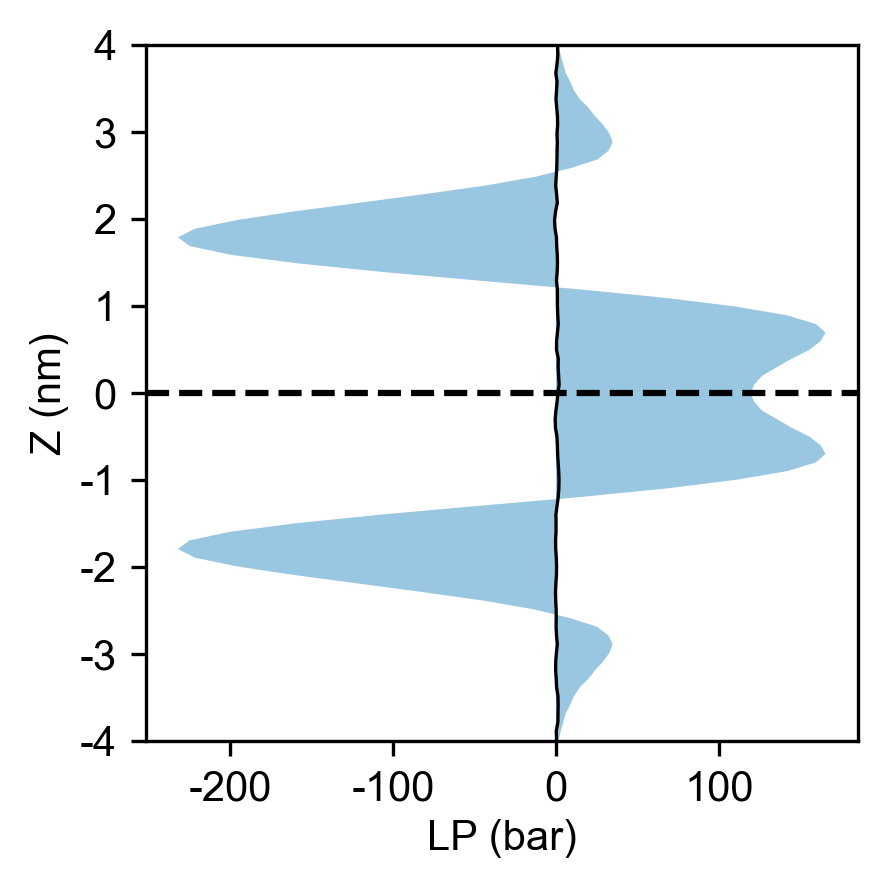

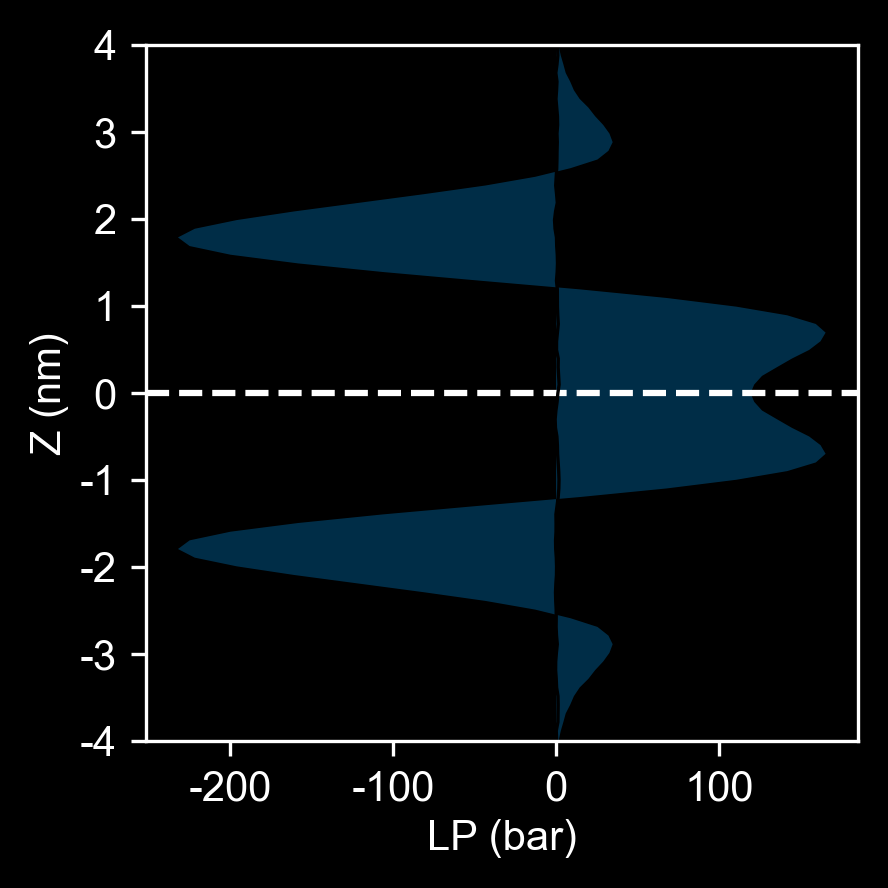

In [6]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

k = 3

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(
            1,
            1,
            figsize=(3, 3),
        )
        sim = util.remapping_dict[17]

        ax.axhline(0, linestyle="--", color=ecolor)
        data = np.mean(lateral_pressure[sim], axis=0)

        # for data in split_data:
        z = data[:, 2]

        ax.plot(
            data[:, 0] * 0.01,
            z,
            label="Normal pressure",
            linewidth=NORMAL_LINE,
            linestyle="-",
            color="k",
        )

        lateral = data[:, 1] * 0.01  # bar

        # Symmetrizing
        if len(lateral) % 2 == 1:
            s = int(np.floor(len(lateral) / 2))
            bot, mid, top = np.split(lateral, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            sym_lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lateral, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            sym_lp = np.hstack((sym_bot, sym_top))

            # ax.plot(
            #     sym_lp,
            #     z,
            #     label="Lateral Pressure",
            #     linewidth=NORMAL_LINE,
            #     linestyle="-",
            # )  # alpha=0.4,

        ax.fill_betweenx(z, sym_lp, 0, label="Lateral Pressure", alpha=0.4)

        ax.set_ylim(-4, 4)
        # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
        ax.set_xlabel("LP (bar)")
        ax.set_ylabel("Z (nm)")

        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"stress14{style_ext}")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


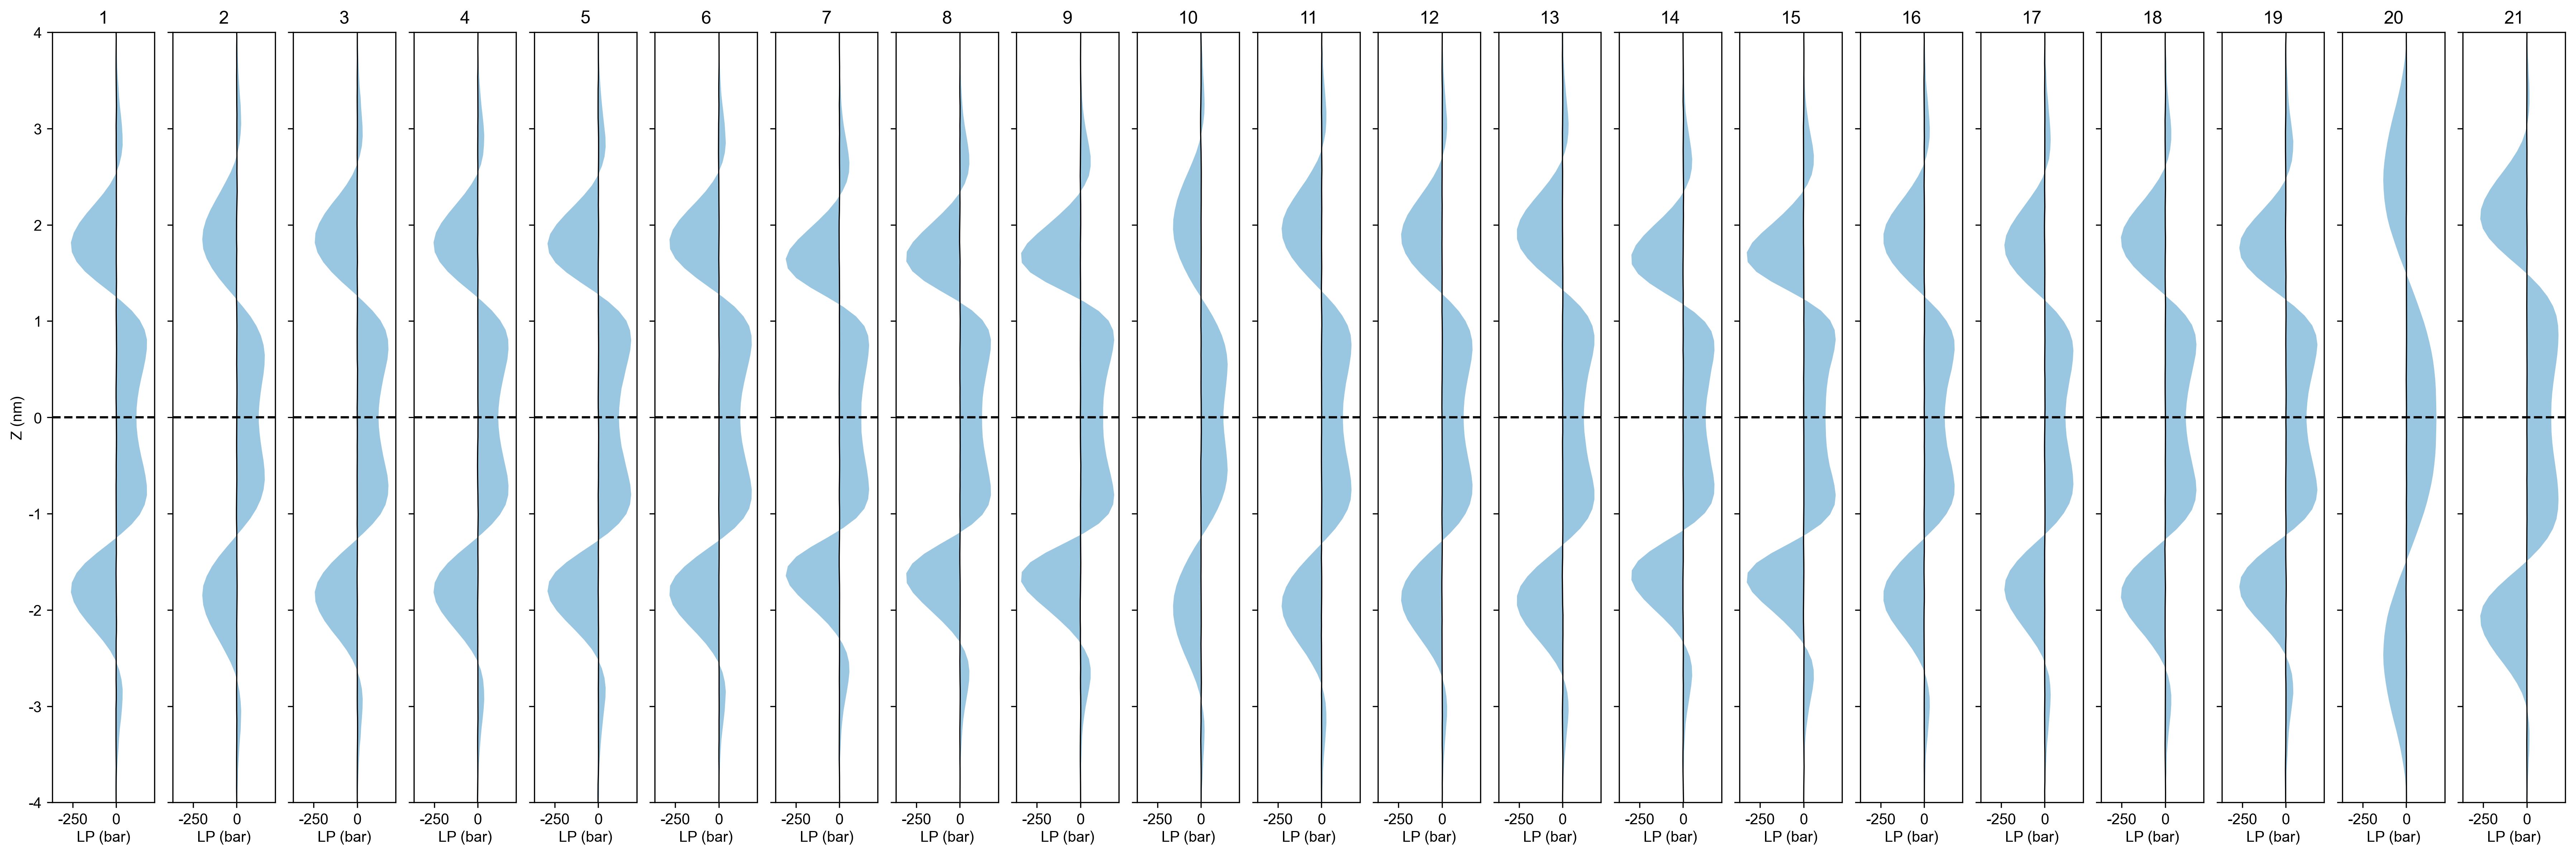

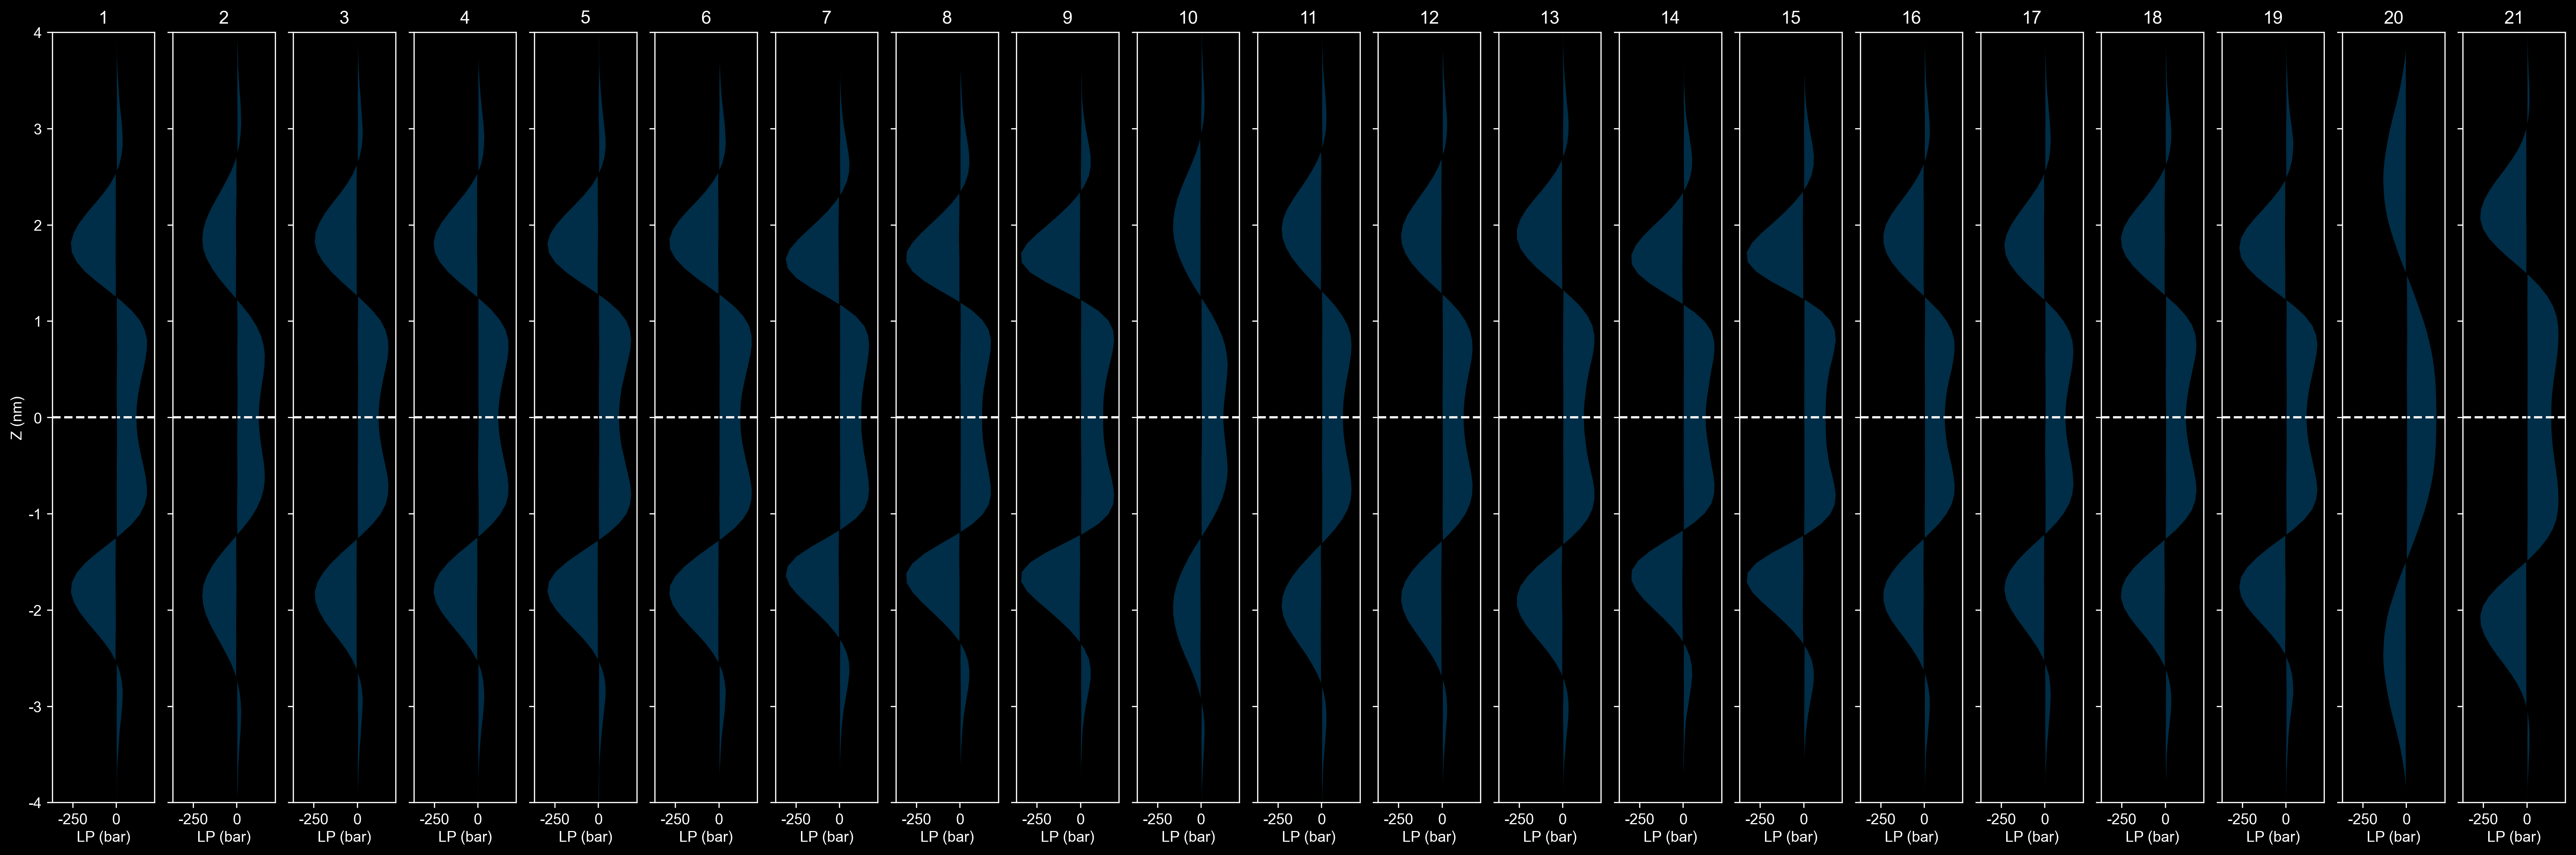

In [7]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

k = 3


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"


        fig, ax = plt.subplots(
            1, len(util.remapping_order), figsize=(24, 8), sharex=True, sharey=True
        )
        for sim_new in range(1, len(util.remapping_order) + 1):
            ax_index = int(sim_new) - 1
            sim = util.remapping_dict[sim_new]

            ax[ax_index].axhline(0, linestyle="--", color=ecolor)

            # k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

            # split_data = []
            # for split in k_fold_data:
            #     # print(split.shape)
            #     split_data.append(np.mean(split, axis=0))

            data = np.mean(lateral_pressure[sim], axis=0)

            # for data in split_data:
            z = data[:, 2]

            ax[ax_index].plot(
                data[:, 0] * 0.01,
                z,
                label="Normal Stress",
                linewidth=NORMAL_LINE,
                linestyle="-",
                color="k",
            )

            lateral = data[:, 1] * 0.01  # bar

            # Symmetrizing
            if len(lateral) % 2 == 1:
                s = int(np.floor(len(lateral) / 2))
                bot, mid, top = np.split(lateral, [s, s + 1])
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, mid, sym_top))
            else:
                bot, top = np.split(lateral, 2)
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, sym_top))

                # ax[ax_index].plot(
                #     sym_lp,
                #     z,
                #     label="Lateral Pressure",
                #     linewidth=NORMAL_LINE,
                #     linestyle="-",
                # )  # alpha=0.4,

            ax[ax_index].fill_betweenx(z, sym_lp, 0, label="Lateral Pressure", alpha=0.4)

            ax[ax_index].set_ylim(-4, 4)
            # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
            ax[ax_index].set_xlabel("LP (bar)")
            ax[ax_index].set_title(f"{sim_new}")
            if ax_index == 0:
                ax[ax_index].set_ylabel("Z (nm)")

        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"stress{style_ext}")
        
        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


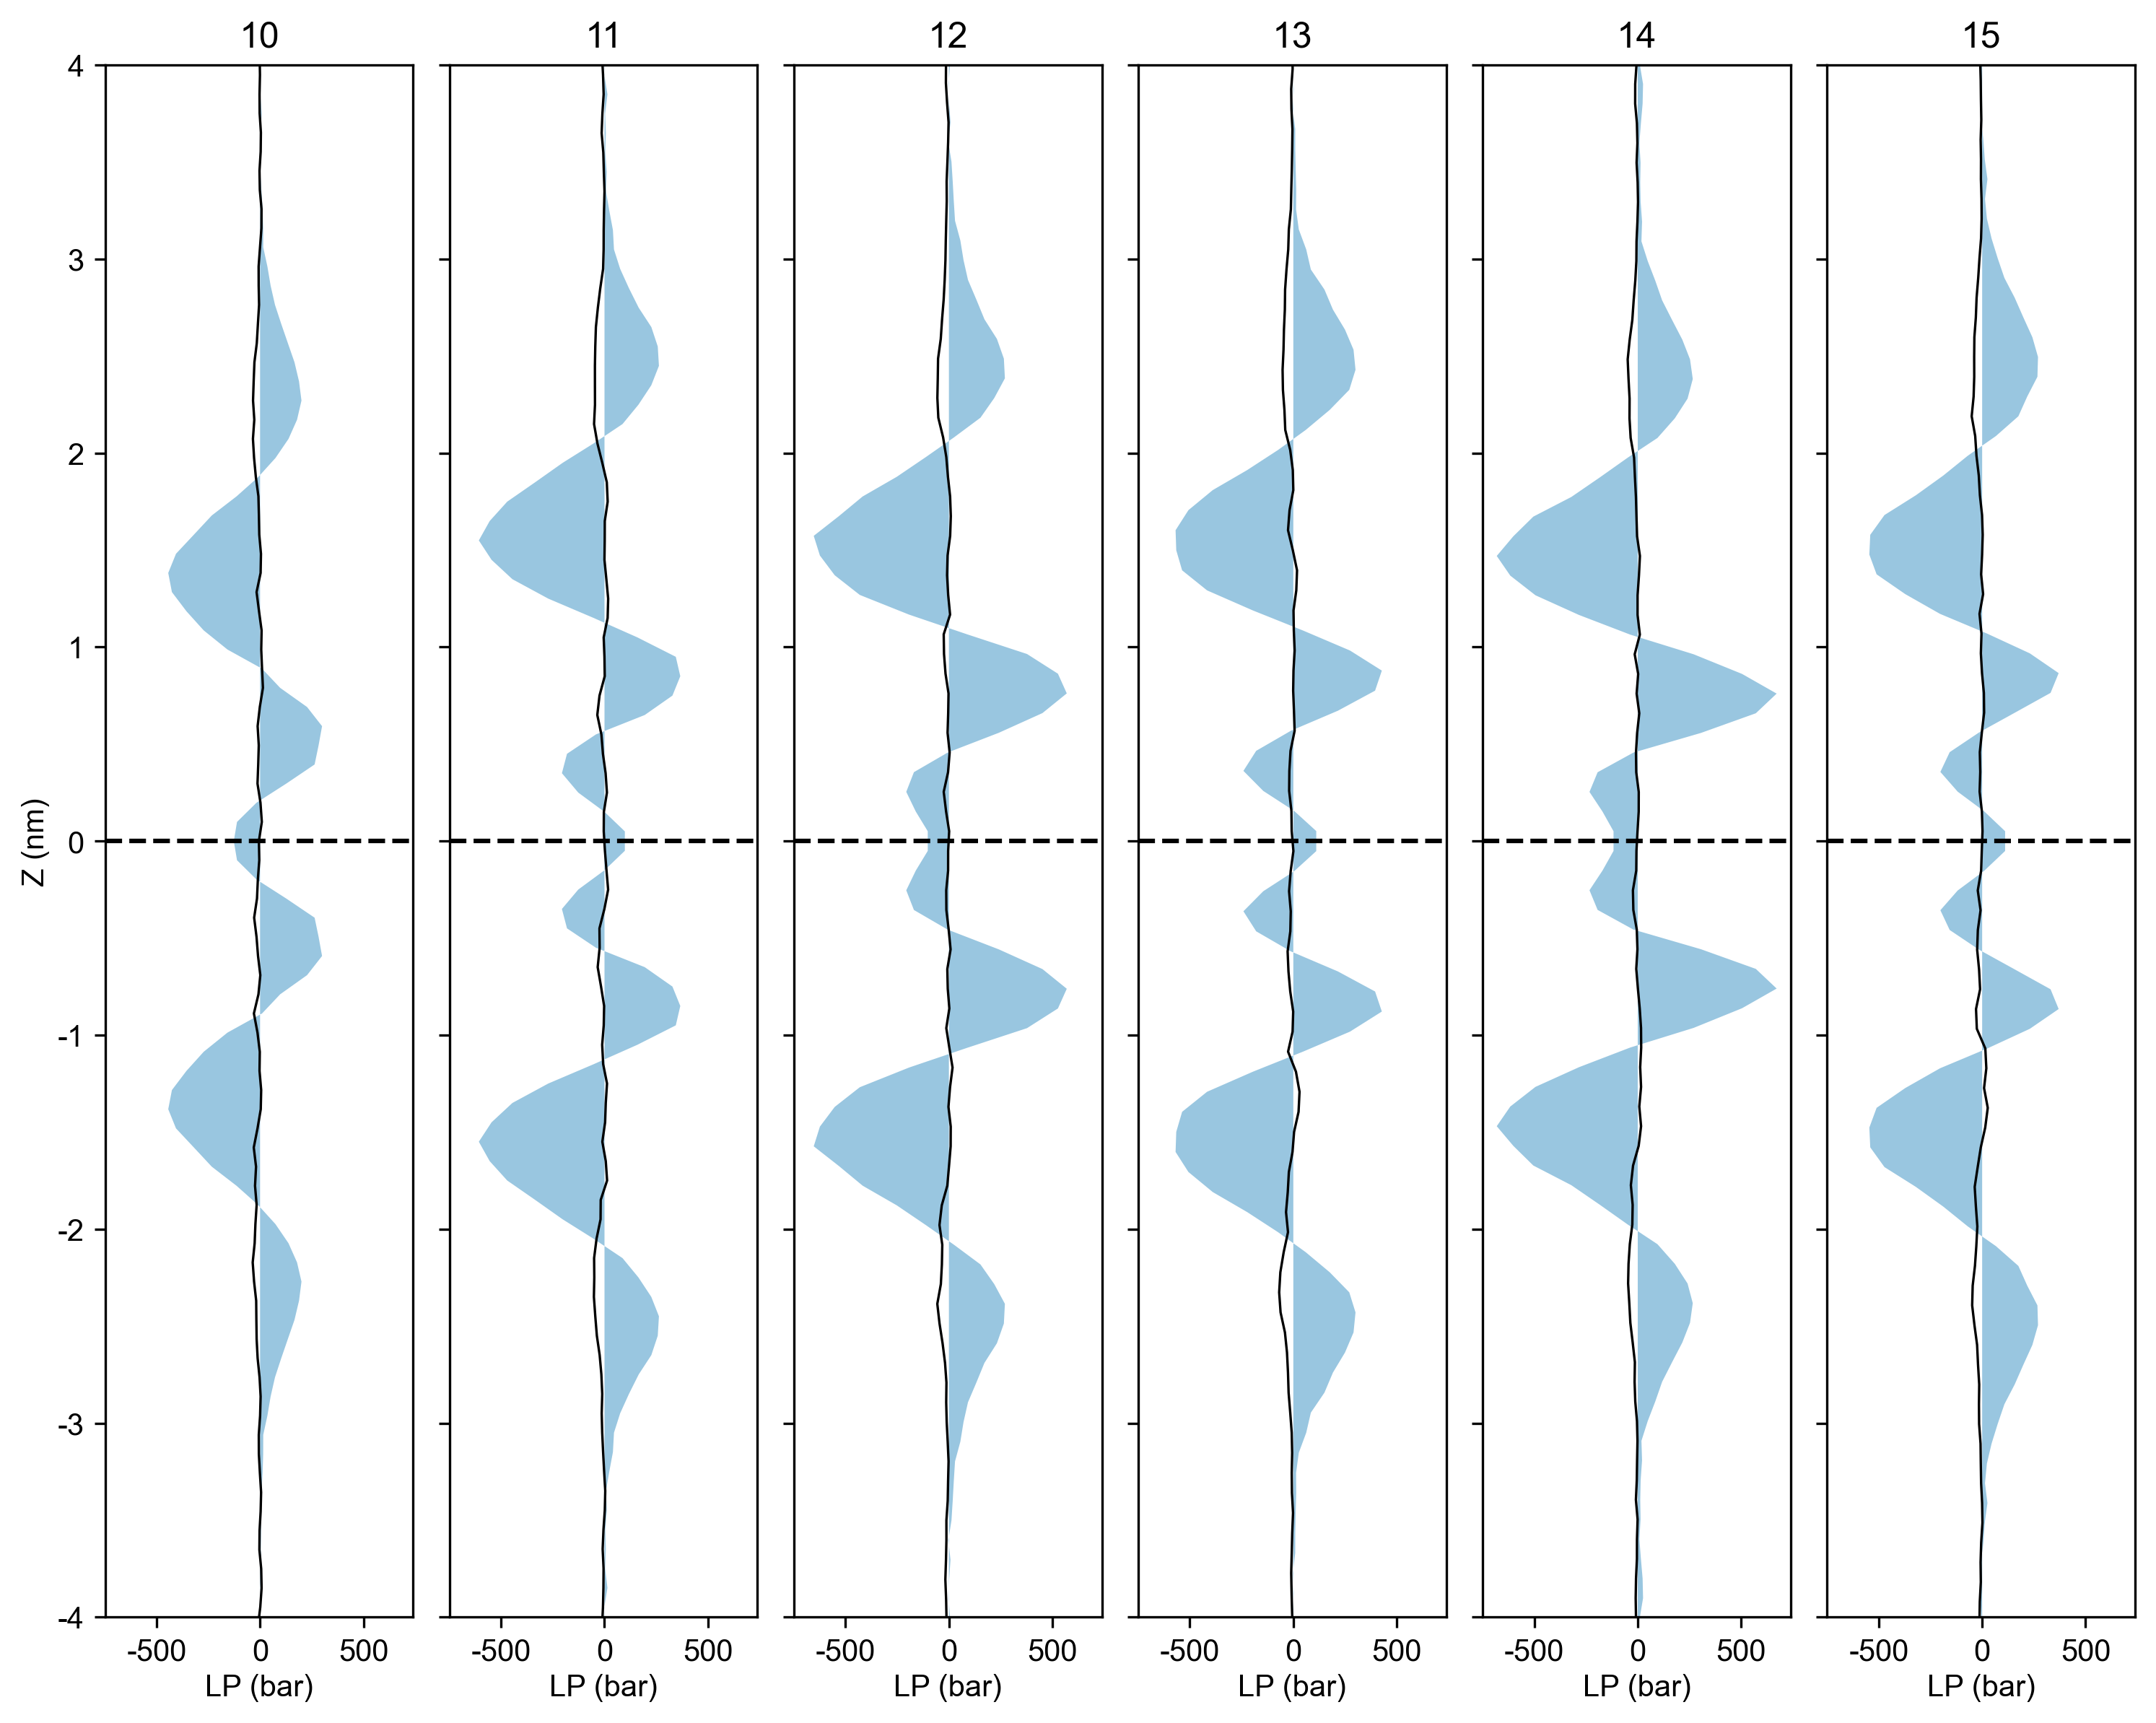

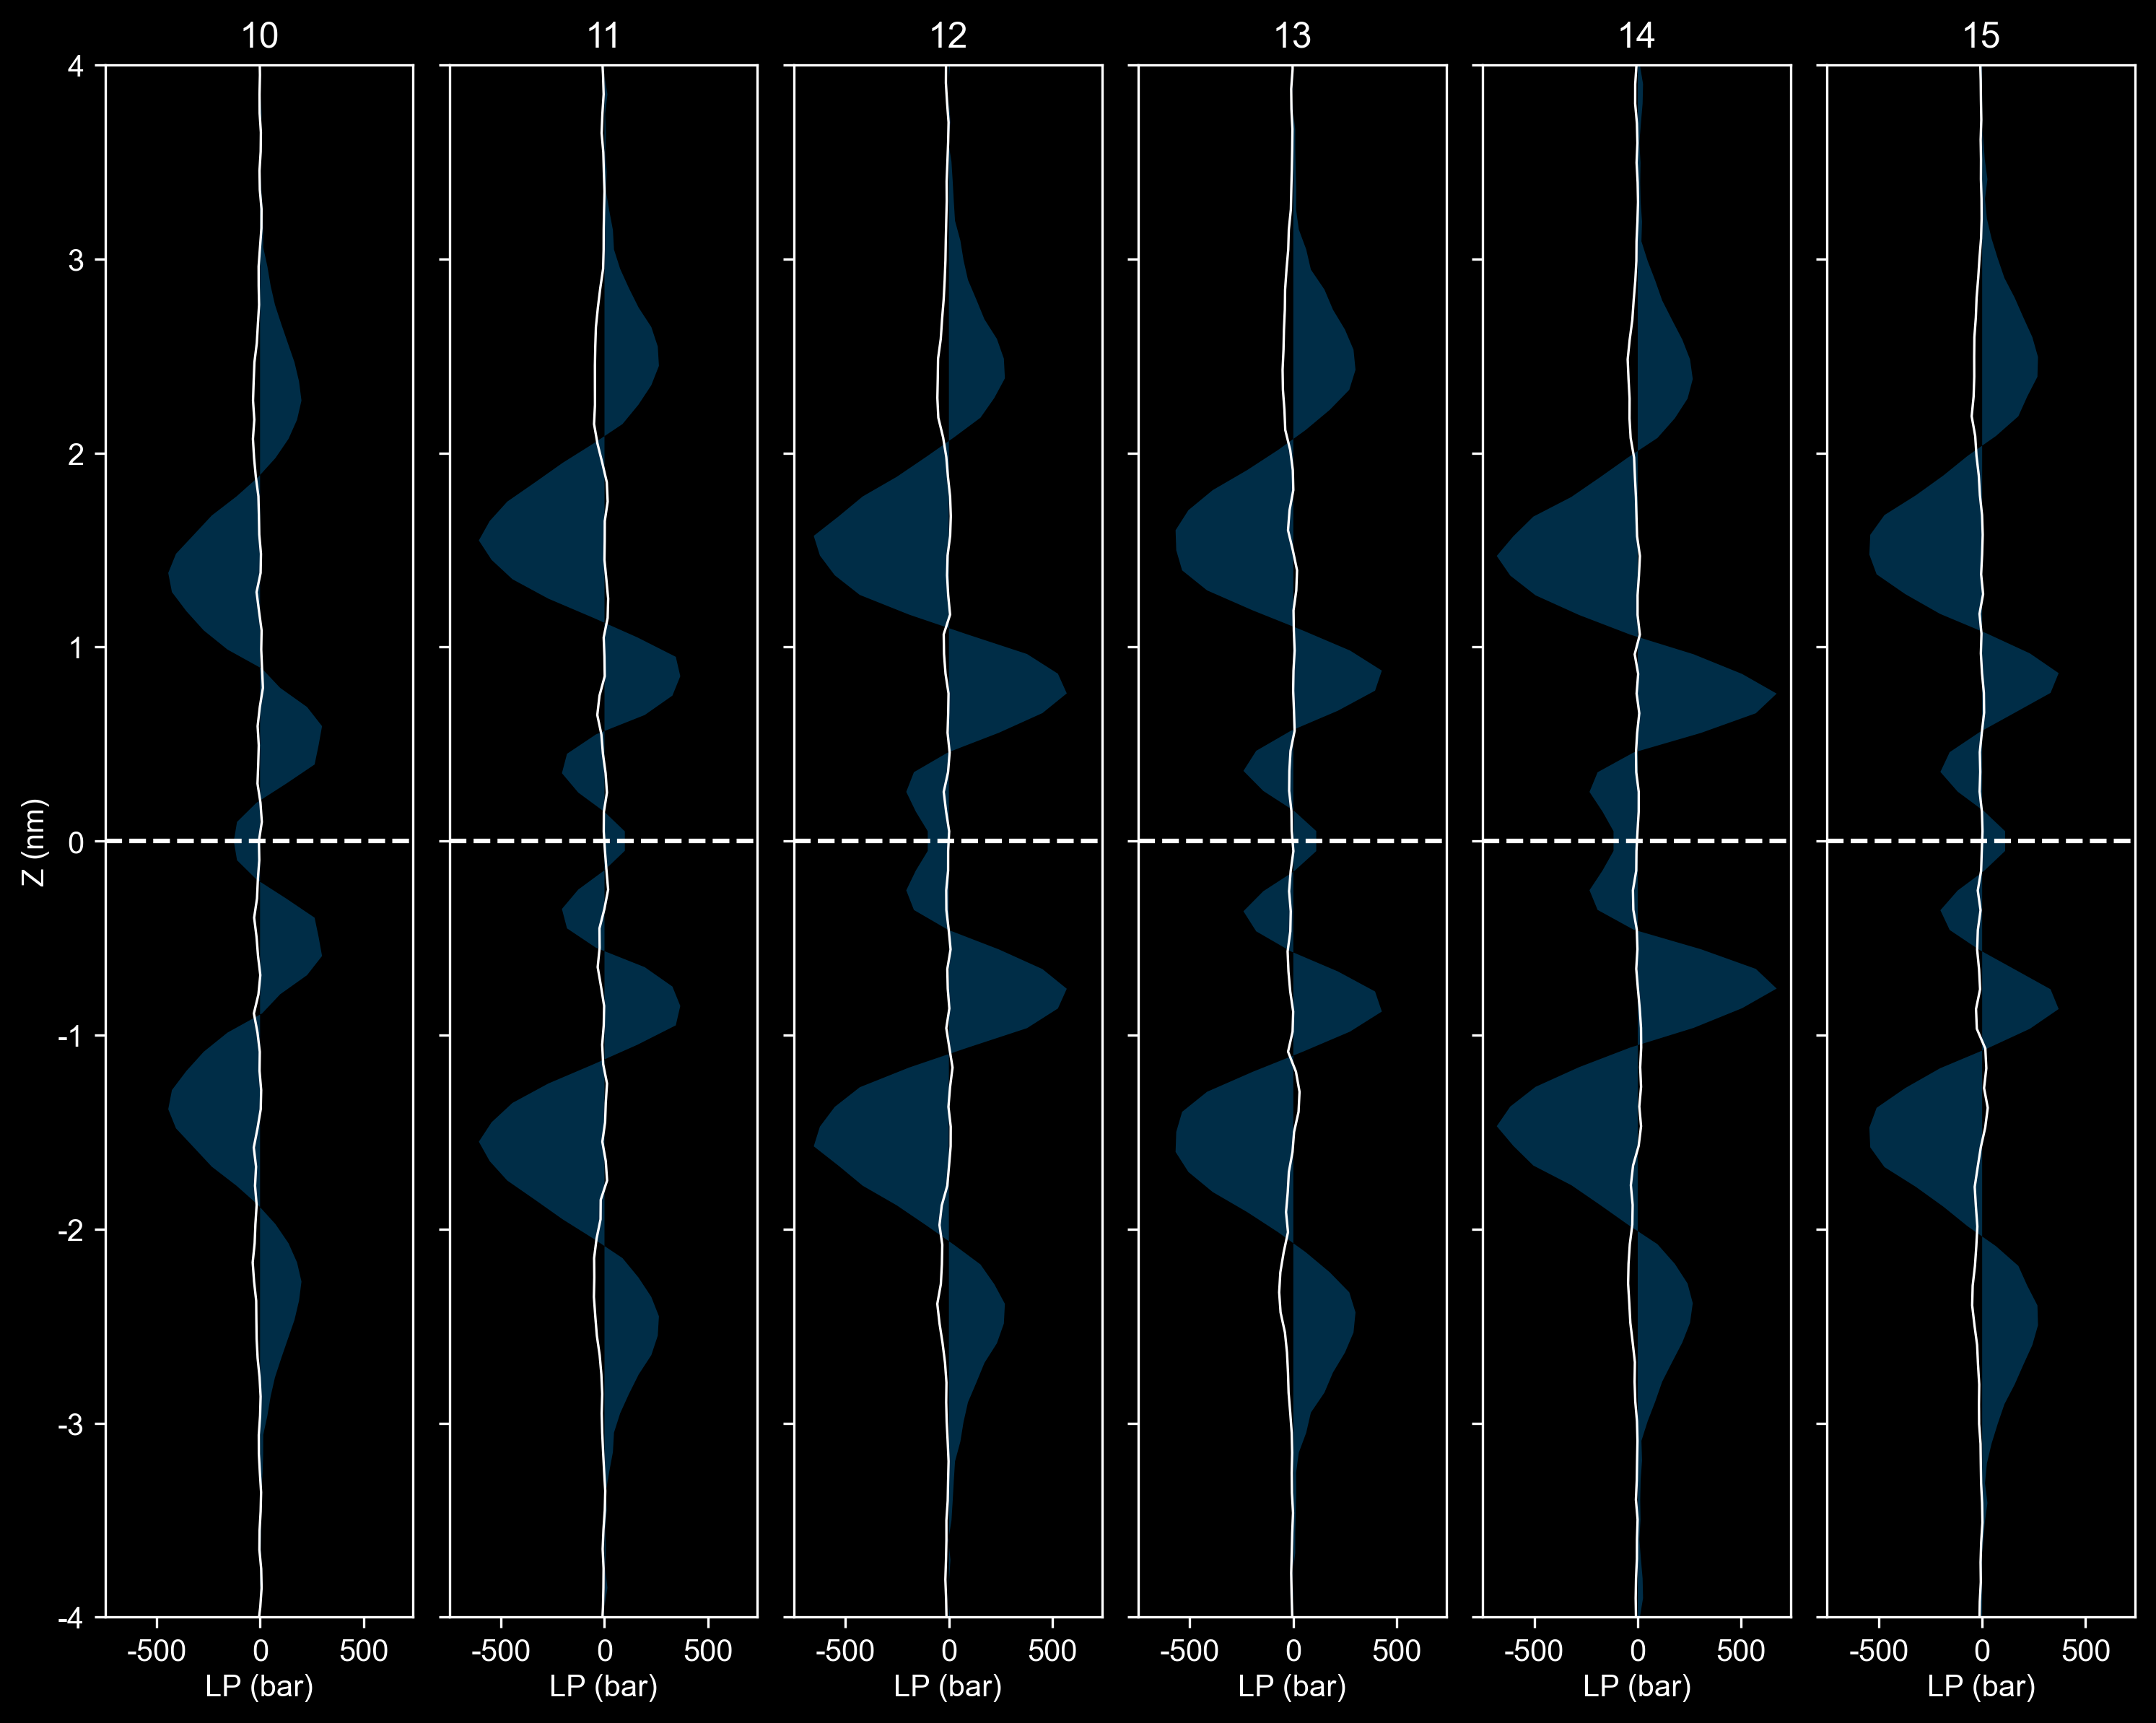

In [8]:
#################
# ATOMISTIC
#################

show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

k = 3

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(1, 6, figsize=(10, 8), sharex=True, sharey=True)
        for sim_new in range(10, 16):
            ax_index = int(sim_new) - 10
            sim = f"charmm36-sys-{sim_new}"

            ax[ax_index].axhline(0, linestyle="--", color=ecolor)

            # k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

            # split_data = []
            # for split in k_fold_data:
            #     # print(split.shape)
            #     split_data.append(np.mean(split, axis=0))

            # rows x (normal, lateral, z)
            data = np.zeros((aa_lateral_pressure[sim].shape[1], 3))

            for r in range(0, aa_lateral_pressure[sim].shape[1]):
                sl = aa_lateral_pressure[sim][:, r, 0]
                data[r][0] = np.mean(reject_outliers(sl))
                sl = aa_lateral_pressure[sim][:, r, 1]
                data[r][1] = np.mean(reject_outliers(sl))
                sl = aa_lateral_pressure[sim][:, r, 2]
                data[r][2] = np.mean(sl)

            # data = np.mean(aa_lateral_pressure[sim], axis=0)
            # print(data.shape)

            # for data in split_data:
            z = data[:, 2]

            ax[ax_index].plot(
                data[:, 0] * 0.01,
                z,
                label="Normal Stress",
                linewidth=NORMAL_LINE,
                linestyle="-",
                color=ecolor,
            )

            lateral = data[:, 1] * 0.01  # bar

            # Symmetrizing
            if len(lateral) % 2 == 1:
                s = int(np.floor(len(lateral) / 2))
                bot, mid, top = np.split(lateral, [s, s + 1])
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, mid, sym_top))
            else:
                bot, top = np.split(lateral, 2)
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, sym_top))

                # ax[ax_index].plot(
                #     sym_lp,
                #     z,
                #     label="Lateral Pressure",
                #     linewidth=NORMAL_LINE,
                #     linestyle="-",
                # )  # alpha=0.4,

            ax[ax_index].fill_betweenx(z, sym_lp, 0, label="Lateral Pressure", alpha=0.4)
            # ax[ax_index].fill_betweenx(
            #     z, lateral, 0, label="Lateral Pressure", alpha=0.4
            # )

            ax[ax_index].set_ylim(-4, 4)
            # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
            ax[ax_index].set_xlabel("LP (bar)")
            ax[ax_index].set_title(f"{sim_new}")
            if ax_index == 0:
                ax[ax_index].set_ylabel("Z (nm)")

            # ax[ax_index].set_xlim(-1000, 500)
        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"aa_stress{style_ext}")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)

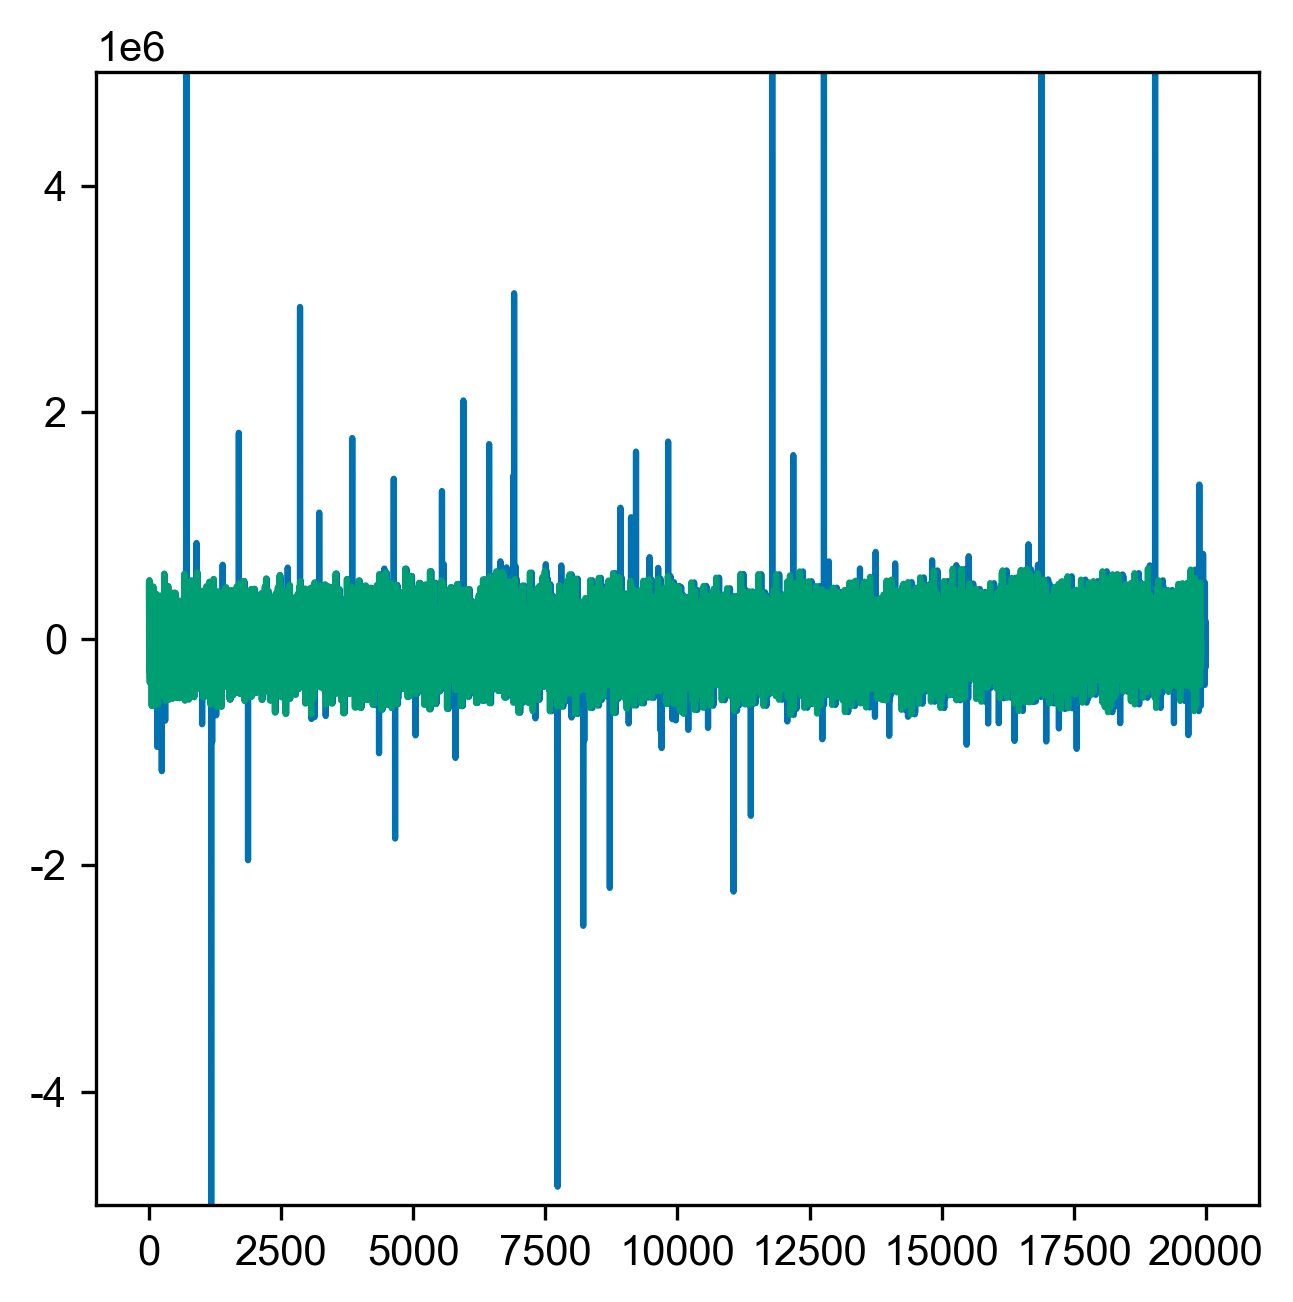

In [9]:
### EXPERIMENT HERE
sim = "charmm36-sys-13"
# data = np.mean(aa_lateral_pressure[sim], axis=0)
data = aa_lateral_pressure[sim]
data = data[:, 25, 1]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(data)
filt = reject_outliers(data)
ax.plot(filt)
rng = 5e6
ax.set_ylim((-rng, rng))
plt.show()
# for m in np.arange(2.0, 4.0, 0.1):
#     filt = reject_outliers(data, m)
#     print(m, data.shape, filt.shape, filt.shape[0] - data.shape[0])
#     print(np.min(filt), np.max(filt))

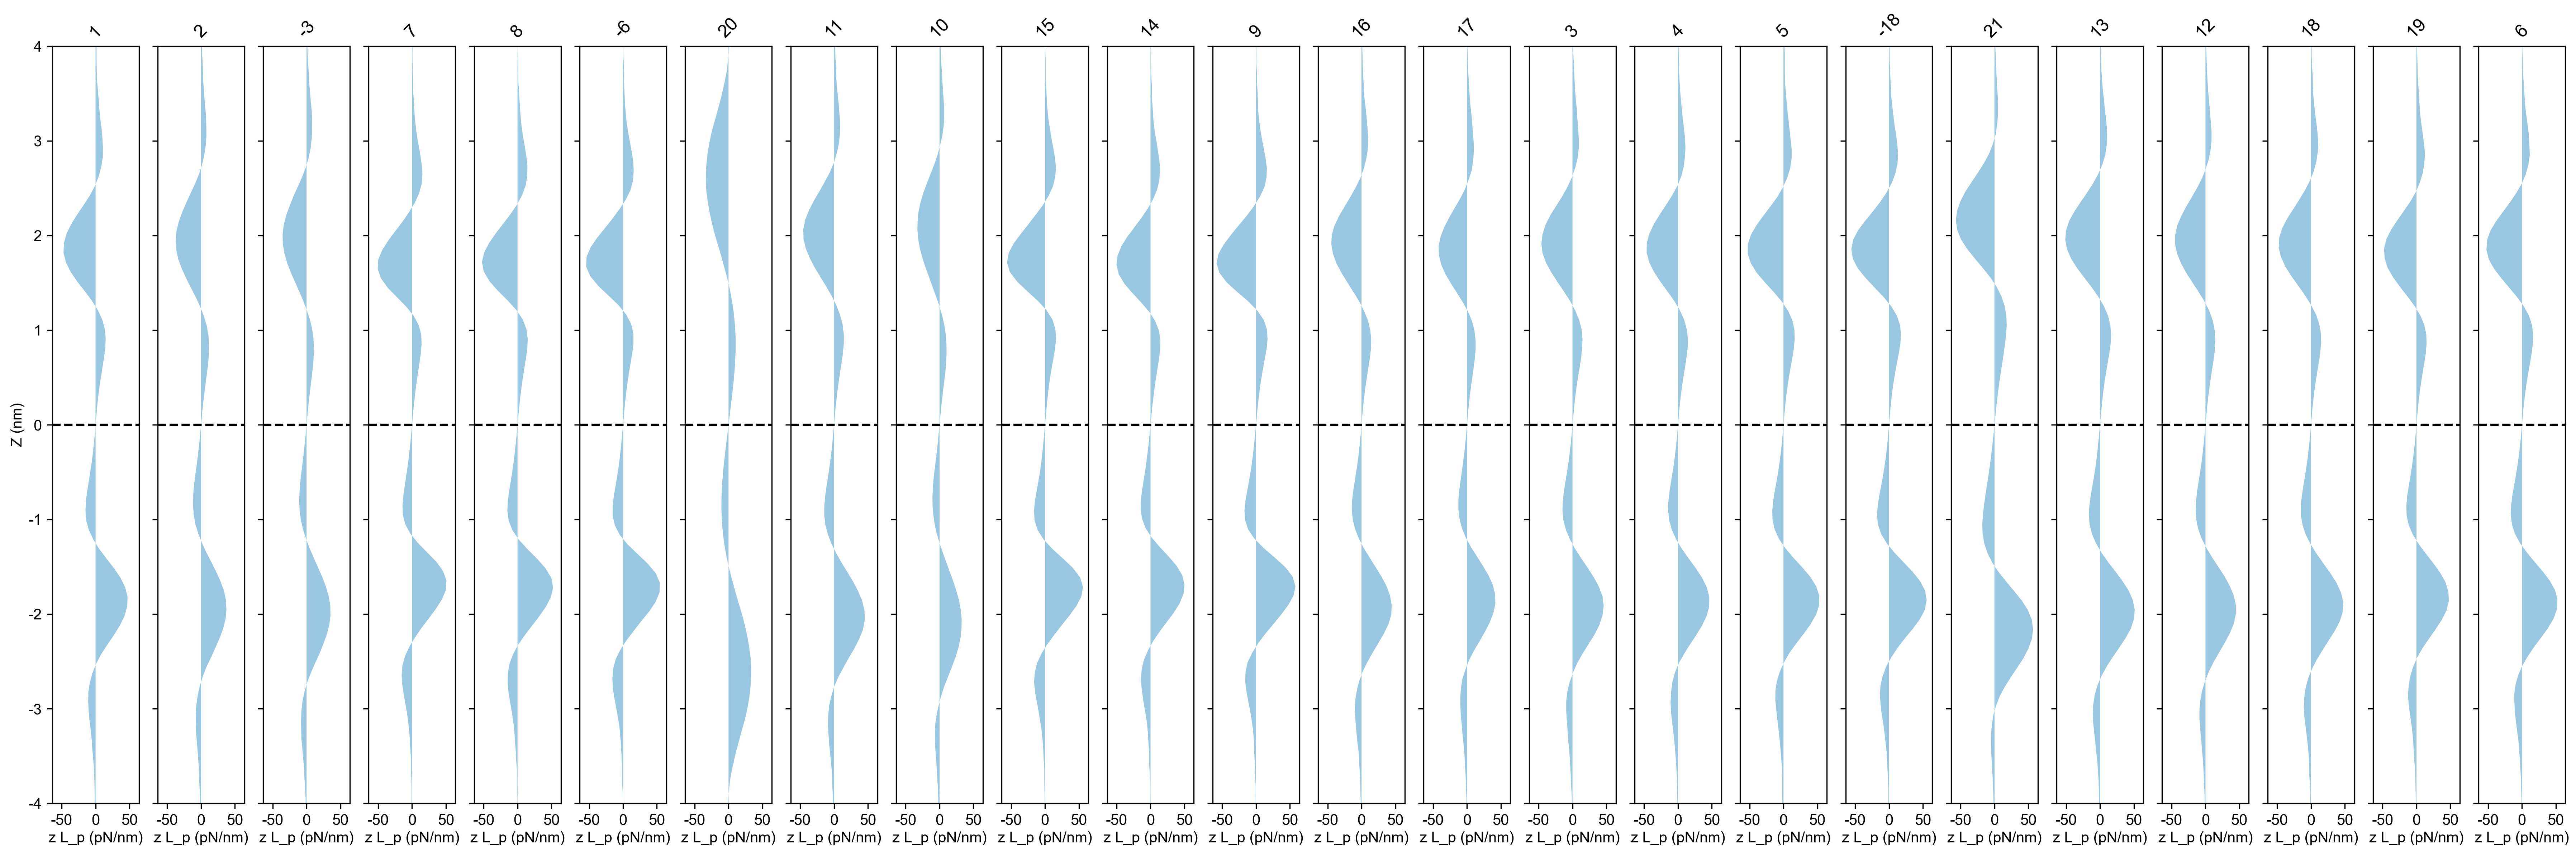

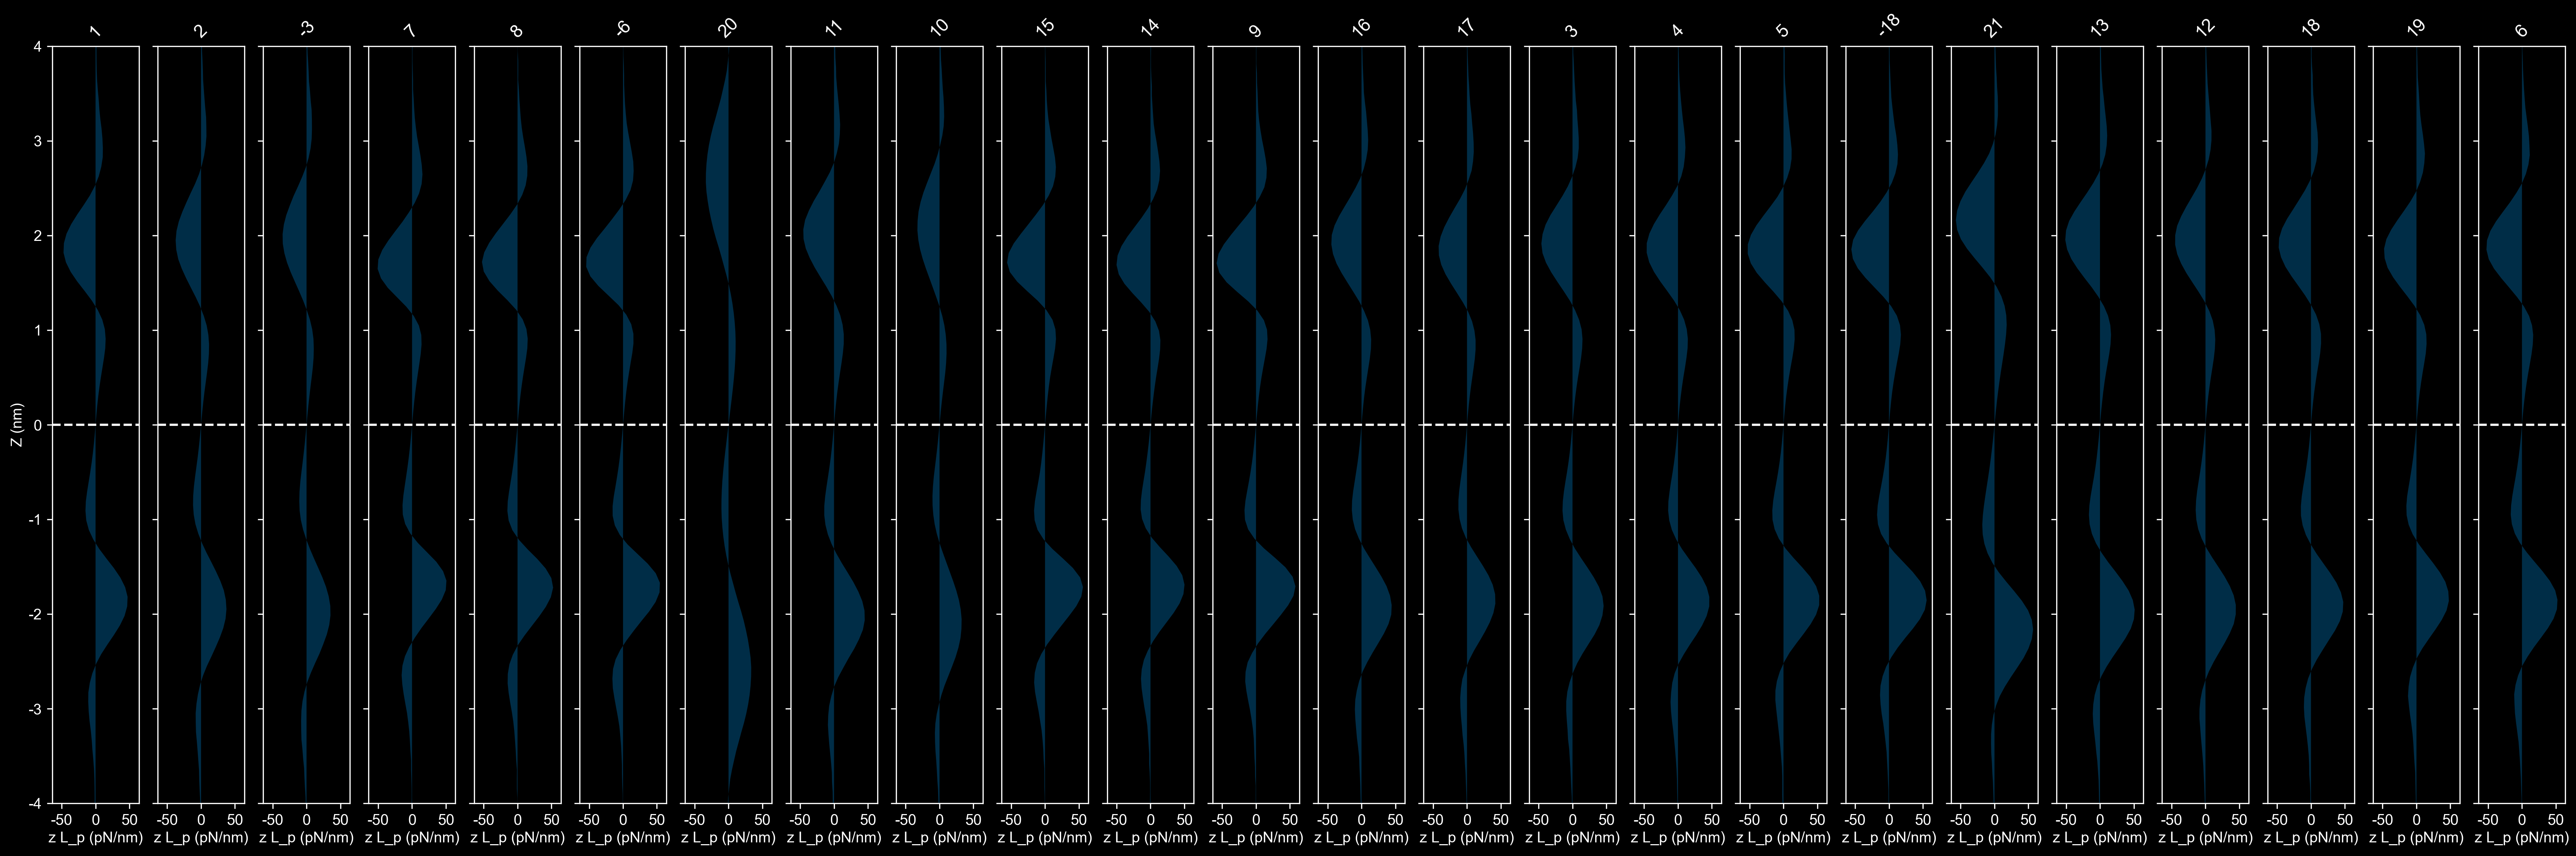

In [10]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"


        fig, ax = plt.subplots(1, 24, figsize=(24, 8), sharex=True, sharey=True)
        for sim in util.simulations:
            ax_index = int(sim) - 1
            ax[ax_index].axhline(0, linestyle="--", color=ecolor)

            data = np.mean(lateral_pressure[sim], axis=0)
            z = data[:, 2]

            lateral = data[:, 1] / 1e3  # pN/nm^2
            # Symmetrizing
            if len(lateral) % 2 == 1:
                s = int(np.floor(len(lateral) / 2))
                bot, mid, top = np.split(lateral, [s, s + 1])
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, mid, sym_top))
            else:
                bot, top = np.split(lateral, 2)
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, sym_top))

            ax[ax_index].fill_betweenx(z, z * sym_lp, 0, label="Lateral Stress", alpha=0.4)

            ax[ax_index].set_ylim(-4, 4)
            # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
            ax[ax_index].set_xlabel("z L_p (pN/nm)")
            ax[ax_index].set_title(f"{util.sim_to_final_index[sim]}", rotation=45)
            if ax_index == 0:
                ax[ax_index].set_ylabel("Z (nm)")

        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"first_mom_integrand{style_ext}")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


In [11]:


show_figs = False

k = 3  # Number of sections to split data into

f_cubic_dat = {}

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        for sim in util.simulations:
            k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

            data = []
            for split in k_fold_data:
                # print(split.shape)
                data.append(np.mean(split, axis=0))

            # fig, ax = plt.subplots(1, 1, figsize=(8, 8))

            fcd = np.zeros(k)
            for i, d in enumerate(data):
                z = d[:, 2]
                lateral = d[:, 1]

                # Symmetrizing
                if len(lateral) % 2 == 1:
                    s = int(np.floor(len(lateral) / 2))
                    bot, mid, top = np.split(lateral, [s, s + 1])
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, mid, sym_top))
                else:
                    bot, top = np.split(lateral, 2)
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, sym_top))

                # ax.plot(sym_lp, z, label="Lateral Pressure", alpha=0.4)

                fcd[i] = (
                    first_cubic_np(z, sym_lp, maxz=0)[0] - first_cubic_np(z, sym_lp, minz=0)[0]
                ) / 2
            f_cubic_dat[sim] = (np.mean(fcd), np.std(fcd))
            print(sim, fcd, f_cubic_dat[sim])

            # ax.set_ylim(-4, 4)

            # plt.tight_layout()

            # save_fig(fig, curr_fig_path / f"first_mom_integrand{style_ext}")

            # if show_figs:
            #     plt.show()
            # fig.clear()
            # plt.close(fig)


1 [16.59469922 14.55668819 16.94720107] (16.03286282437595, 1.0536865621641713)
2 [17.52726536 15.83330157 18.26359158] (17.20805283906782, 1.0175132614673912)
3 [14.40764142 16.55763774 15.77397017] (15.579749778219139, 0.8884113996045878)
4 [13.3438027  12.4423631  12.62415984] (12.803441878734608, 0.38923418458540543)
5 [15.24026407 14.74404498 14.96380343] (14.98270415952958, 0.20302097290977134)
6 [12.62684218 13.15516208 15.95883532] (13.913613195348134, 1.4621857253141024)
7 [35.42594531 33.34649389 35.18818992] (34.65354304080213, 0.929306198632866)
8 [20.64406544 21.68749991 21.20471021] (21.178758520273263, 0.42637541322155437)
9 [19.76523808 19.94536227 19.81329367] (19.84129800631053, 0.07615494354665889)
10 [14.15602489 15.78044644 15.60508639] (15.180519240533705, 0.727955718565714)
11 [13.44672772 13.99581197 16.52223739] (14.654925696753708, 1.3392816737315514)
12 [18.68183714 17.17615513 14.71095189] (16.85631471842346, 1.6368070225401494)
13 [20.77317152 20.72250358 1

In [12]:
#################
# ATOMISTIC
#################

show_figs = False

k = 3  # Number of sections to split data into
naive_split = False
aa_f_cubic_dat = {}

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        for sim_new in range(10, 16):
            sim = f"charmm36-sys-{sim_new}"

            if naive_split:
                k_fold_data = np.array_split(aa_lateral_pressure[sim], k, axis=0)

                data = []
                for split in k_fold_data:
                    # print(split.shape)
                    data.append(np.mean(split, axis=0))
            else:
                collector = np.zeros((k, aa_lateral_pressure[sim].shape[1], 3))
                # rows x (normal, lateral, z)
                for r in range(0, aa_lateral_pressure[sim].shape[1]):
                    no_outlier_normal = reject_outliers(
                        aa_lateral_pressure[sim][:, r, 0]
                    )
                    no_outlier_lp = reject_outliers(aa_lateral_pressure[sim][:, r, 1])
                    z = aa_lateral_pressure[sim][:, r, 2]

                    k_fold_normal = np.array_split(no_outlier_normal, k, axis=0)
                    k_fold_lp = np.array_split(no_outlier_lp, k, axis=0)
                    z = np.array_split(z, k, axis=0)

                    for i in range(k):
                        collector[i, r, 0] = np.mean(k_fold_normal[i], axis=0)
                        collector[i, r, 1] = np.mean(k_fold_lp[i], axis=0)
                        collector[i, r, 2] = np.mean(z[i], axis=0)

                data = []
                for i in range(k):
                    data.append(collector[i])

            # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            fcd = np.zeros(k)
            for i, d in enumerate(data):
                z = d[:, 2]
                lateral = d[:, 1]

                # Symmetrizing
                if len(lateral) % 2 == 1:
                    s = int(np.floor(len(lateral) / 2))
                    bot, mid, top = np.split(lateral, [s, s + 1])
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, mid, sym_top))
                else:
                    bot, top = np.split(lateral, 2)
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, sym_top))

                # ax.plot(sym_lp, z, label="Lateral Pressure", alpha=0.4)

                fcd[i] = (
                    first_cubic_np(z, sym_lp, maxz=0)[0]
                    - first_cubic_np(z, sym_lp, minz=0)[0]
                ) / 2
            aa_f_cubic_dat[sim] = (np.mean(fcd), np.std(fcd))
            print(sim, fcd, aa_f_cubic_dat[sim])

            # ax.set_ylim(-4, 4)

            # plt.tight_layout()

            # save_fig(fig, curr_fig_path / f"first_mom_integrand{style_ext}")

            # if show_figs:
            #     plt.show()
            # fig.clear()
            # plt.close(fig)

charmm36-sys-10 [-3.62453253 -5.49580003 -1.64904186] (-3.5897914722875064, 1.570624569763145)
charmm36-sys-11 [ 4.22003024  0.7859642  -4.46956766] (0.17880892824651262, 3.57339764519614)
charmm36-sys-12 [-8.45974629 -5.33232196 -0.01757615] (-4.603214798697262, 3.484848836108975)
charmm36-sys-13 [-8.61279705 -3.64229066 -1.31437453] (-4.5231540821994445, 3.0439758079496864)
charmm36-sys-14 [ -9.12225556 -13.8457734   -3.04548858] (-8.67117251471677, 4.420719772292828)
charmm36-sys-15 [-13.7826009   -4.75855592  -3.80781397] (-7.449656930894464, 4.494857215781437)
charmm36-sys-10 [-3.62453253 -5.49580003 -1.64904186] (-3.5897914722875064, 1.570624569763145)
charmm36-sys-11 [ 4.22003024  0.7859642  -4.46956766] (0.17880892824651262, 3.57339764519614)
charmm36-sys-12 [-8.45974629 -5.33232196 -0.01757615] (-4.603214798697262, 3.484848836108975)
charmm36-sys-13 [-8.61279705 -3.64229066 -1.31437453] (-4.5231540821994445, 3.0439758079496864)
charmm36-sys-14 [ -9.12225556 -13.8457734   -3.04

In [13]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


pal = sns.color_palette("colorblind")
bar_props = [
    (1, 1, None),
    (3, 1, None),
    (2, 1.1, None),
    (2, 0.95, "///"),
]


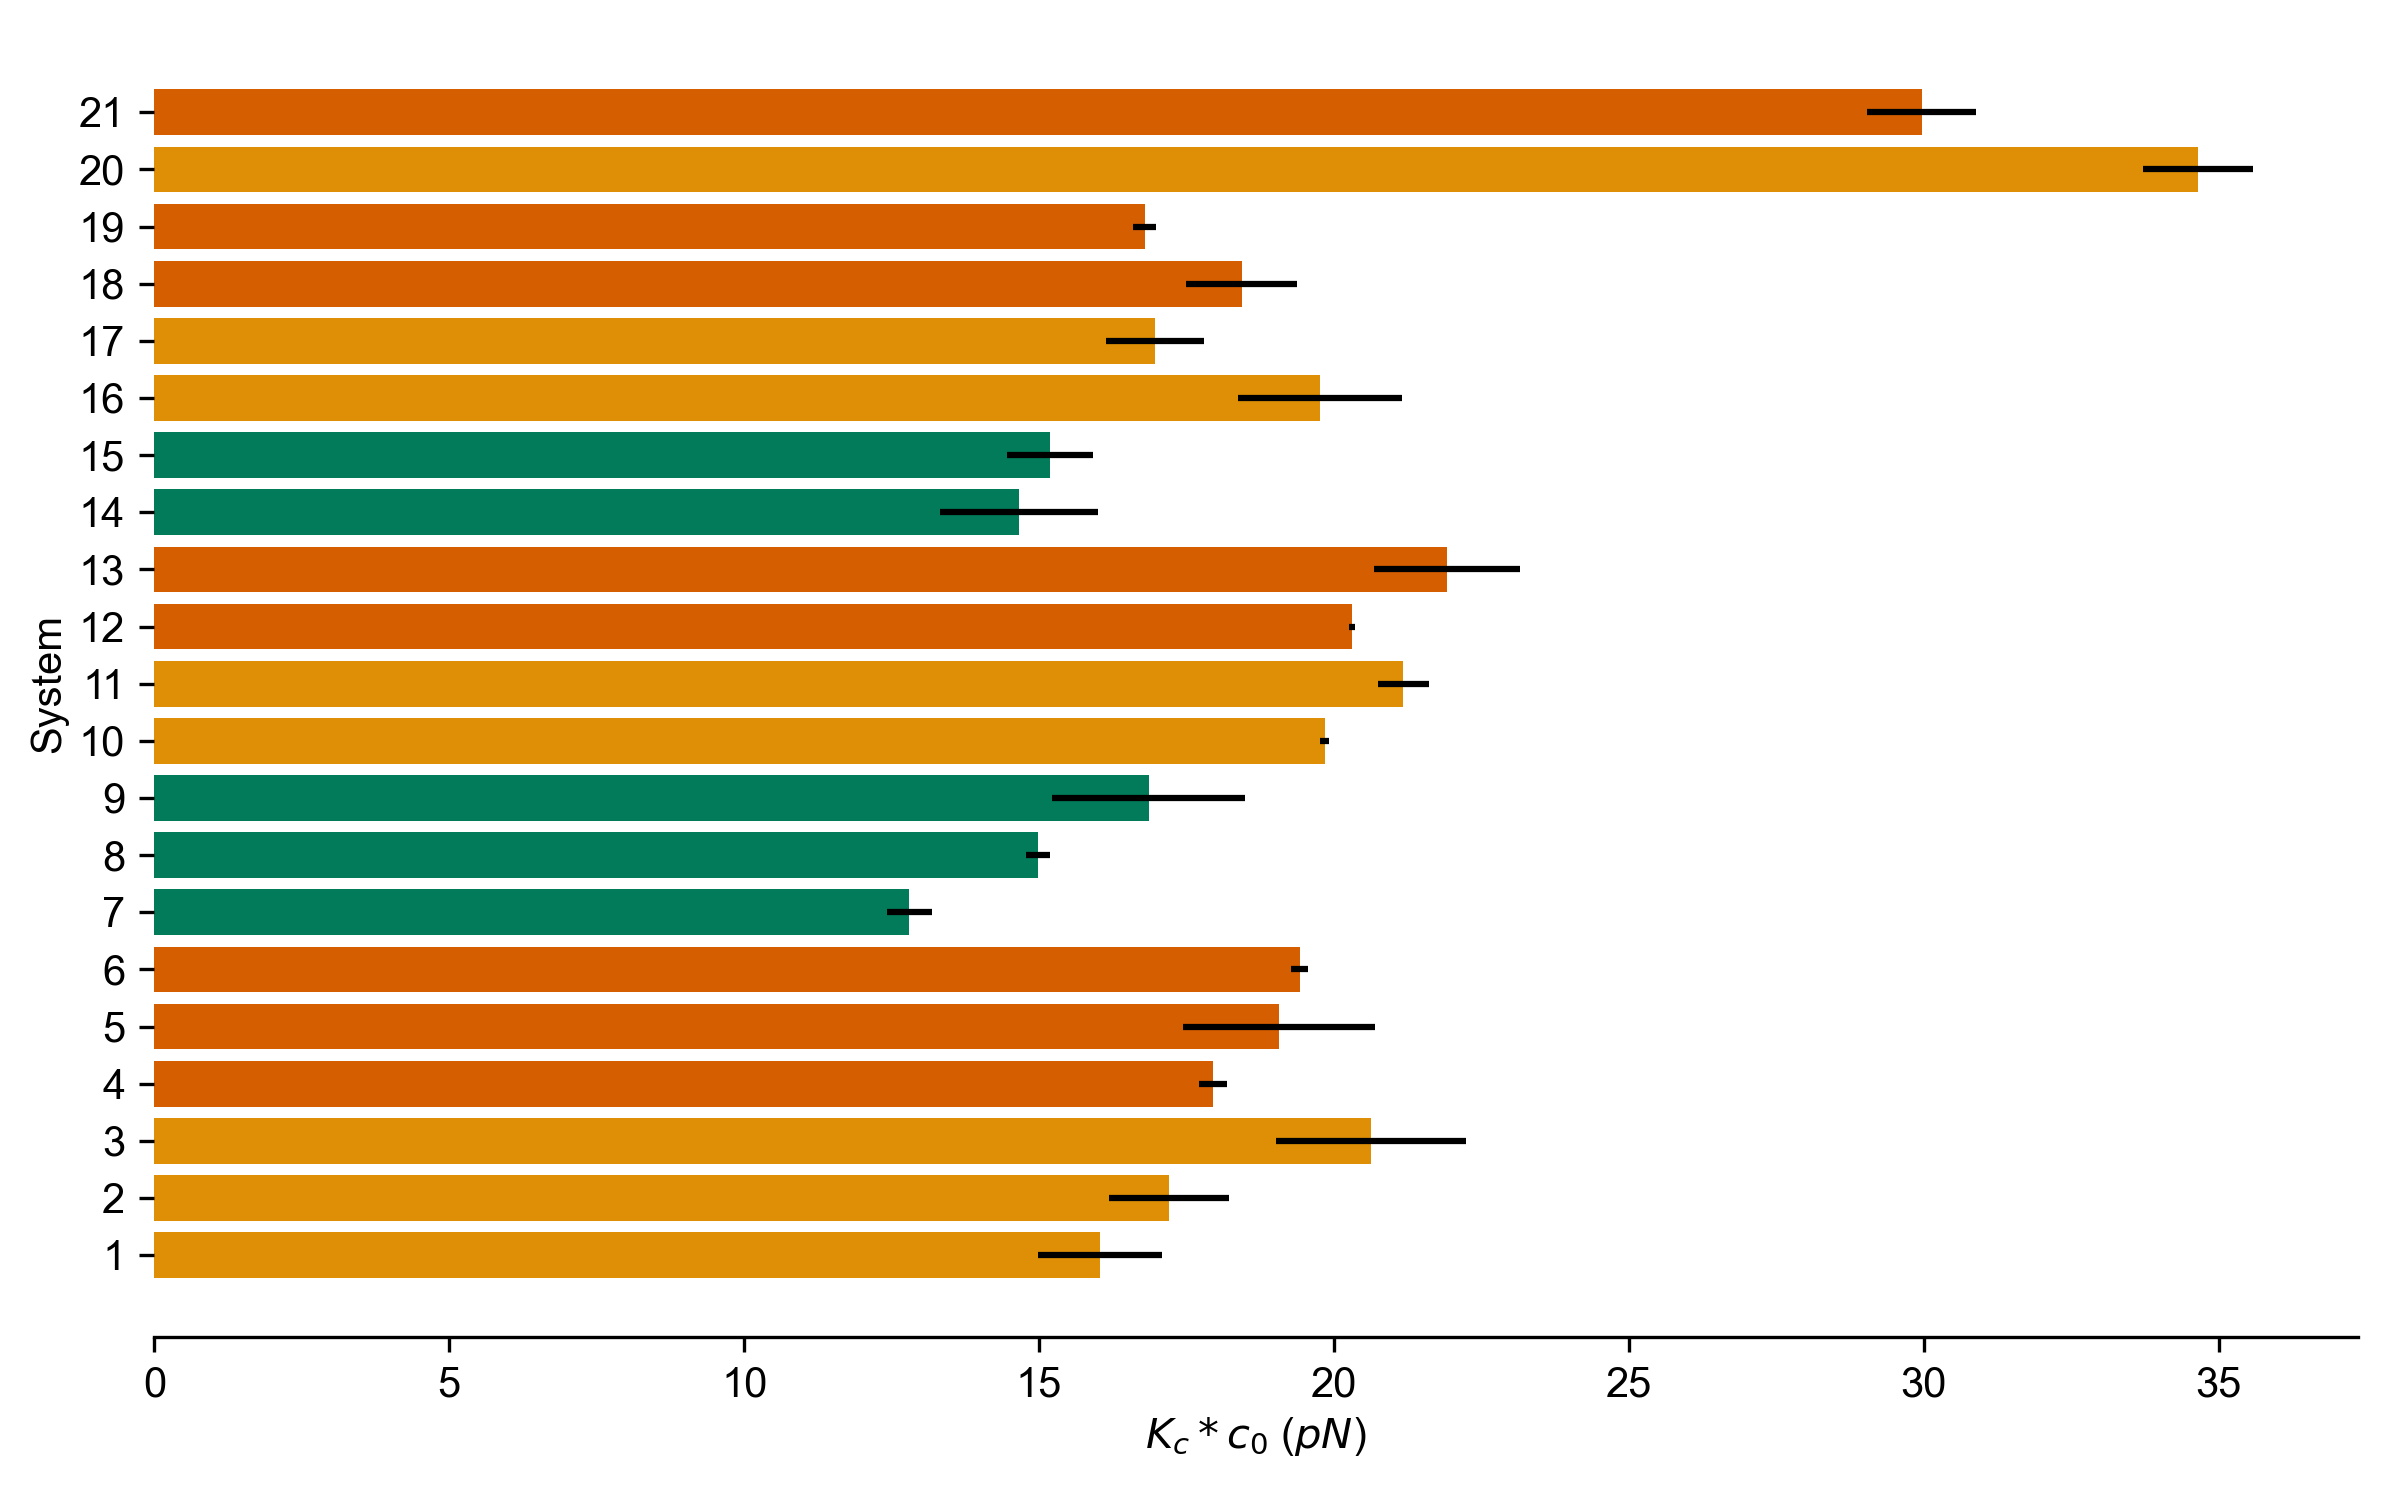

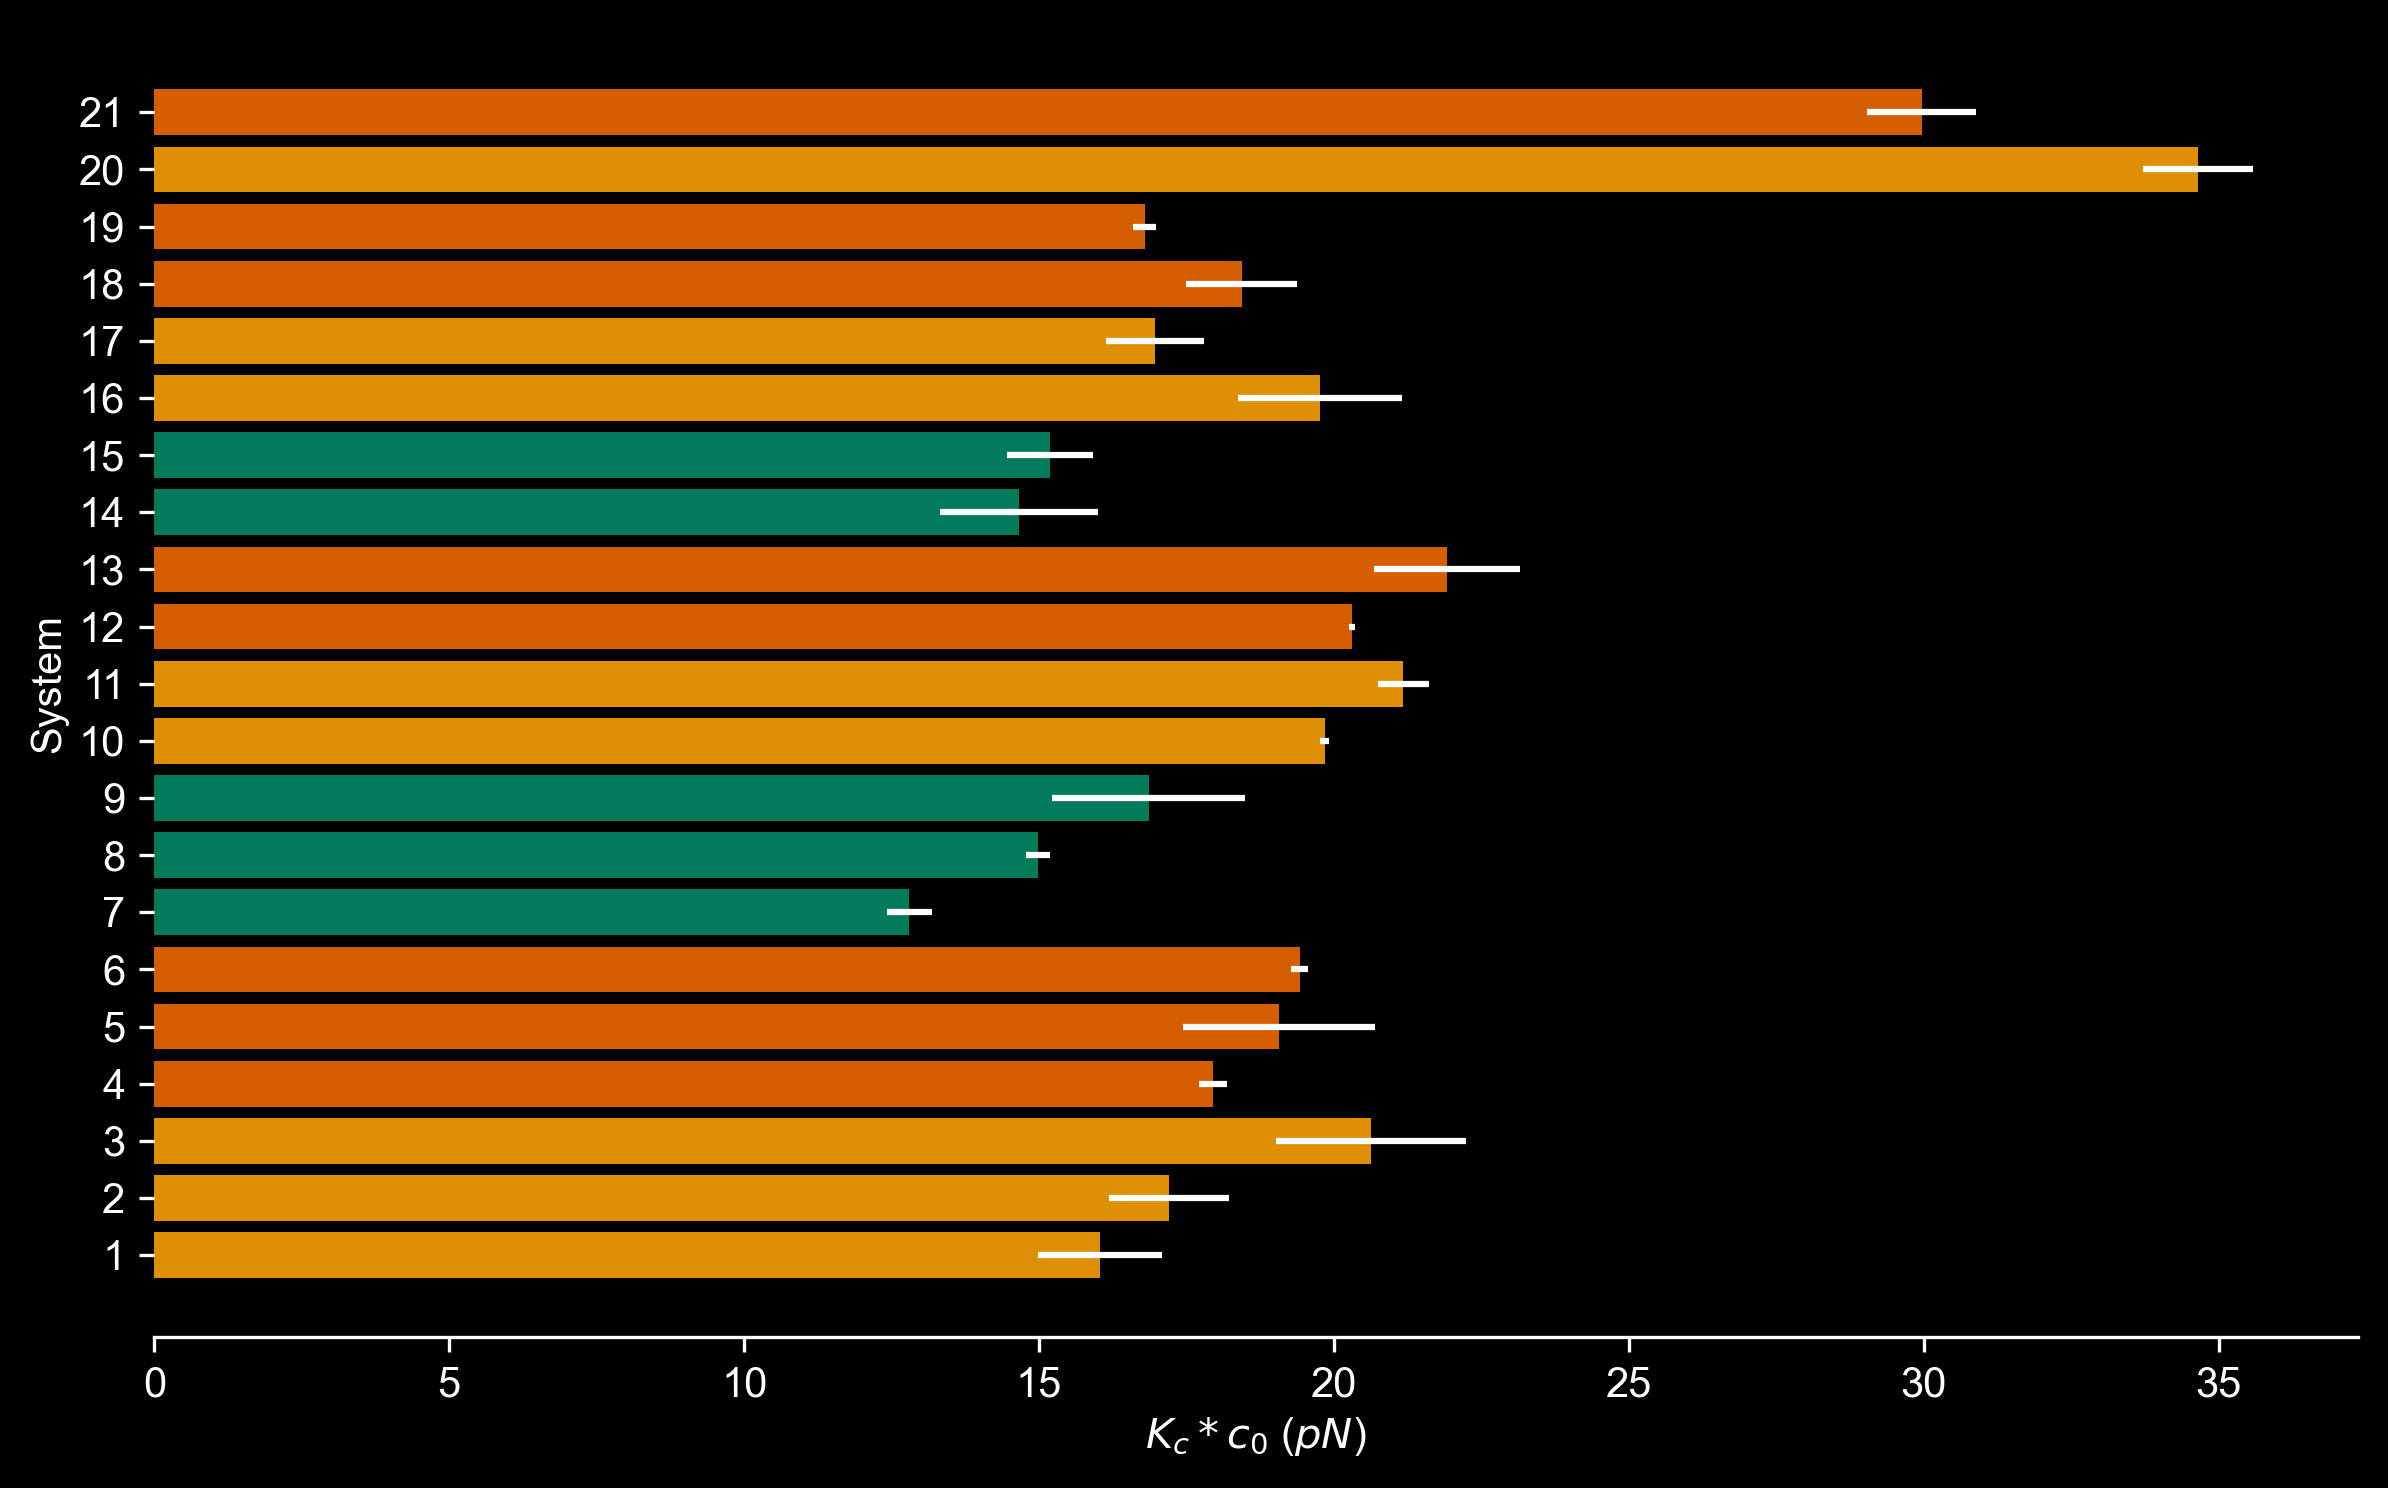

In [14]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(4, 7):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(12, 14):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(16, 18):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(18, 20):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        ax.barh(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            xerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
            height=0.8,
        )

        ax.barh(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            xerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
            height=0.8,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"$K_c*c_0$ ($pN$)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_all{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


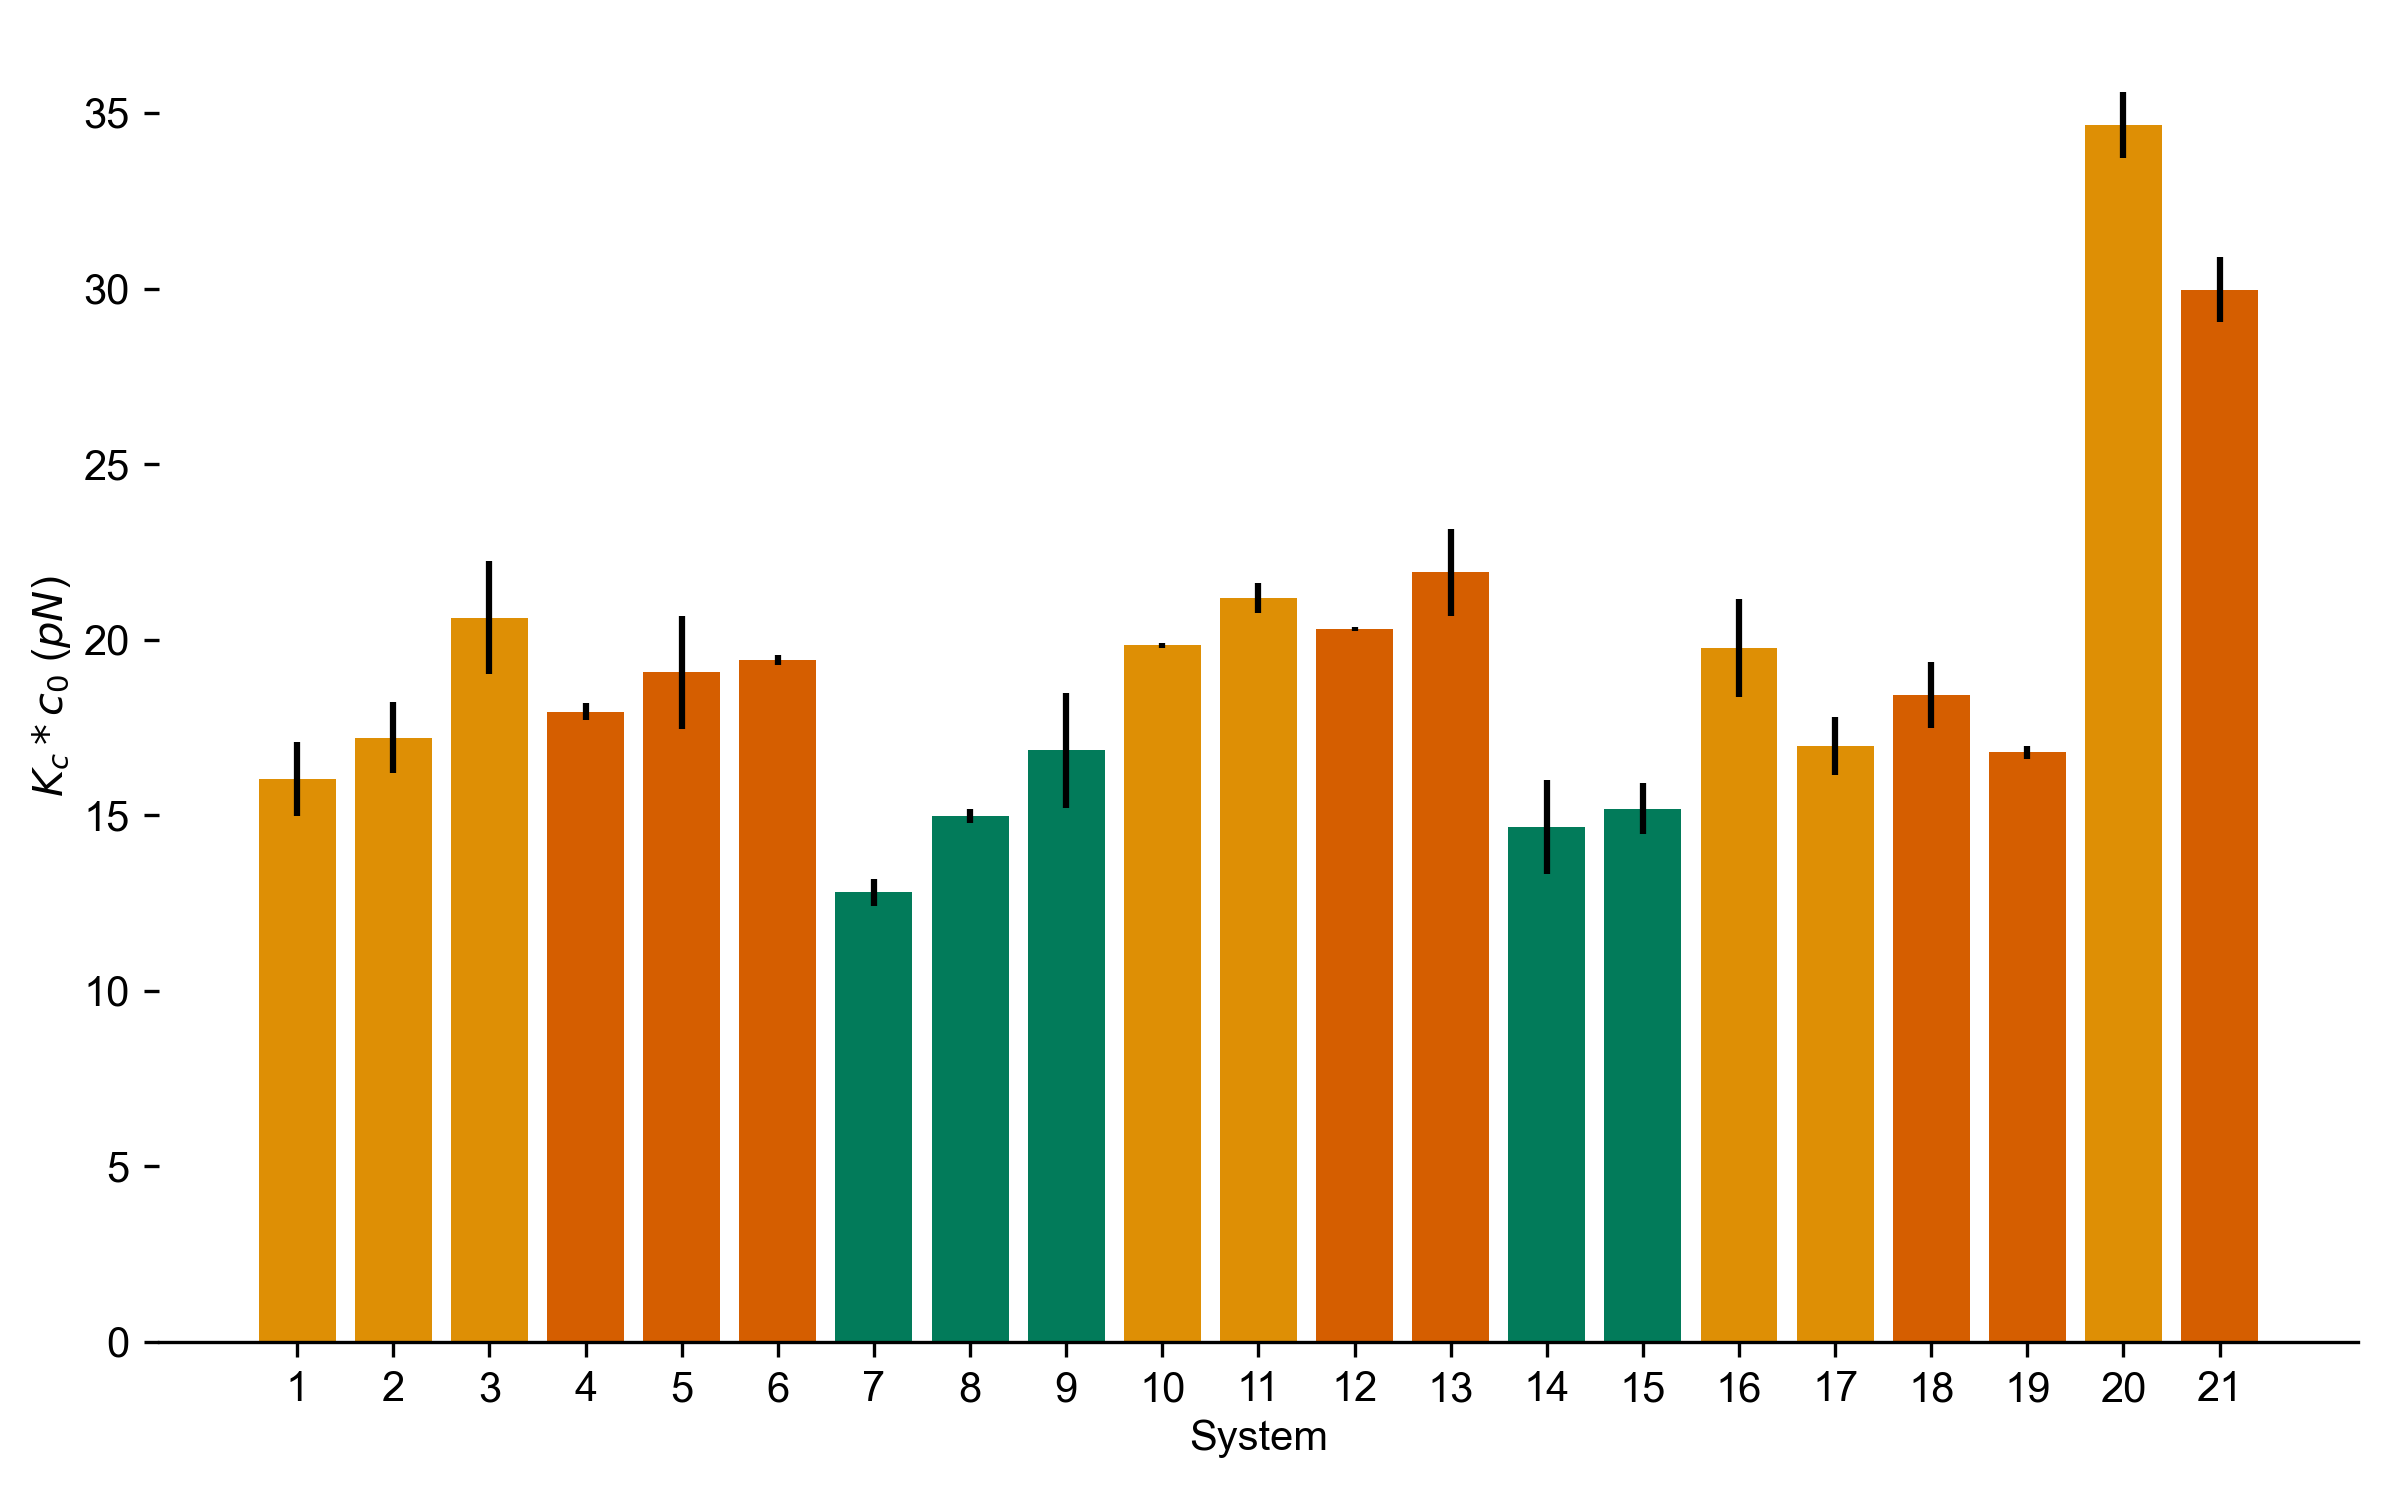

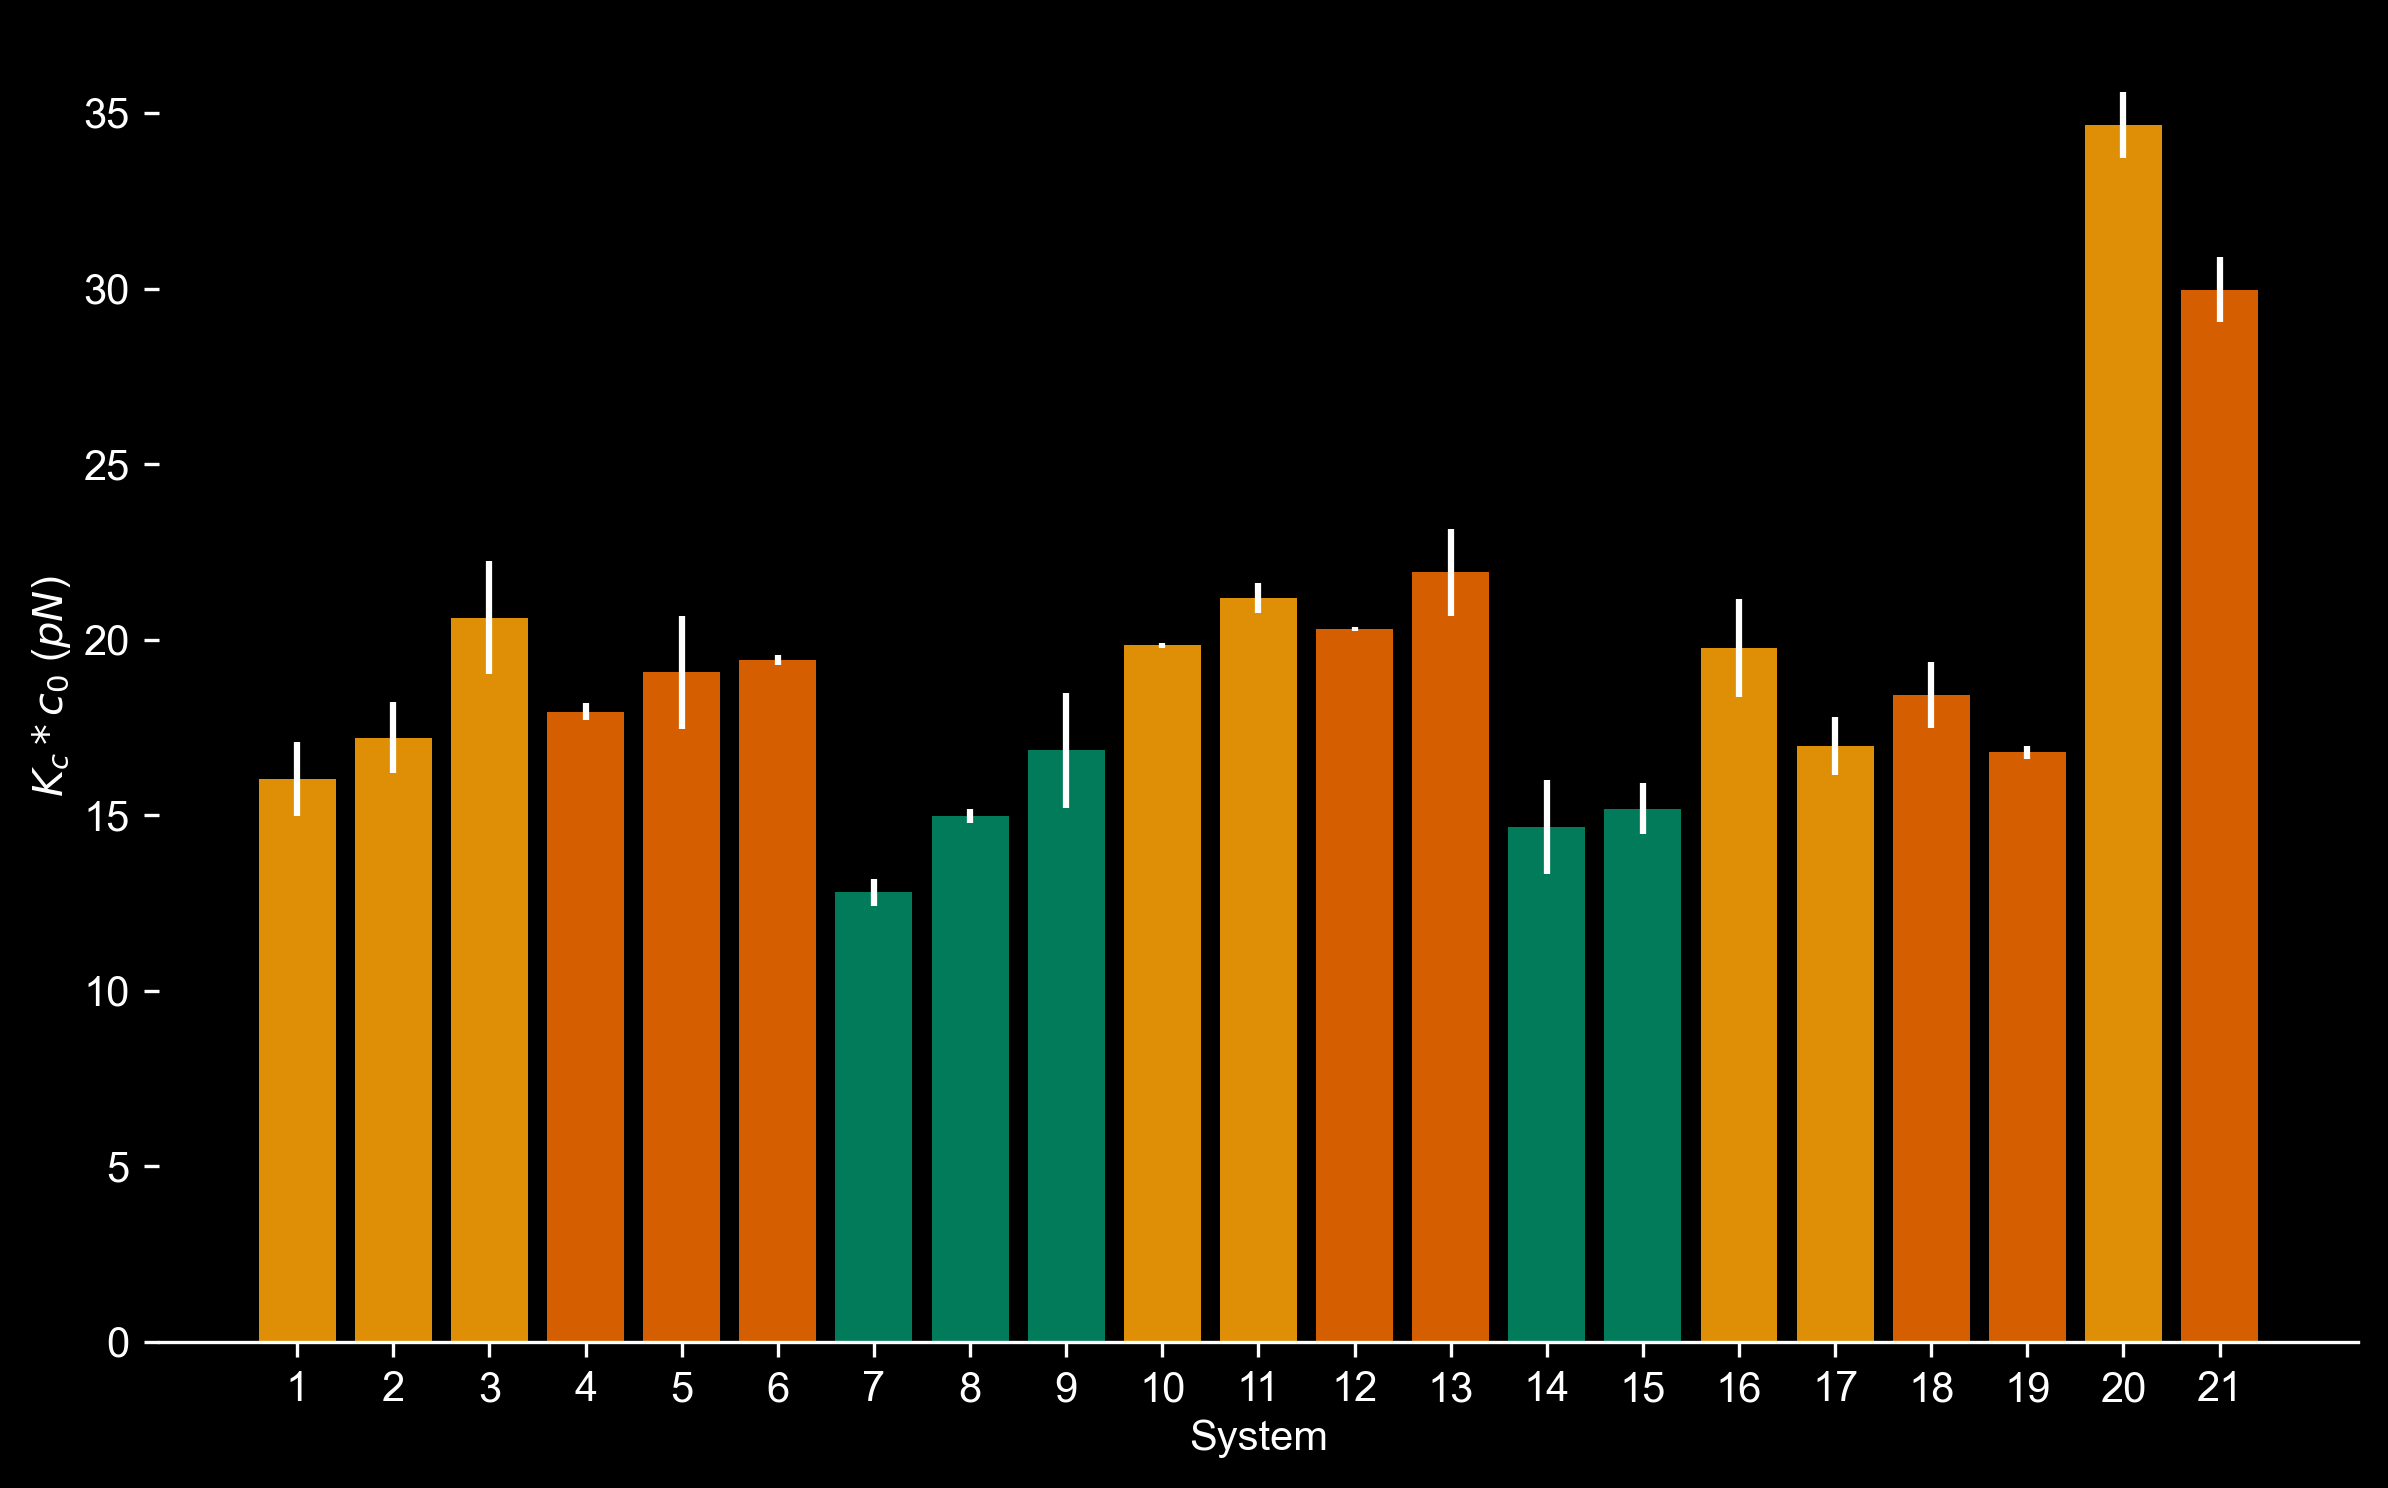

In [15]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(10, 12):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            yerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            yerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_all_vert{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


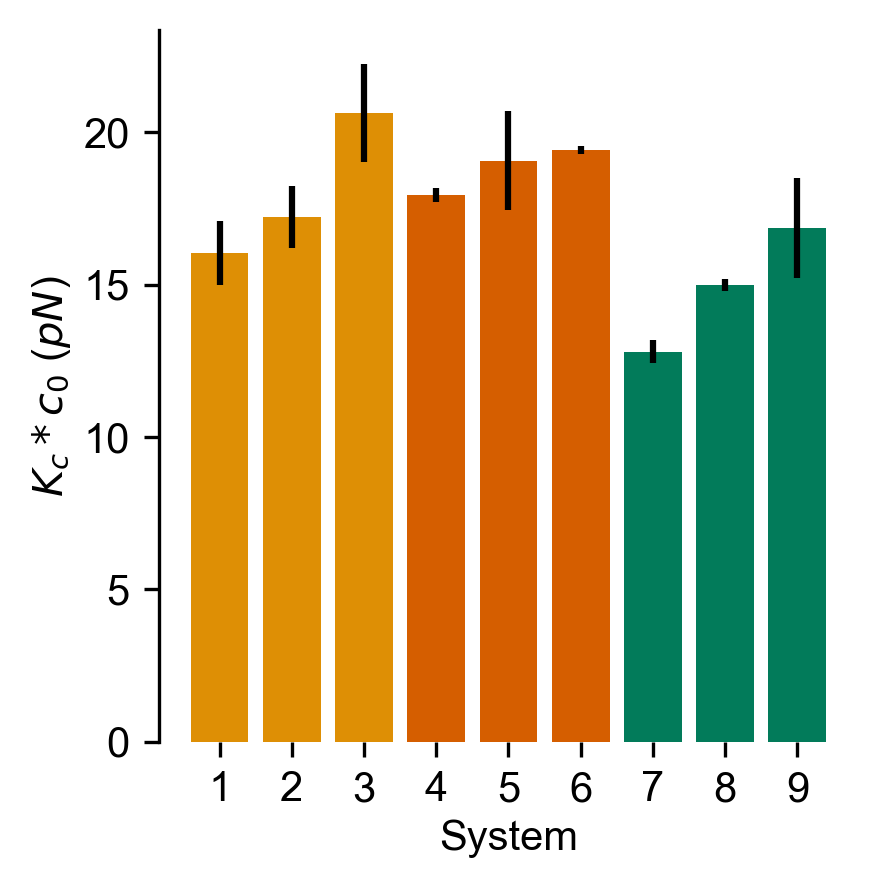

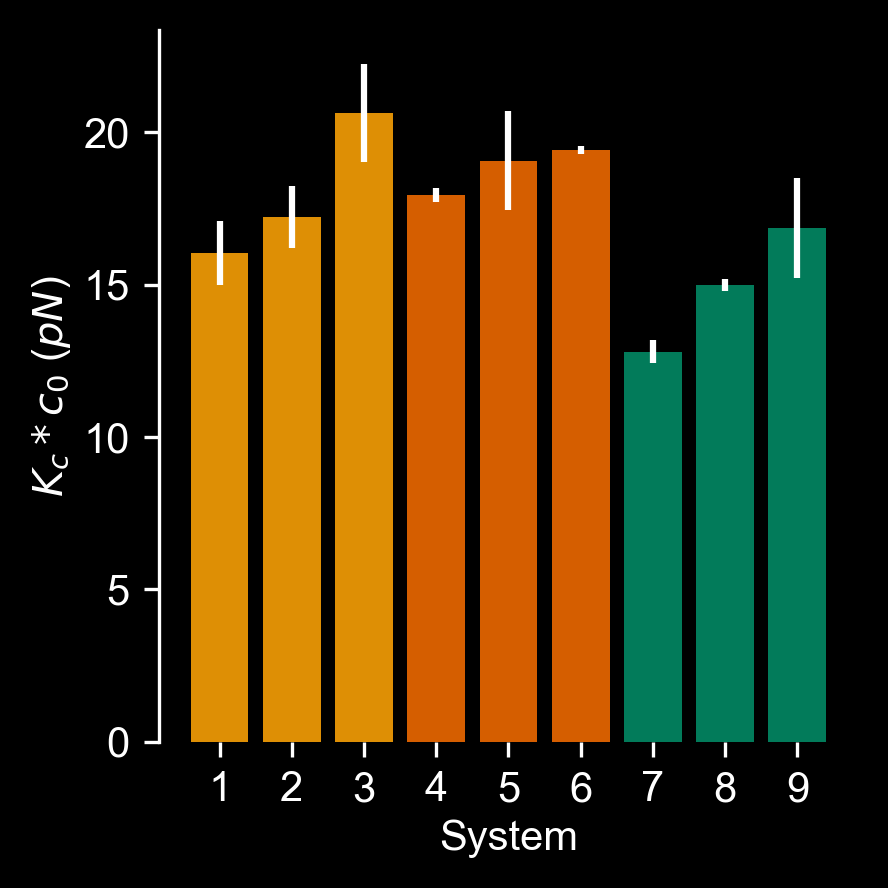

In [16]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(1, 4):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_1-9{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


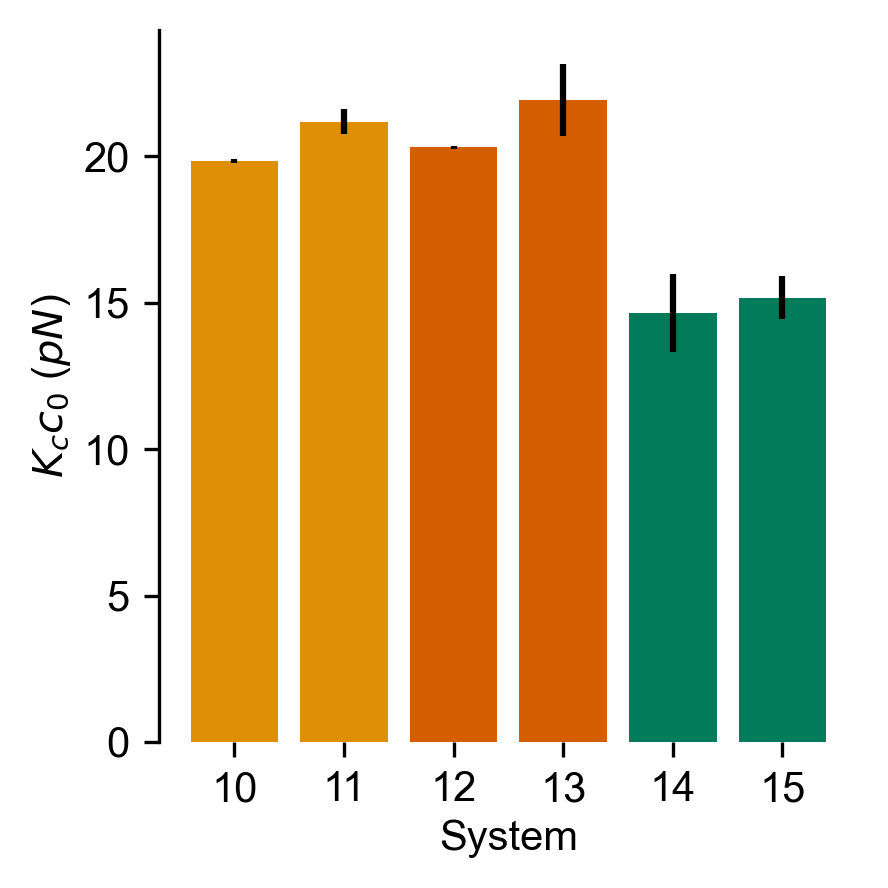

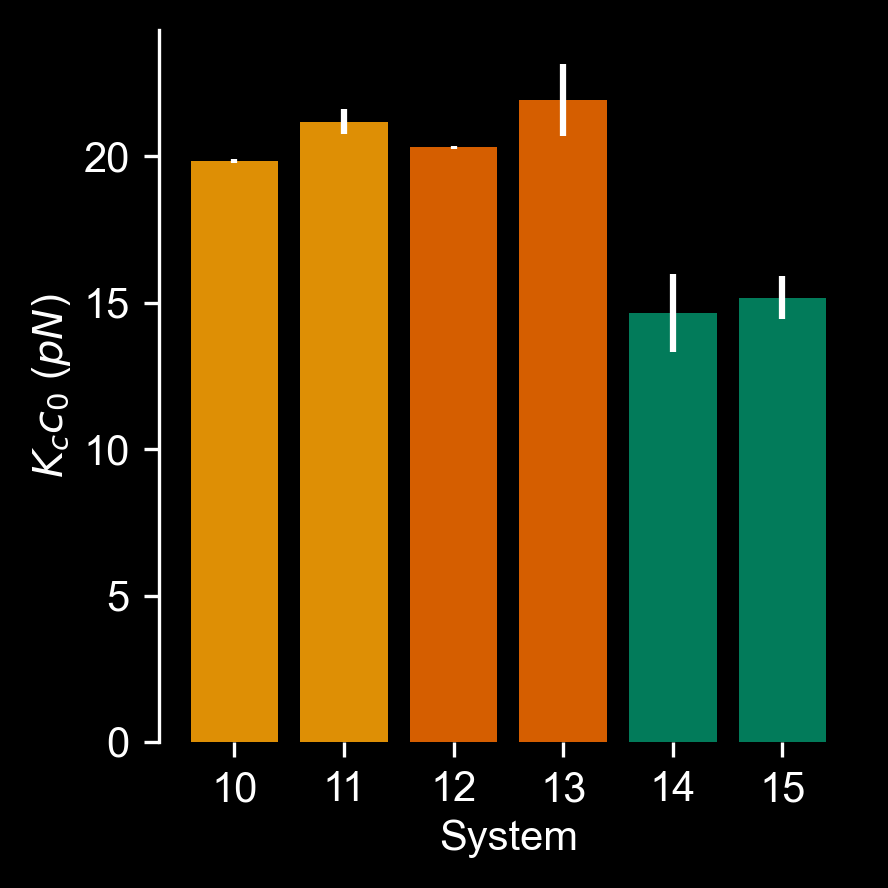

In [17]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(10, 12):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        ax.set_ylabel(r"$K_cc_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig,curr_fig_path / f"first_moment_10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


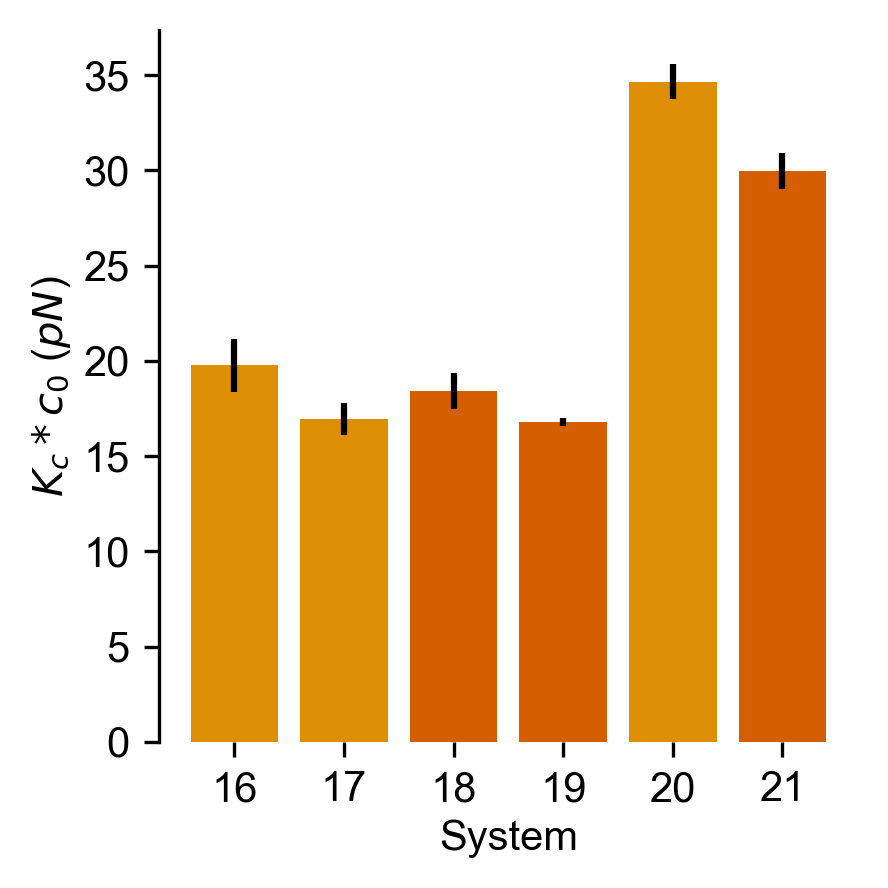

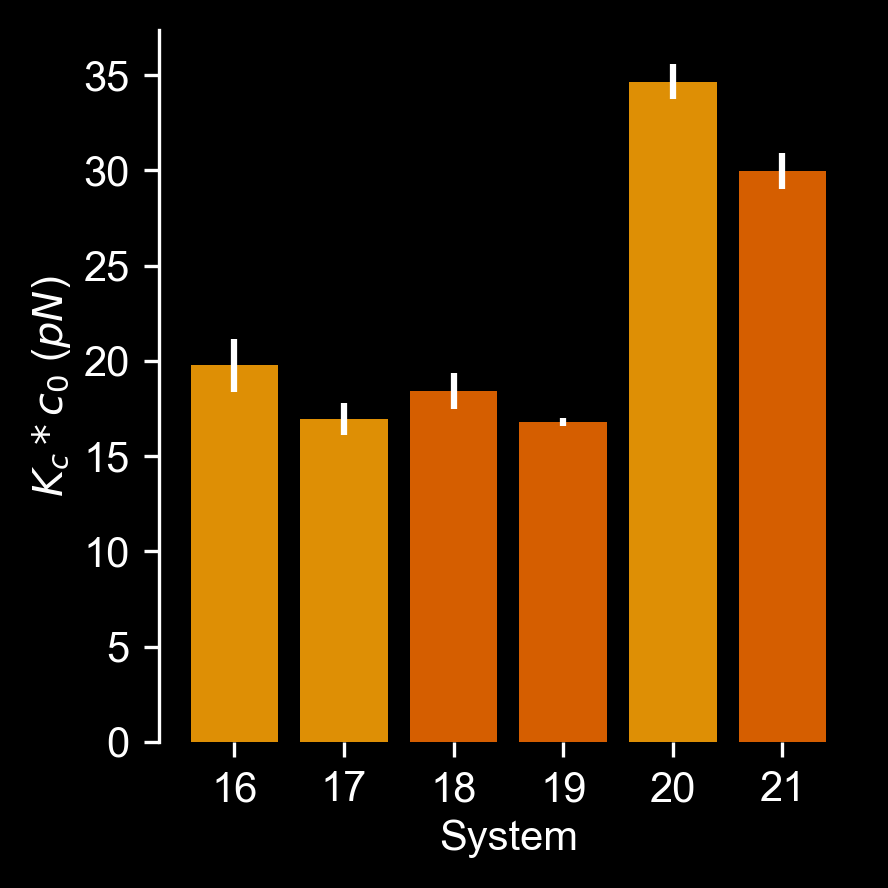

In [18]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(16, 18):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            yerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            yerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_16-21{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


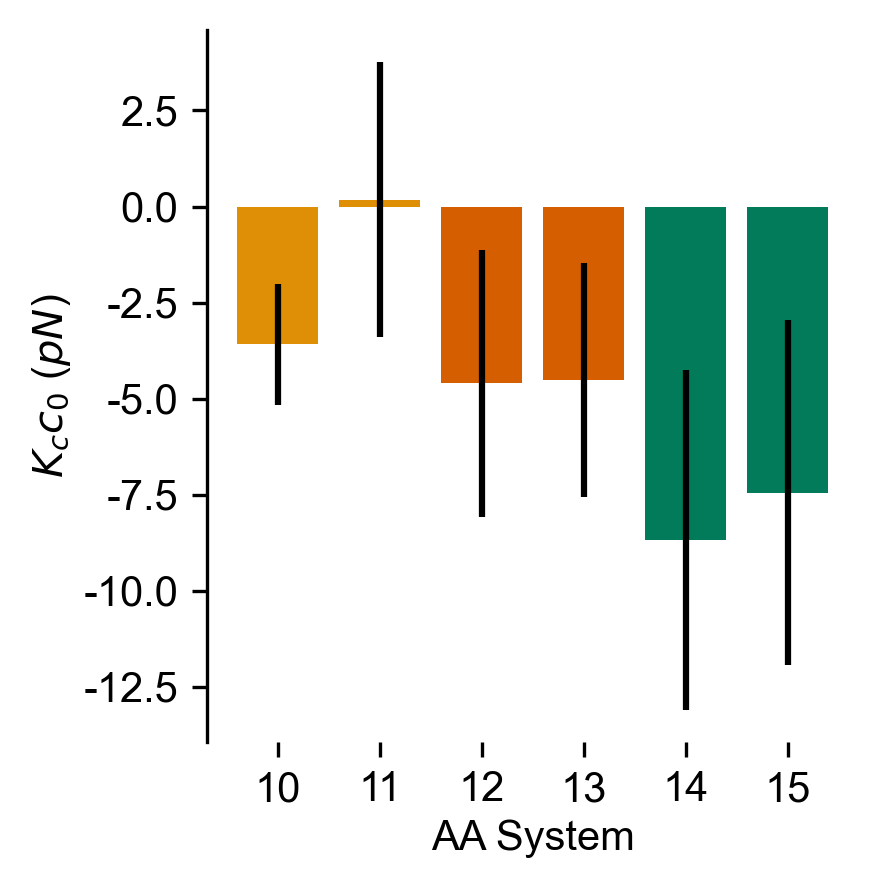

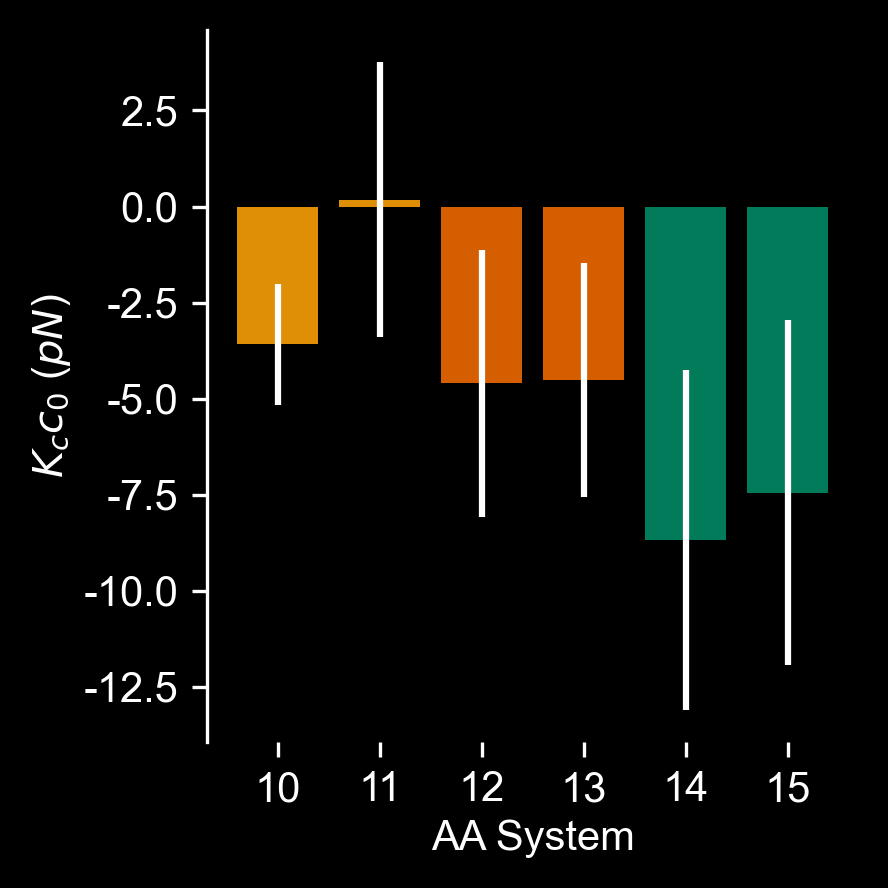

In [19]:
##################
# ATOMISTIC
##################

show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(10, 12):
            ax.bar(
                str(i),
                aa_f_cubic_dat[f"charmm36-sys-{i}"][0],
                yerr=aa_f_cubic_dat[f"charmm36-sys-{i}"][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                aa_f_cubic_dat[f"charmm36-sys-{i}"][0],
                yerr=aa_f_cubic_dat[f"charmm36-sys-{i}"][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                aa_f_cubic_dat[f"charmm36-sys-{i}"][0],
                yerr=aa_f_cubic_dat[f"charmm36-sys-{i}"][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        ax.set_ylabel(r"$K_cc_0$ ($pN$)")
        ax.set_xlabel(r"AA System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig,curr_fig_path / f"aa_first_moment_10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [20]:
for sim in range(1, 22):
    print(
        f"{sim}	{f_cubic_dat[util.remapping_dict[sim]][0]}	{f_cubic_dat[util.remapping_dict[sim]][1]}"
    )


1	16.03286282437595	1.0536865621641713
2	17.20805283906782	1.0175132614673912
3	20.629835253989757	1.607638384357882
4	17.947104297083634	0.23535776490290755
5	19.06476717044786	1.6227410774853286
6	19.416600578312067	0.1434981442766038
7	12.803441878734608	0.38923418458540543
8	14.98270415952958	0.20302097290977134
9	16.85631471842346	1.6368070225401494
10	19.84129800631053	0.07615494354665889
11	21.178758520273263	0.42637541322155437
12	20.312239833515836	0.05191382041136485
13	21.92038363454614	1.2398760893969238
14	14.654925696753708	1.3392816737315514
15	15.180519240533705	0.727955718565714
16	19.76287249559921	1.3931045151921833
17	16.96357984030202	0.8305041742152982
18	18.43516182652797	0.9423628440691832
19	16.791800380990967	0.1916277510501
20	34.65354304080213	0.929306198632866
21	29.962666832461675	0.9233429929144388


In [21]:
kc_mean_std = np.load("kc_mean_std.npy", allow_pickle=True).item()
print(kc_mean_std)
for sim in range(1, 22):
    remapped = util.remapping_dict[sim]
    print(sim, kc_mean_std[remapped])


{1: [9.016962128125954, 0.34297330391244013], 2: [9.02892553280711, 0.29460747779402663], 3: [10.680620266761196, 0.46151385940961154], 4: [19.480801833933, 0.3049435109775883], 5: [19.31927556562415, 0.35134832529197857], 6: [19.614258713934976, 0.3436096601857626], 7: [5.832307600322631, 0.17671360069493391], 8: [7.5365407960793425, 0.2737820834610215], 9: [6.80095913170461, 0.31095032984394516], 10: [22.375849551564553, 0.3061988537109465], 11: [18.140896917462157, 0.2524766007528237], 12: [18.934118004262185, 0.28645932275314967], 13: [8.260342217535664, 0.3917265159413444], 14: [12.077611010196048, 0.32524829252047566], 15: [10.194863428432896, 0.34253885337197376], 16: [12.433006919593222, 0.3323631769066447], 17: [13.03936978945494, 0.3573460670361613], 18: [14.338189588455535, 0.3565183881953765], 19: [13.861570745862096, 0.2832596191276051], 20: [15.060573203231808, 0.3689773661185412], 21: [12.369379198849543, 0.3883929288988268], 22: [10.544144795770869, 0.39250809738659864]

In [22]:
c0 = {}
one_over_c0 = {}
for sim in range(1, 22):
    remapped = util.remapping_dict[sim]
    value = f_cubic_dat[remapped][0] / (kc_mean_std[remapped][0] * 4.18336647)
    error = (
        np.sqrt(
            (f_cubic_dat[remapped][1] / f_cubic_dat[remapped][0]) ** 2
            + (kc_mean_std[remapped][1] / kc_mean_std[remapped][0]) ** 2
        )
        * value
    )

    c0[sim] = (value, error)

    one_over_c0[sim] = (1 / value, error / value / value)

    print(
        f"System {sim} c0: {value: 0.3f} +/- {error:0.3f} nm^-1; {1 / value} +/- {error/value/value} nm"
    )


System 1 c0:  0.425 +/- 0.032 nm^-1; 2.3527461964379524 +/- 0.17865302833253838 nm
System 2 c0:  0.456 +/- 0.031 nm^-1; 2.1949784026882537 +/- 0.14823882730649032 nm
System 3 c0:  0.484 +/- 0.041 nm^-1; 2.0673383625052093 +/- 0.17543958768148912 nm
System 4 c0:  0.345 +/- 0.010 nm^-1; 2.898062183611207 +/- 0.08629188102353708 nm
System 5 c0:  0.350 +/- 0.031 nm^-1; 2.8612183867470407 +/- 0.2558510686888526 nm
System 6 c0:  0.339 +/- 0.010 nm^-1; 2.9459669137141113 +/- 0.08305223815975256 nm
System 7 c0:  0.157 +/- 0.005 nm^-1; 6.365111348390344 +/- 0.21764945852875184 nm
System 8 c0:  0.185 +/- 0.004 nm^-1; 5.394193782737006 +/- 0.12233738516522691 nm
System 9 c0:  0.213 +/- 0.021 nm^-1; 4.6990315333565364 +/- 0.4617974975159949 nm
System 10 c0:  0.697 +/- 0.032 nm^-1; 1.4339235460484772 +/- 0.06579179844477853 nm
System 11 c0:  0.672 +/- 0.028 nm^-1; 1.4886666768462984 +/- 0.061828577646992254 nm
System 12 c0:  0.393 +/- 0.012 nm^-1; 2.547510595547454 +/- 0.08025522636881237 nm
System

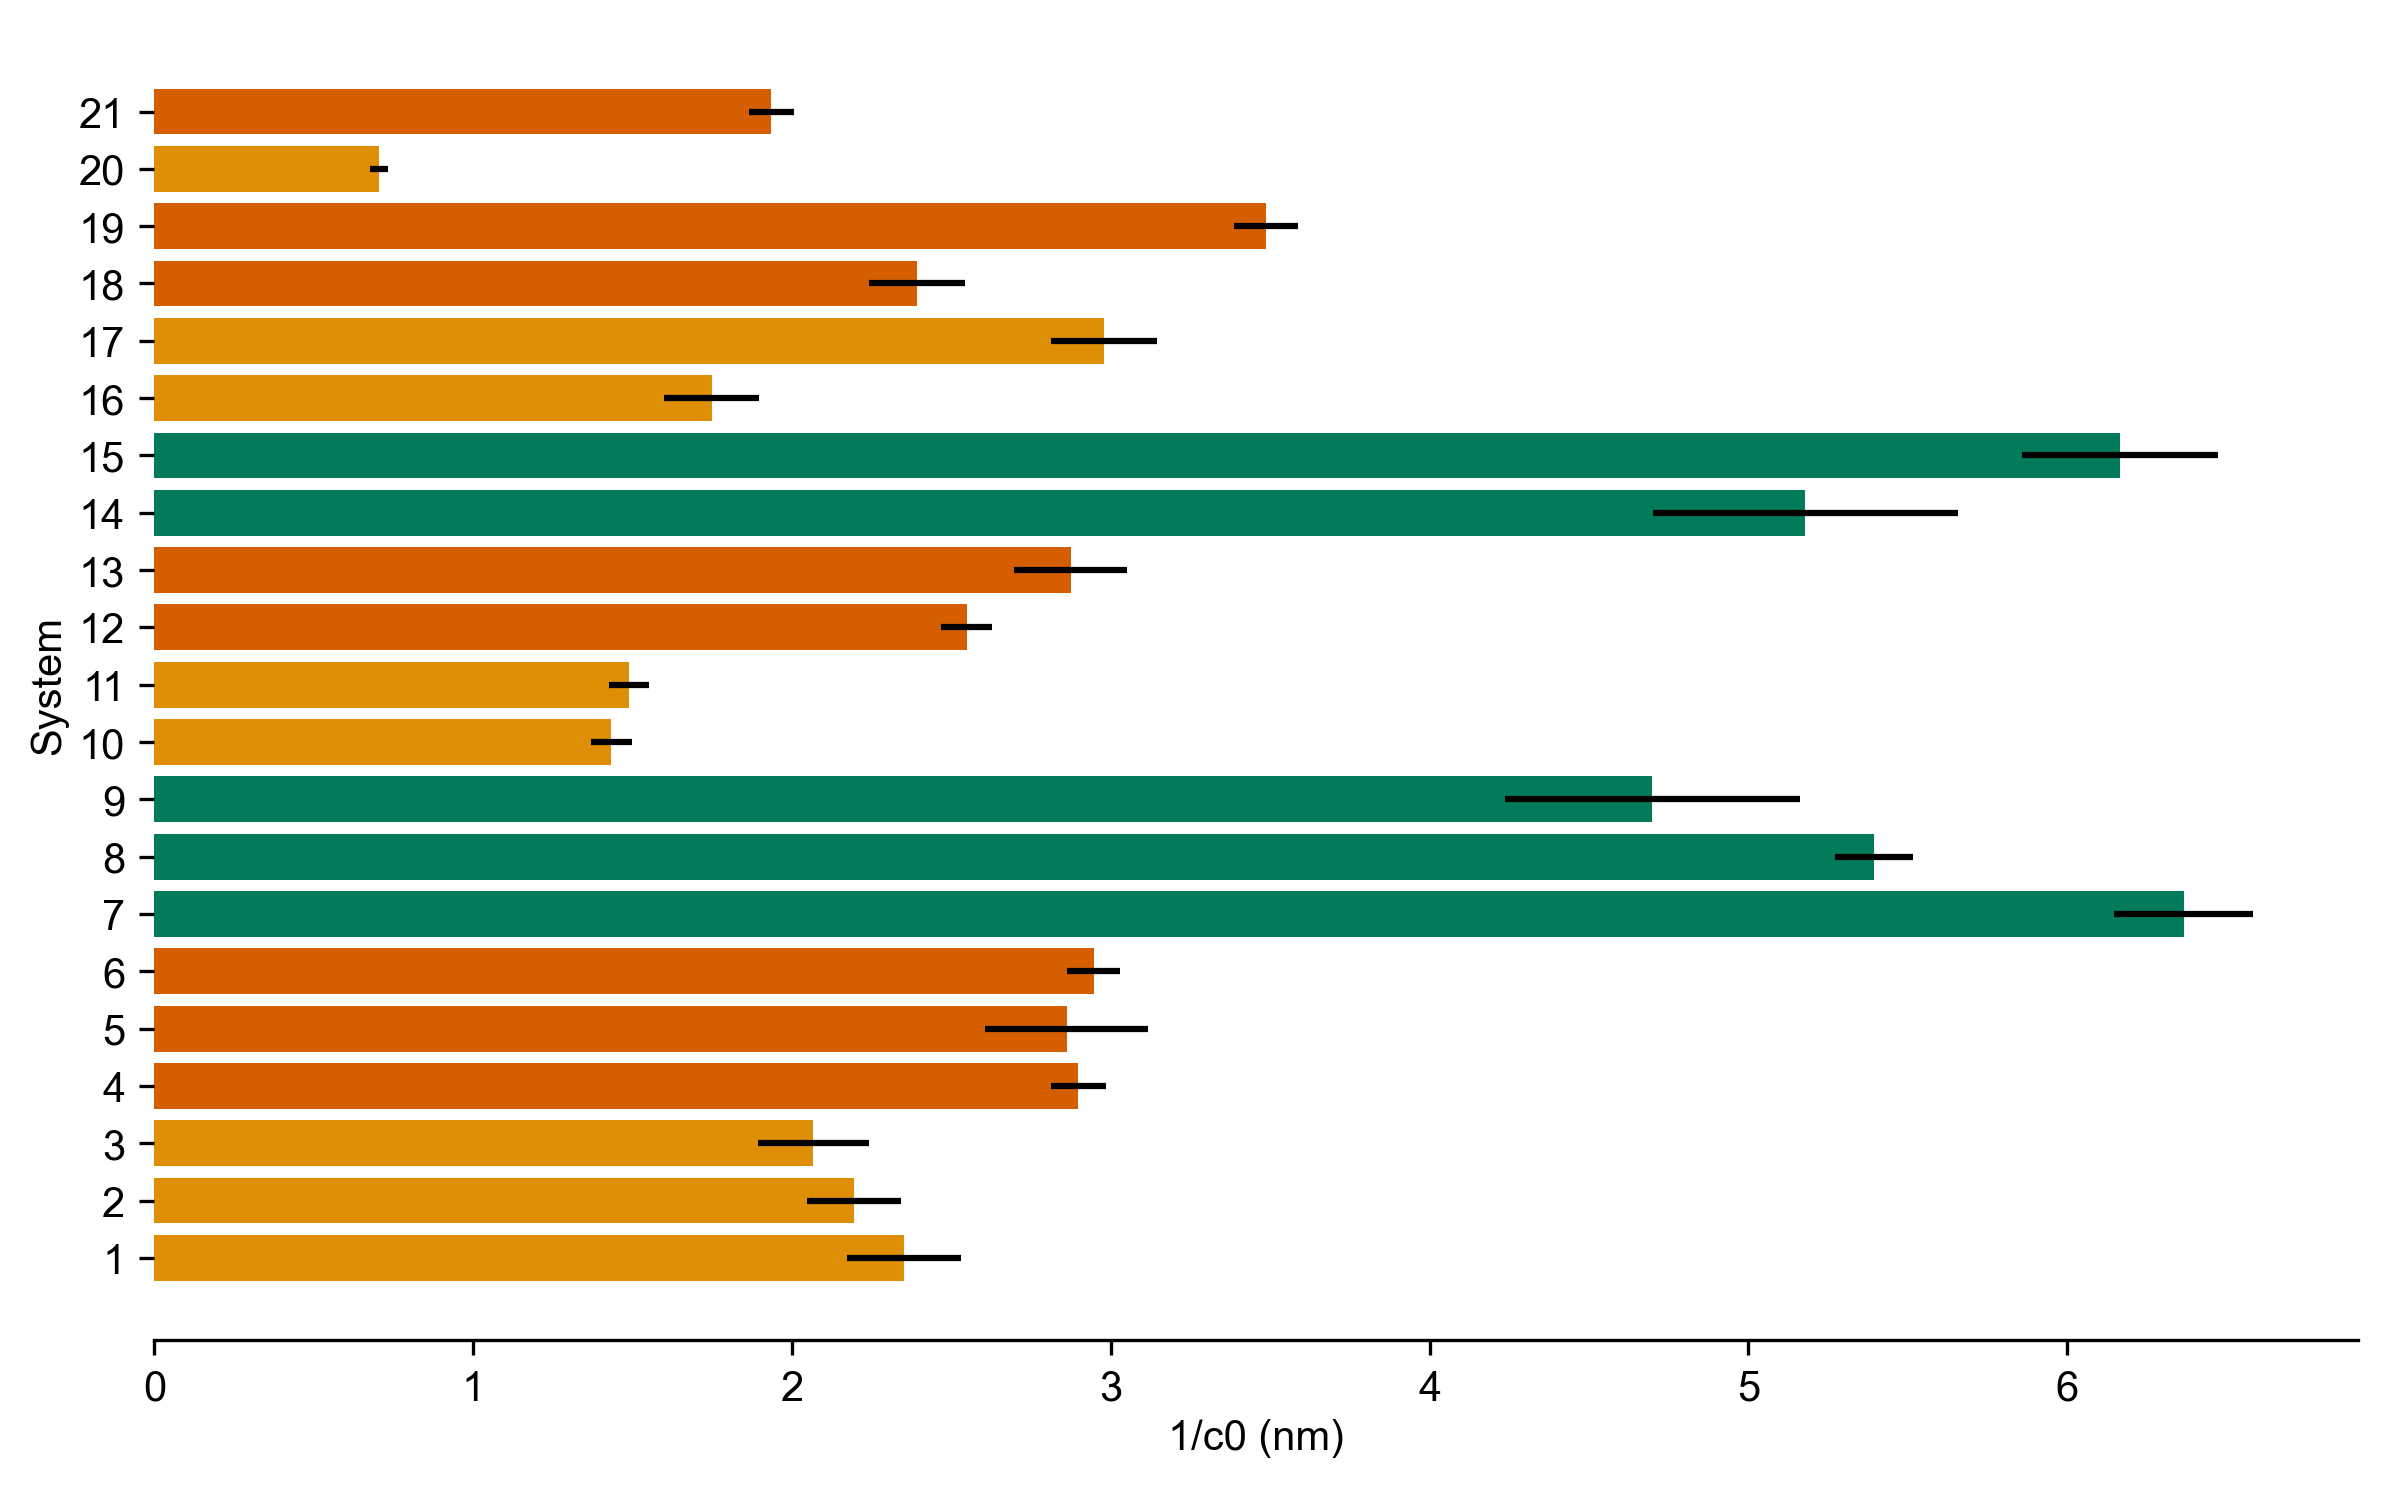

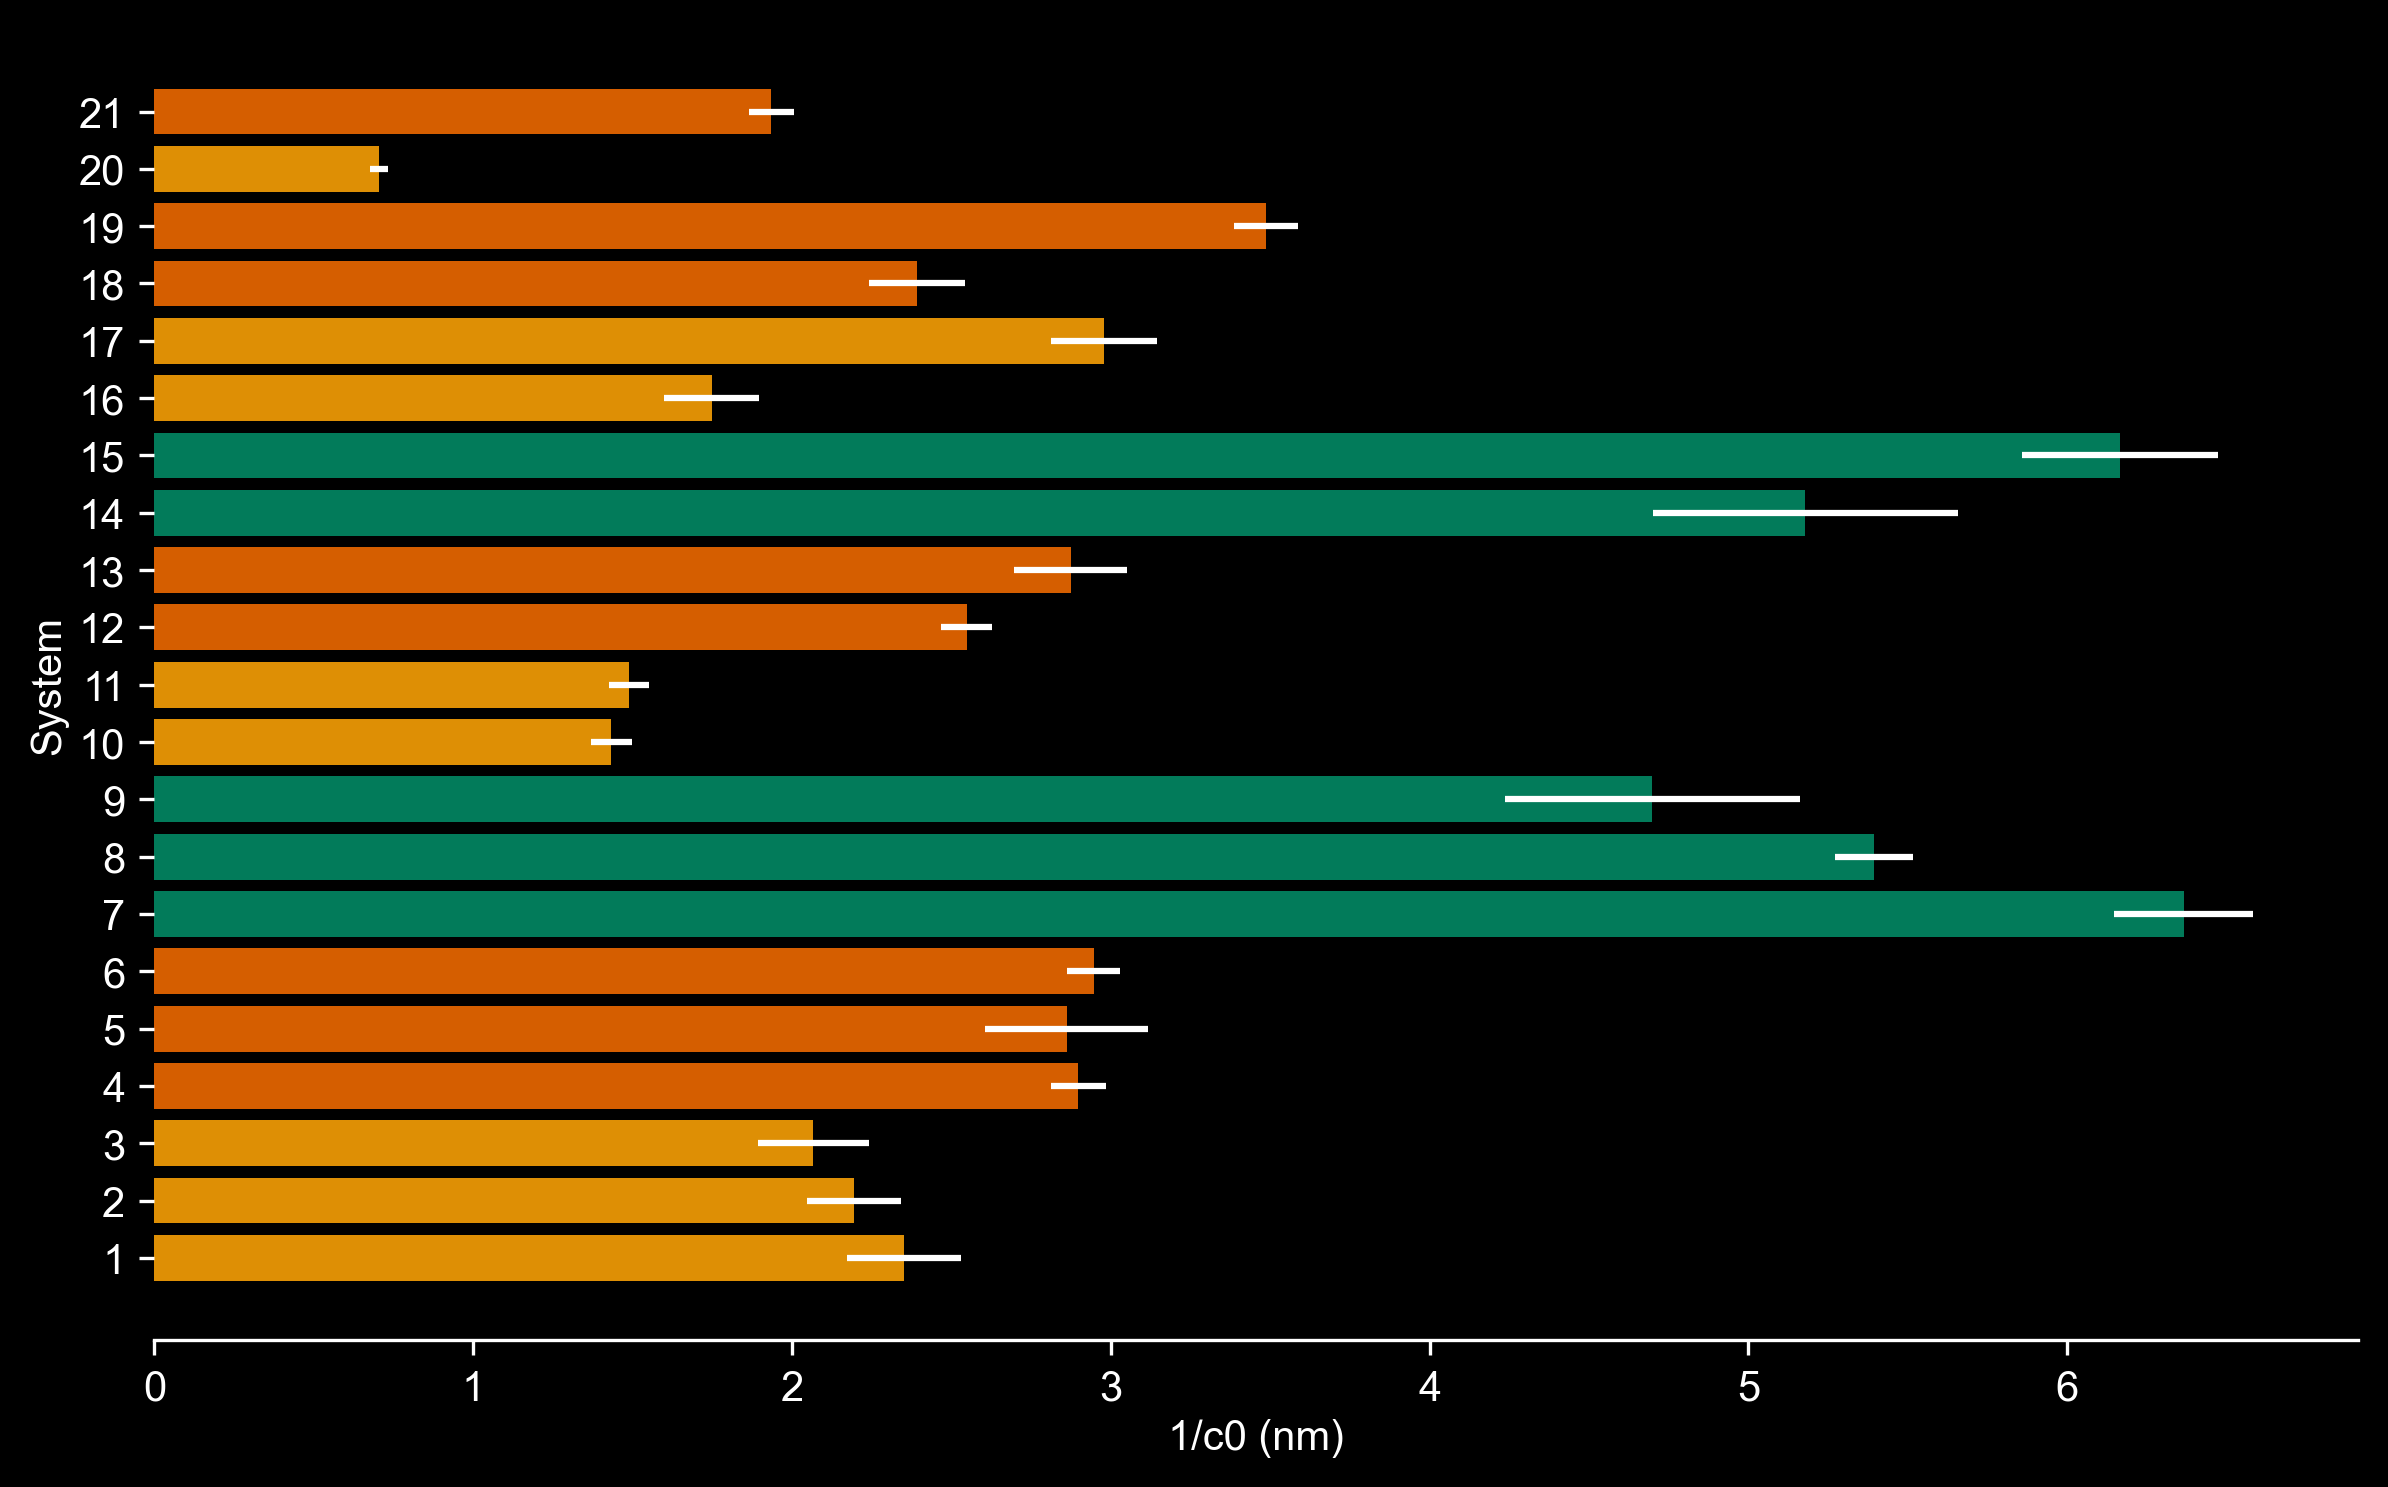

In [23]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(4, 7):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(12, 14):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(16, 18):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(18, 20):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        ax.barh(
            "20", one_over_c0[20][0], xerr=one_over_c0[20][1], color=pal[1], ecolor=ecolor,height=0.8
        )

        ax.barh(
            "21", one_over_c0[21][0], xerr=one_over_c0[21][1], color=pal[3], ecolor=ecolor,height=0.8
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"1/c0 (nm)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature{style_ext}")
        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


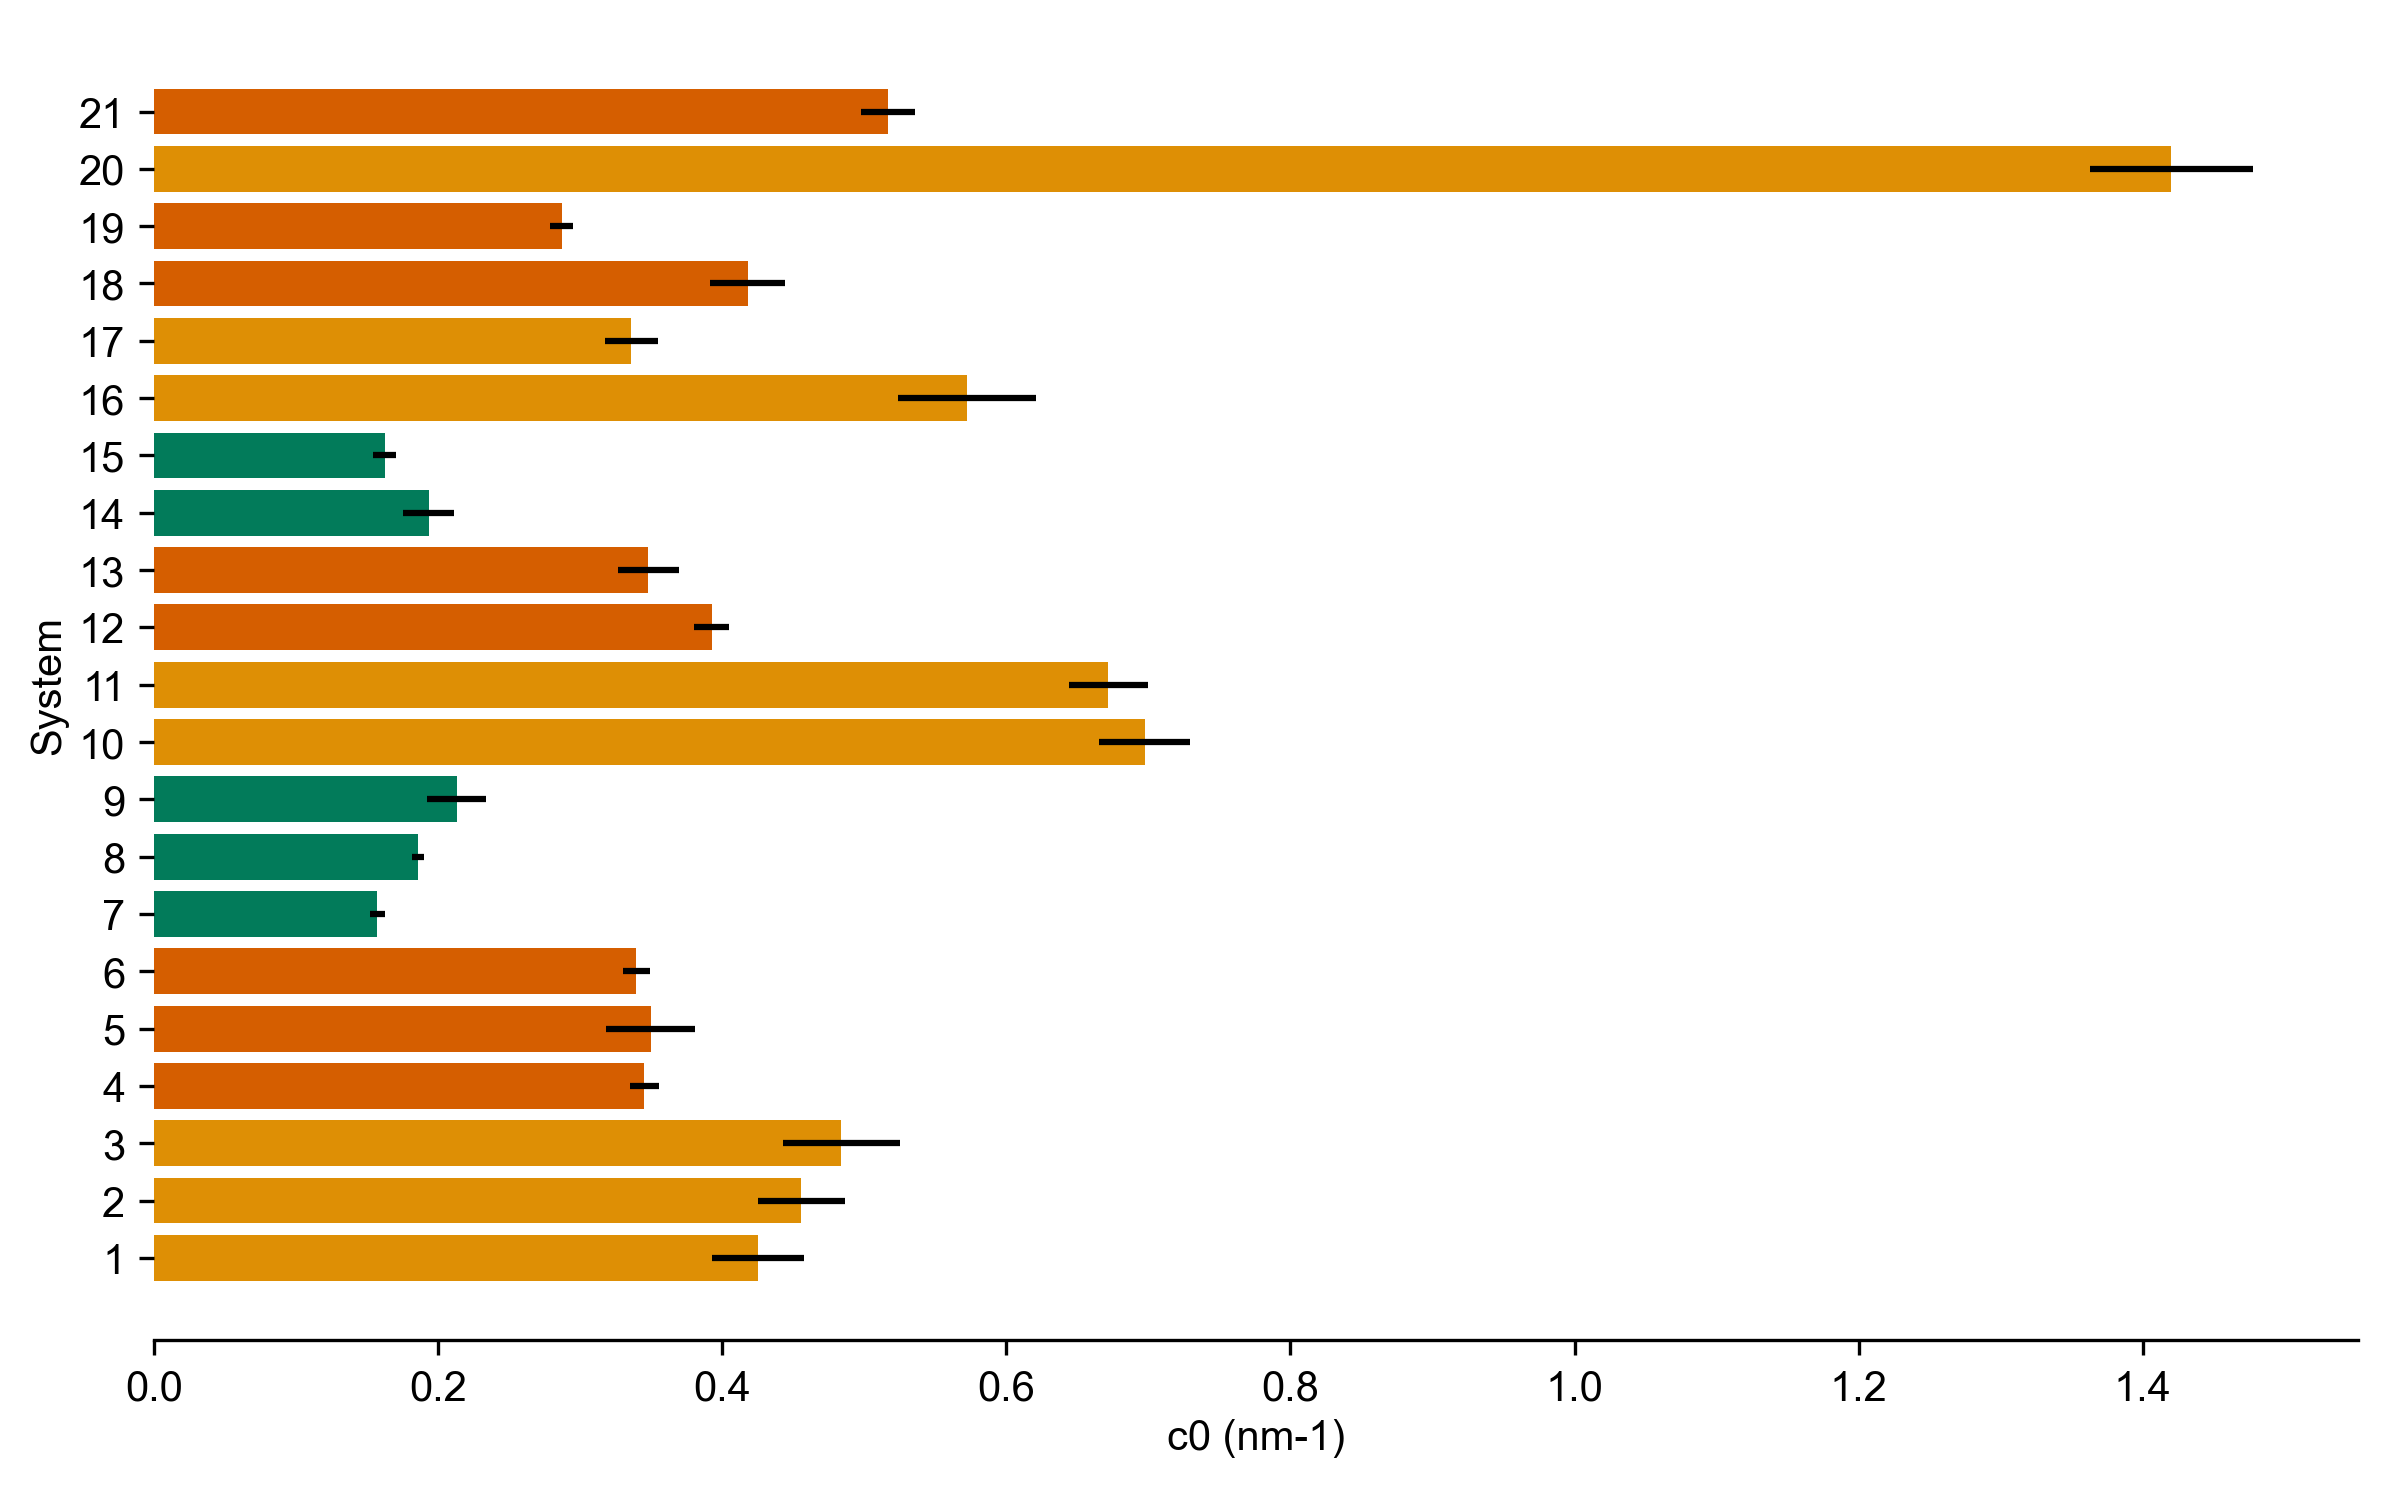

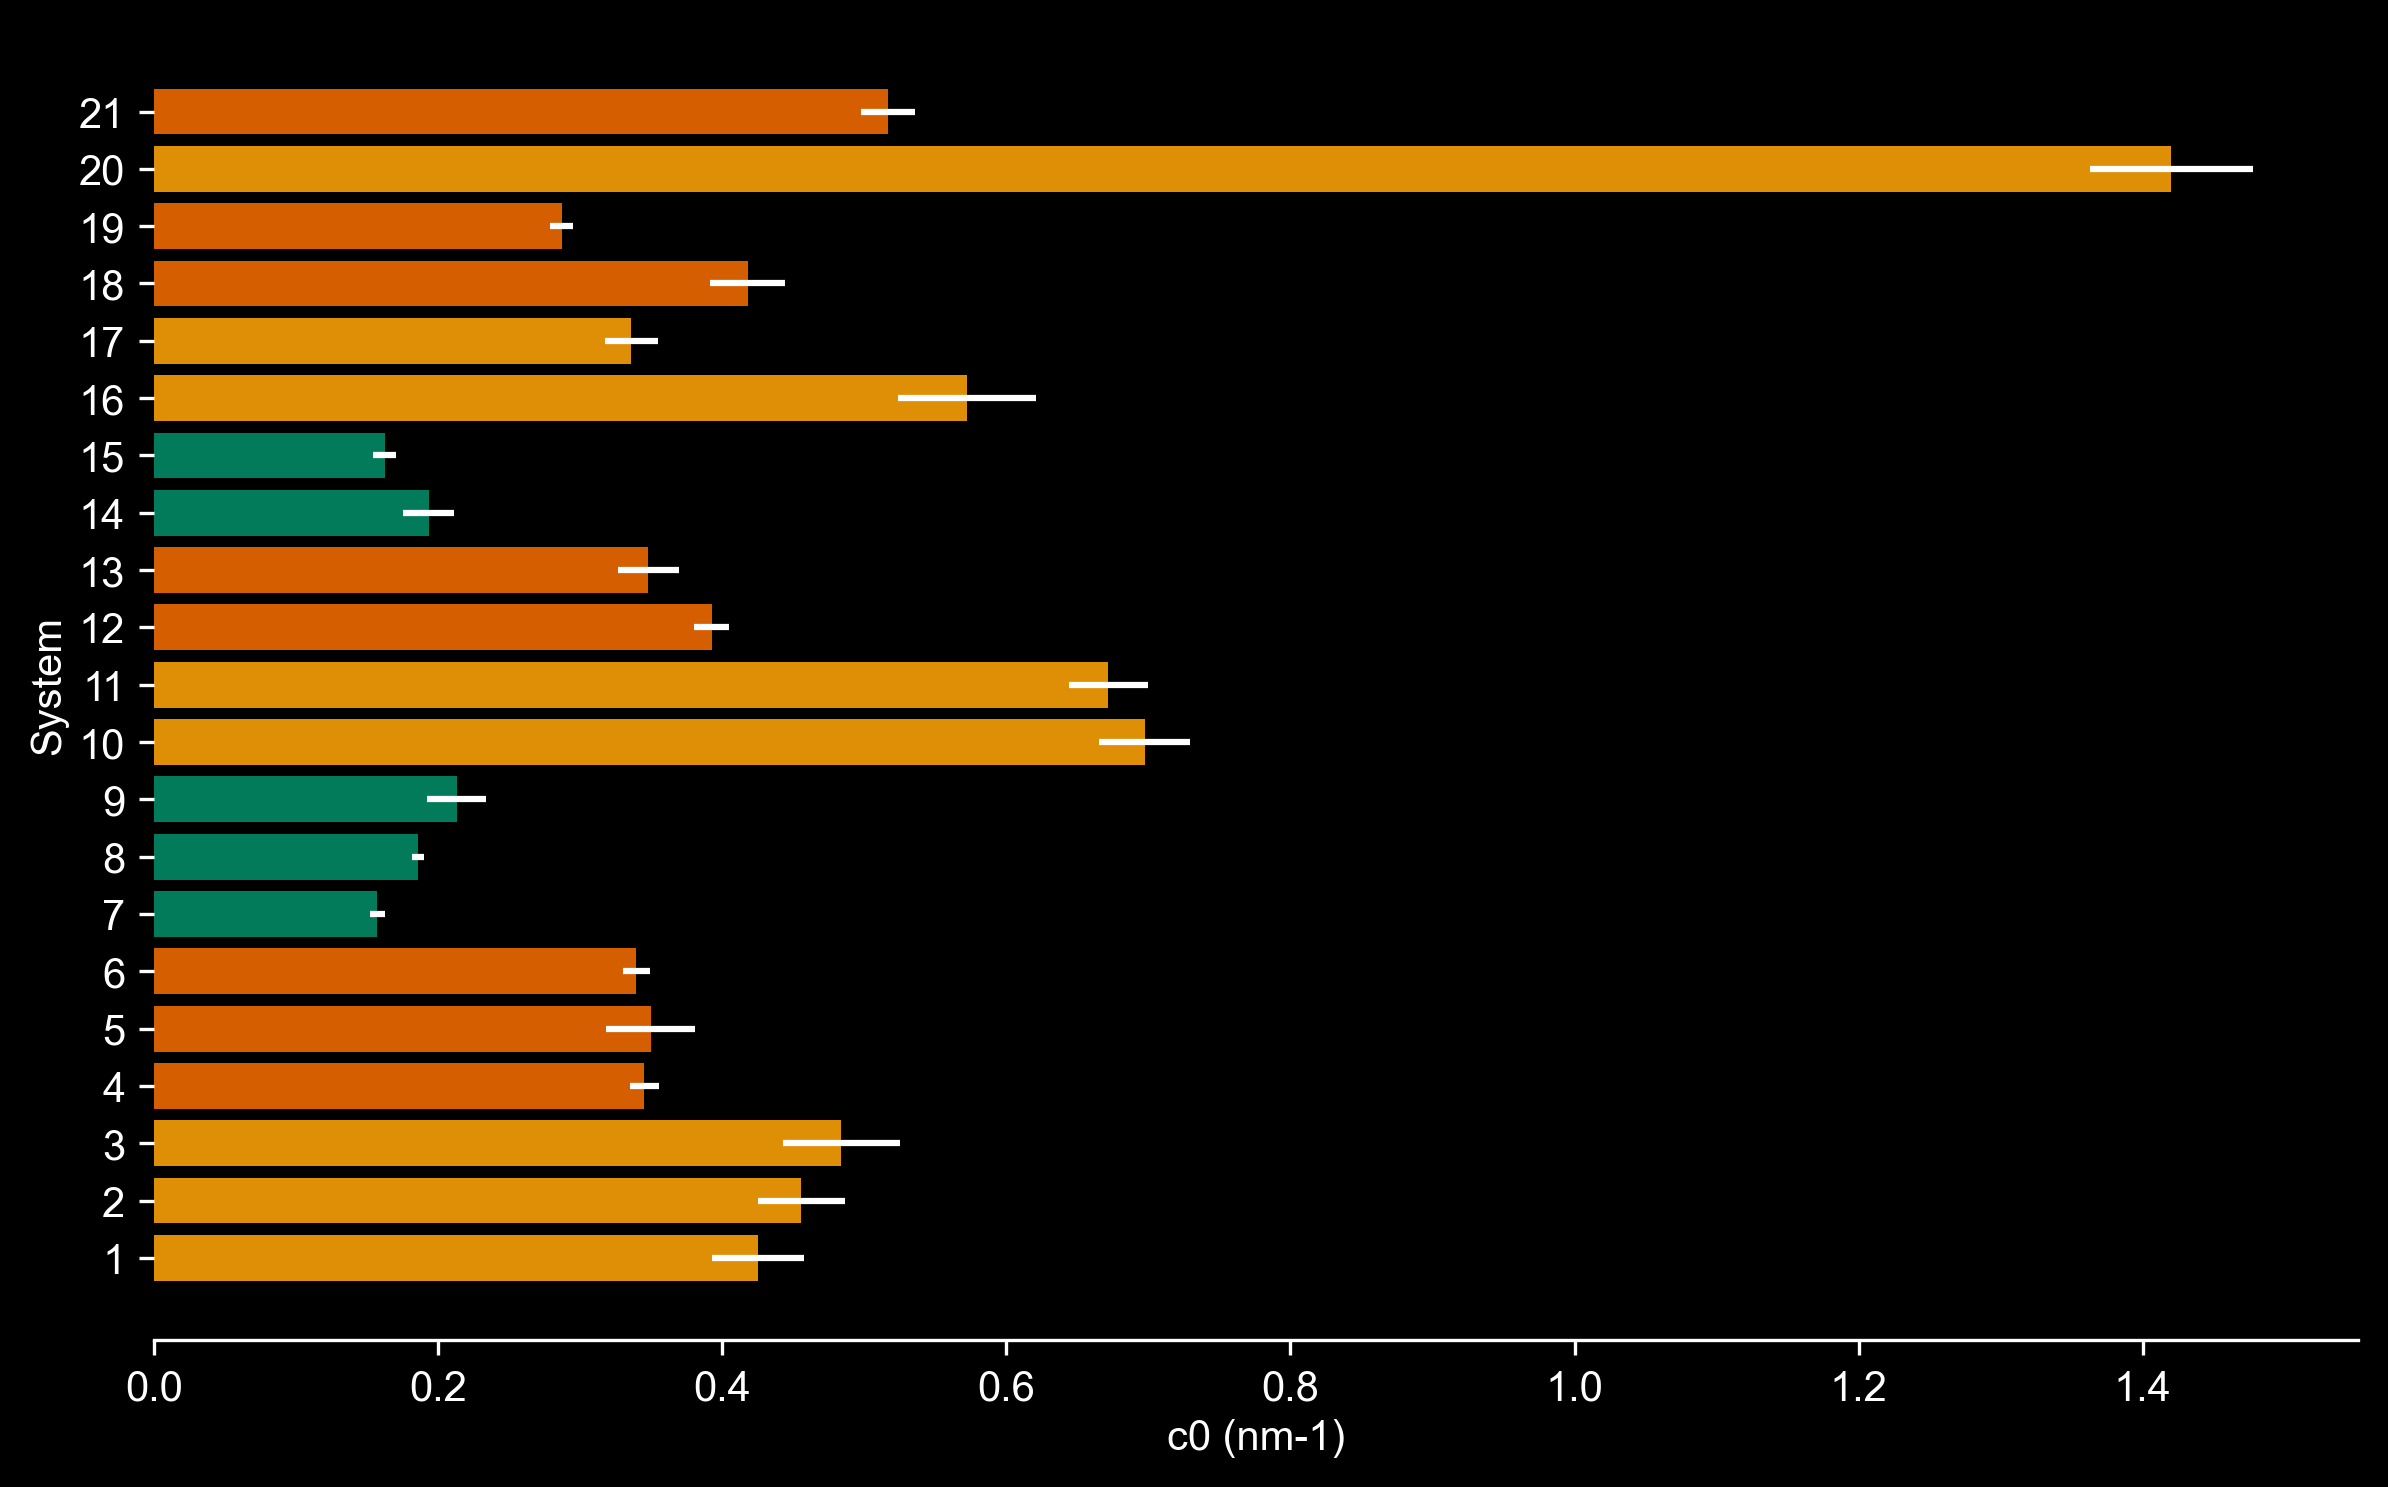

In [24]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(4, 7):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                c0[i][0],
                xerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(12, 14):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                c0[i][0],
                xerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                height=0.8,
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(18, 20):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        ax.barh(
            "20", c0[20][0], xerr=c0[20][1], color=pal[1], ecolor=ecolor, height=0.8
        )

        ax.barh(
            "21", c0[21][0], xerr=c0[21][1], color=pal[3], ecolor=ecolor, height=0.8
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"c0 (nm-1)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


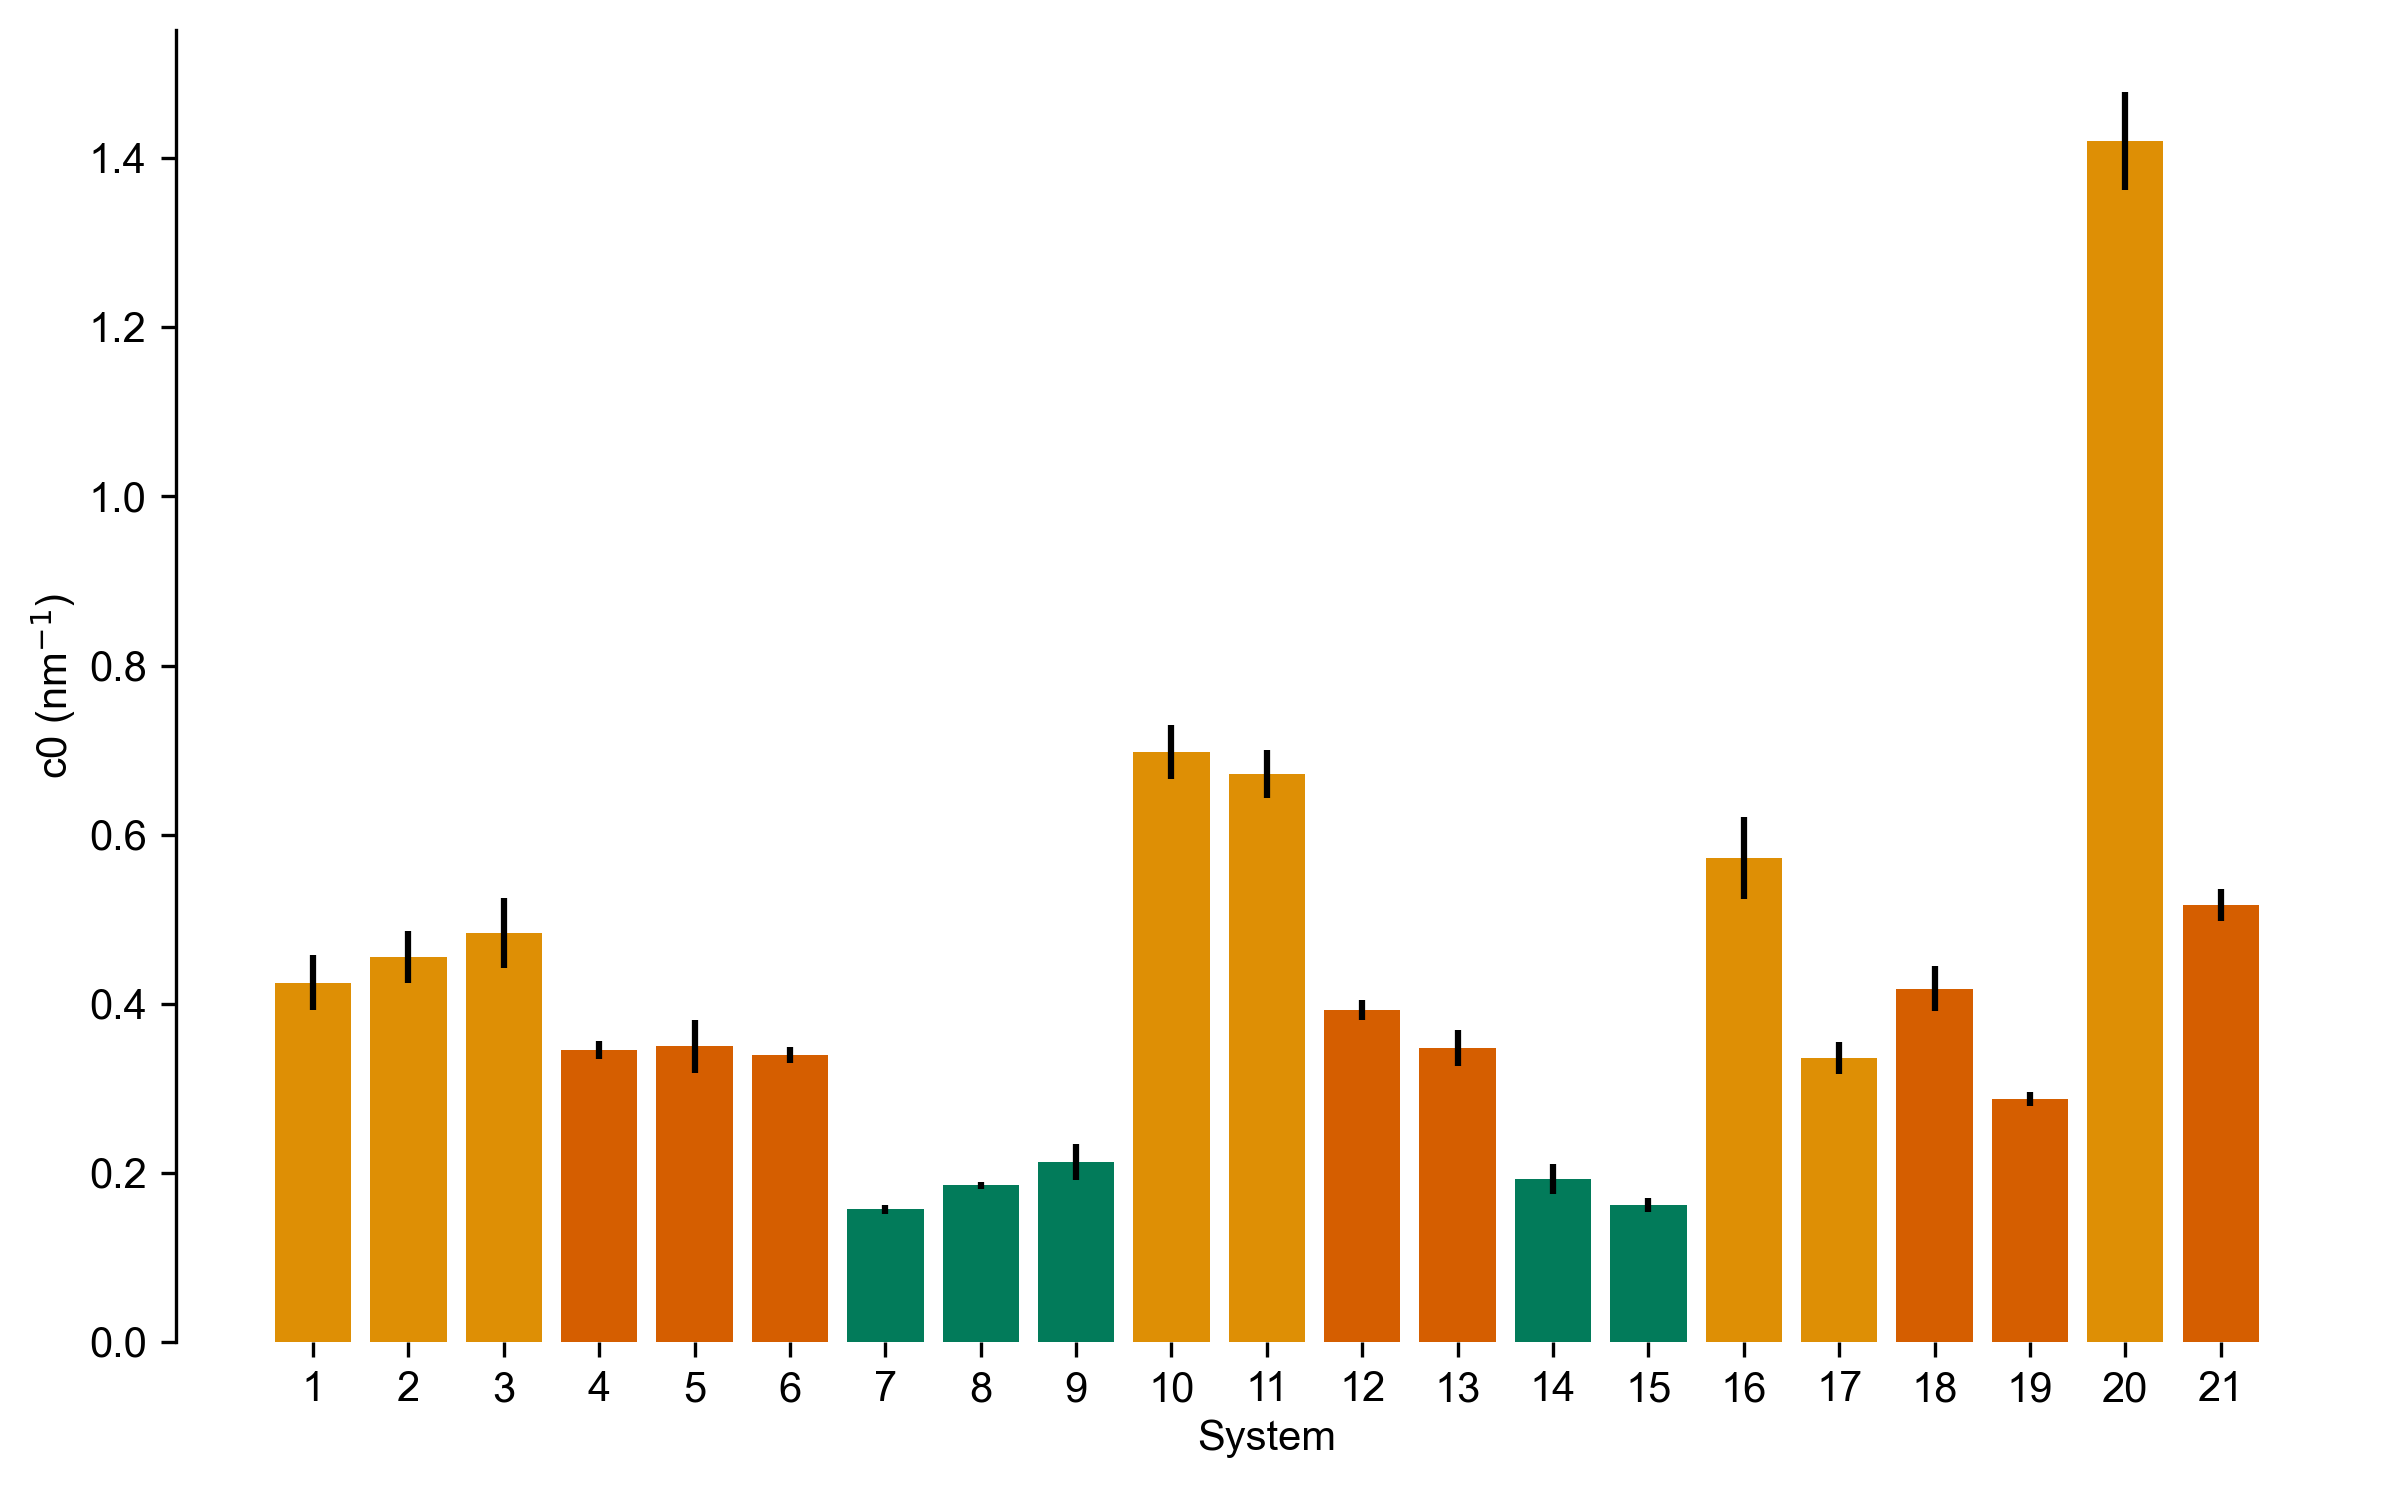

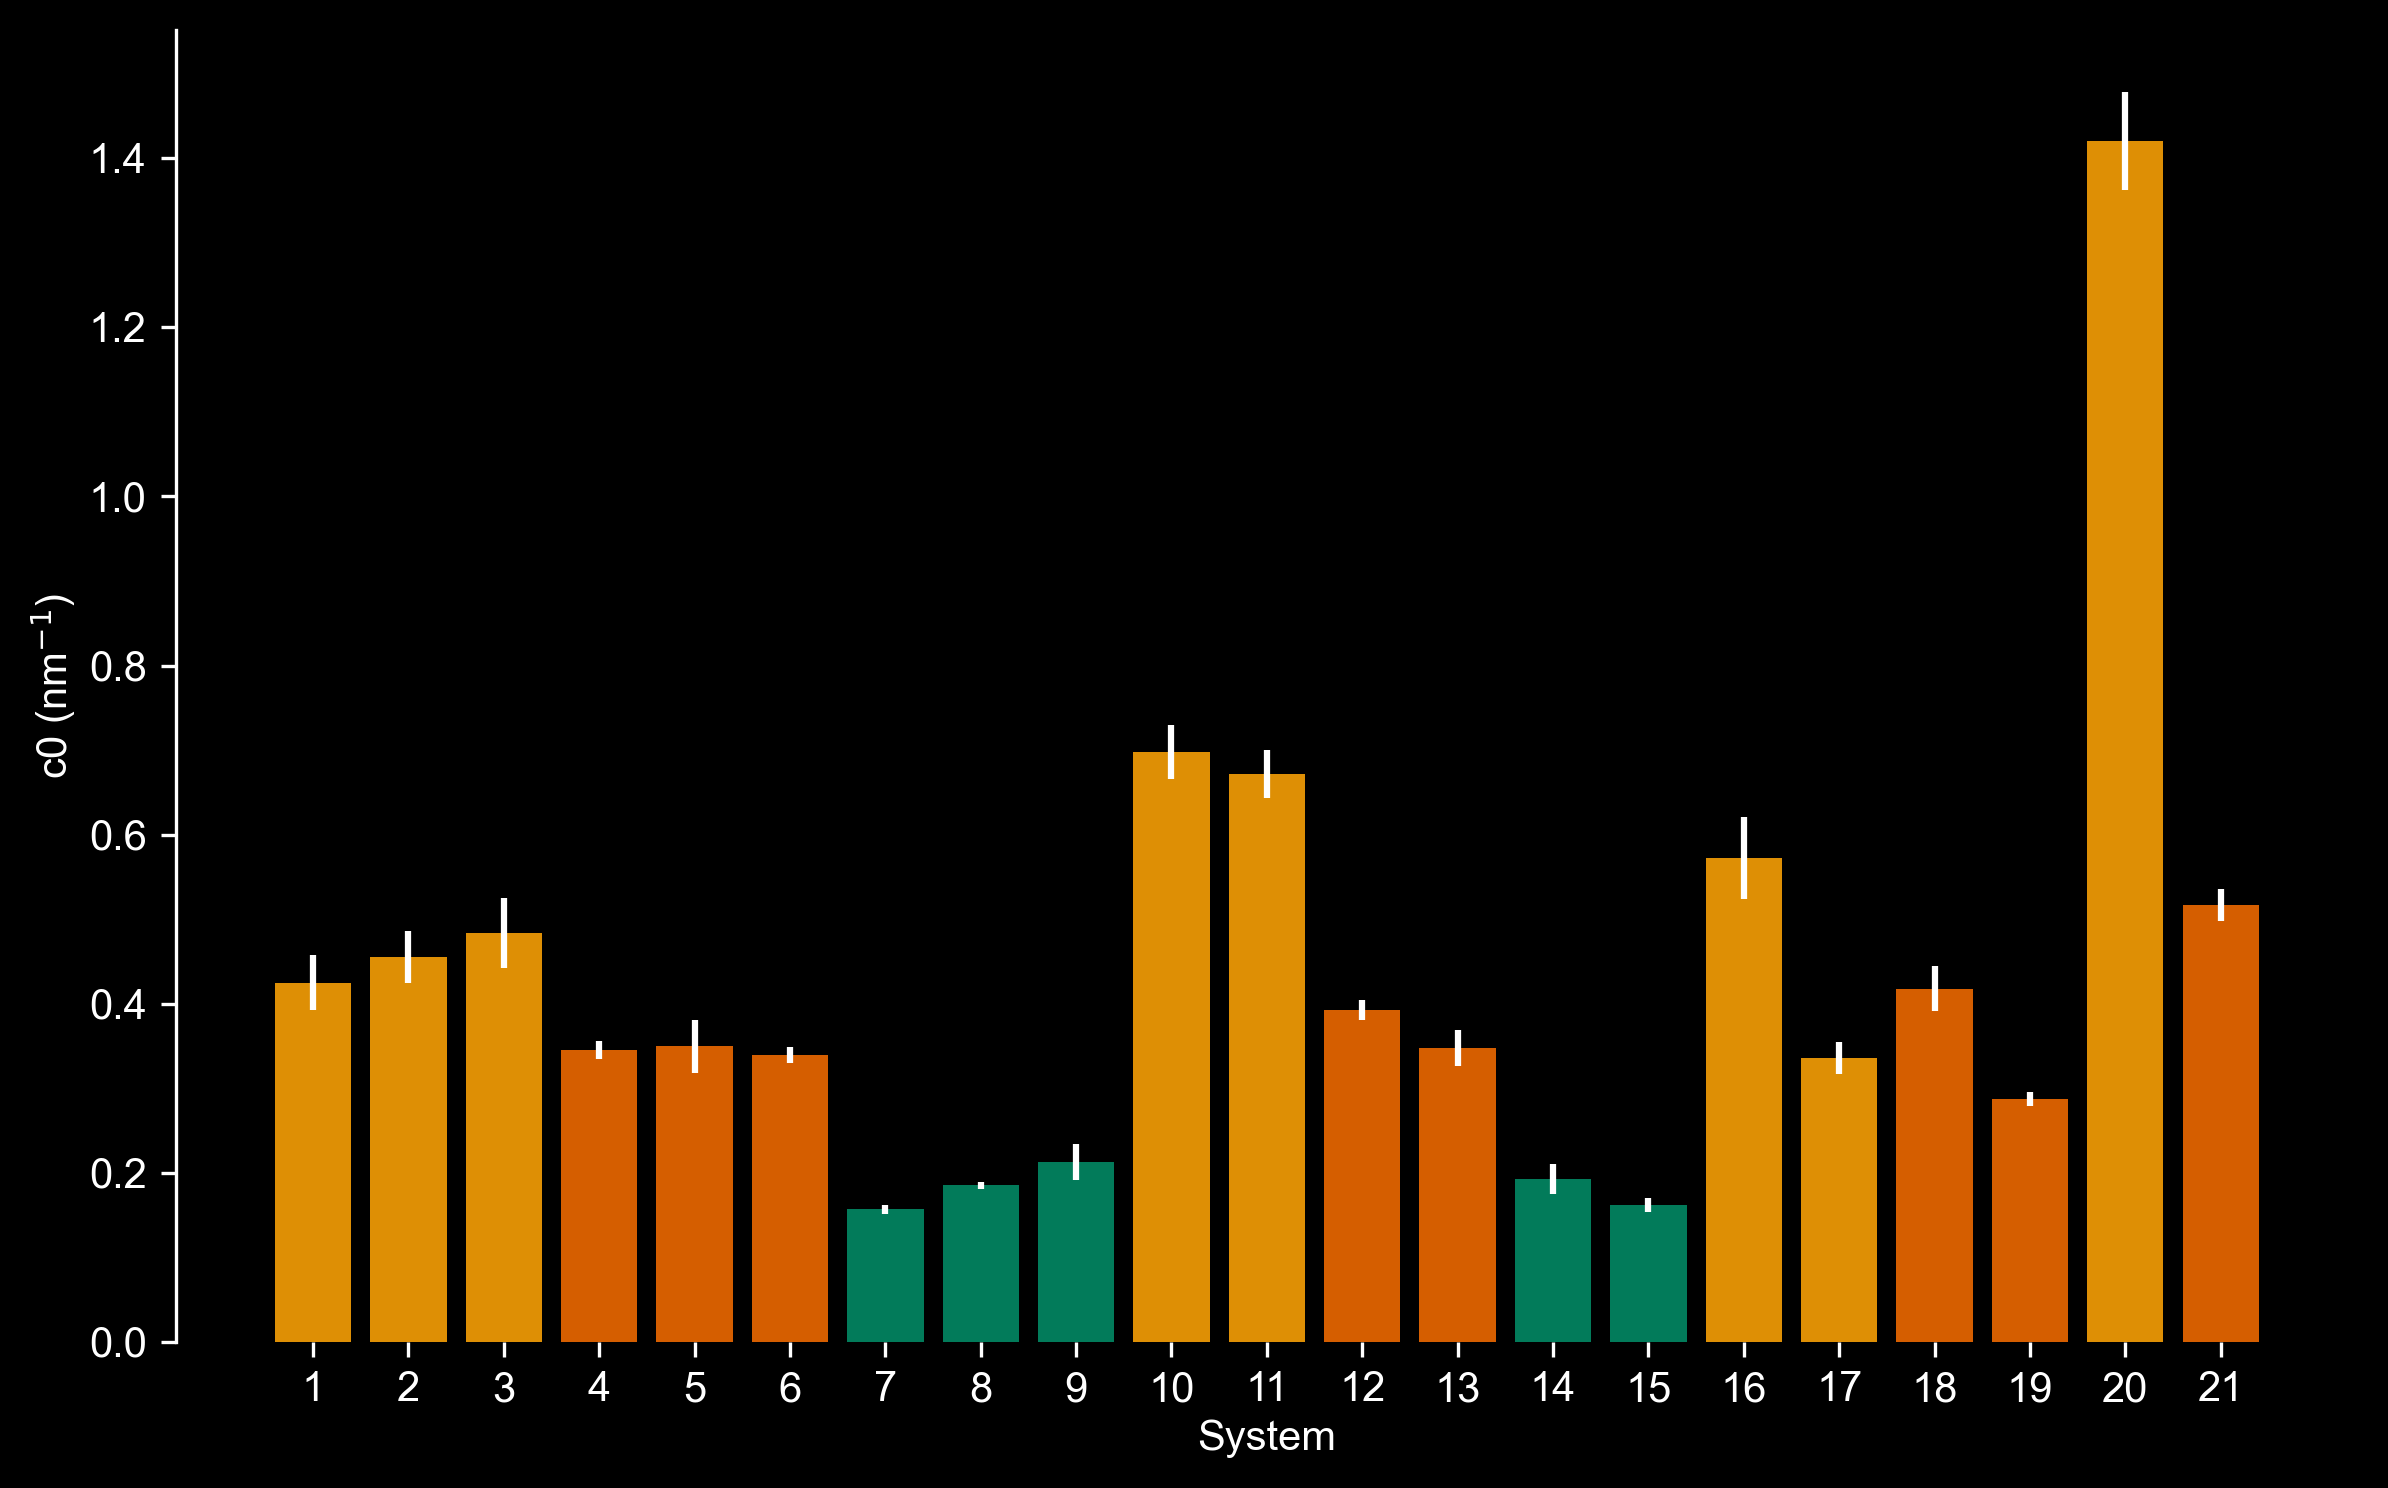

In [25]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(10, 12):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            c0[20][0],
            yerr=c0[20][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            c0[21][0],
            yerr=c0[21][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature_vertical{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


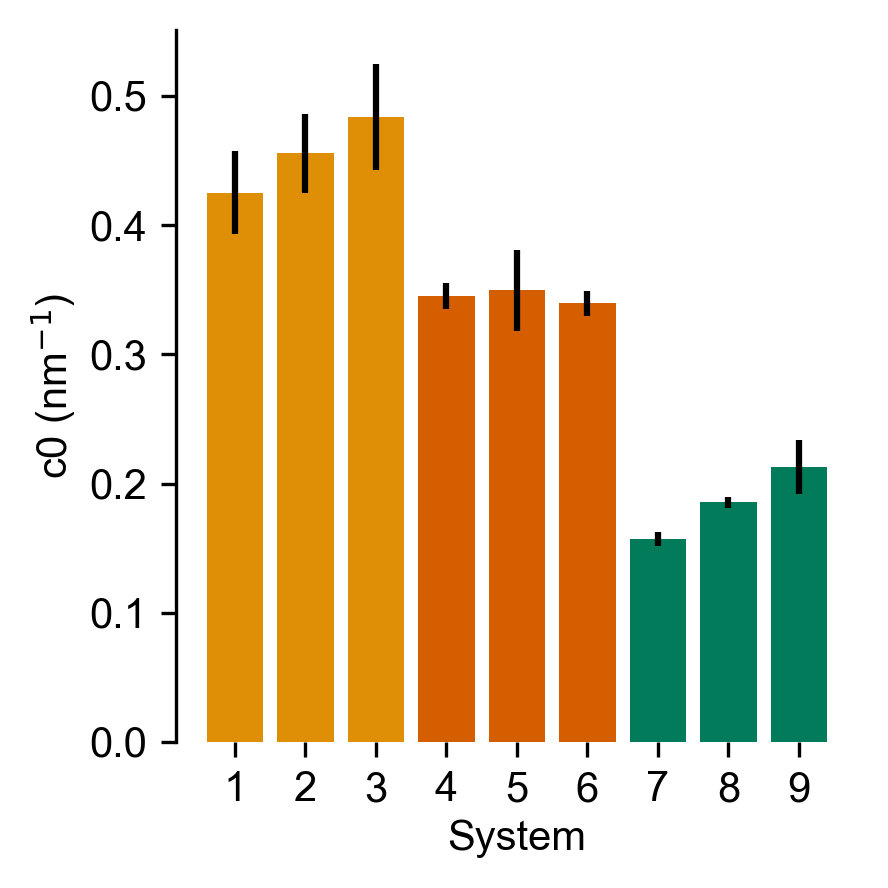

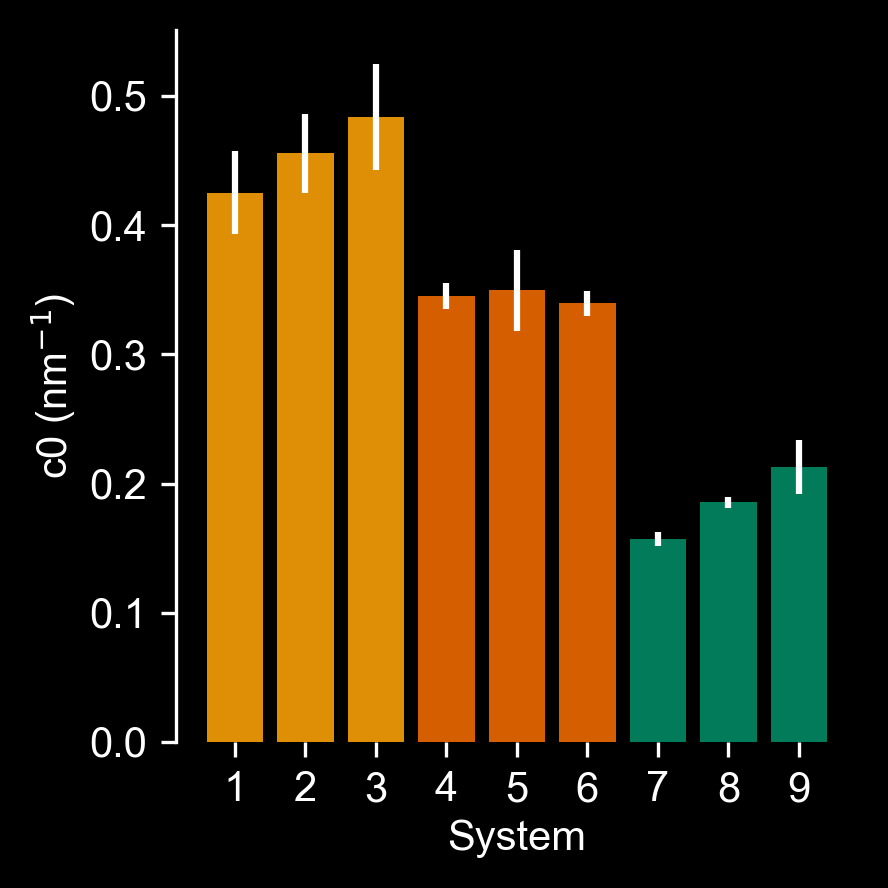

In [26]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(1, 4):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(10, 12):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(12, 14):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(14, 16):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        # for i in range(16, 18):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(18, 20):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # ax.bar("20", c0[20][0], yerr=c0[20][1],color=pal[1], )

        # ax.bar("21", c0[21][0], yerr=c0[21][1],color=pal[3], )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature1-9{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


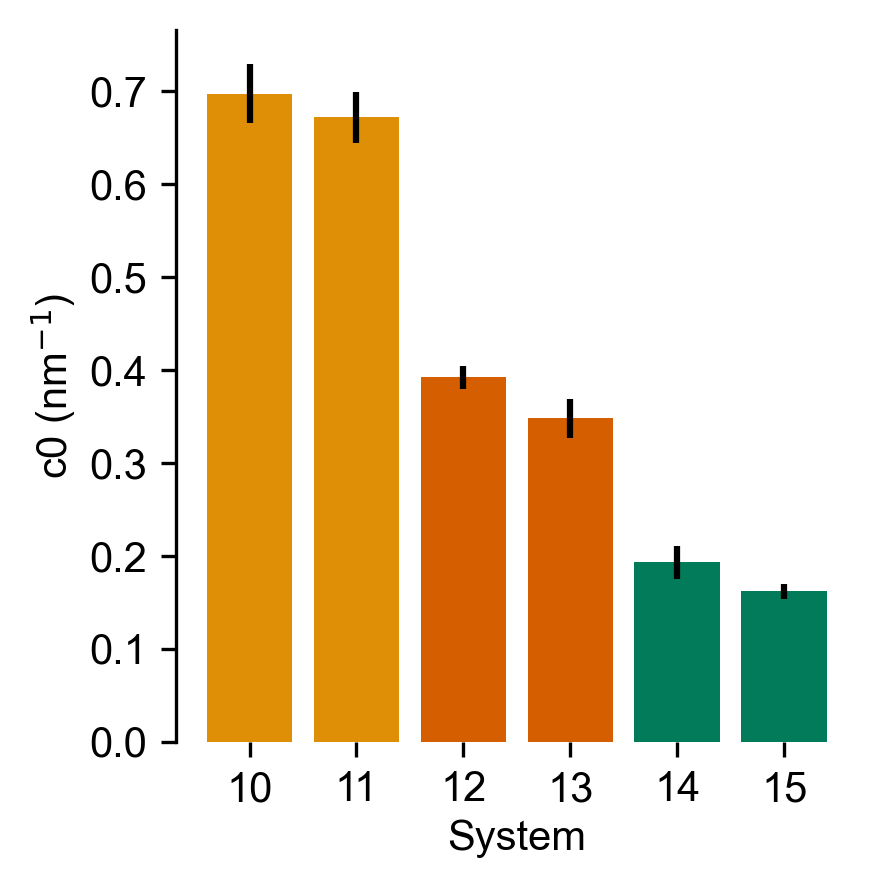

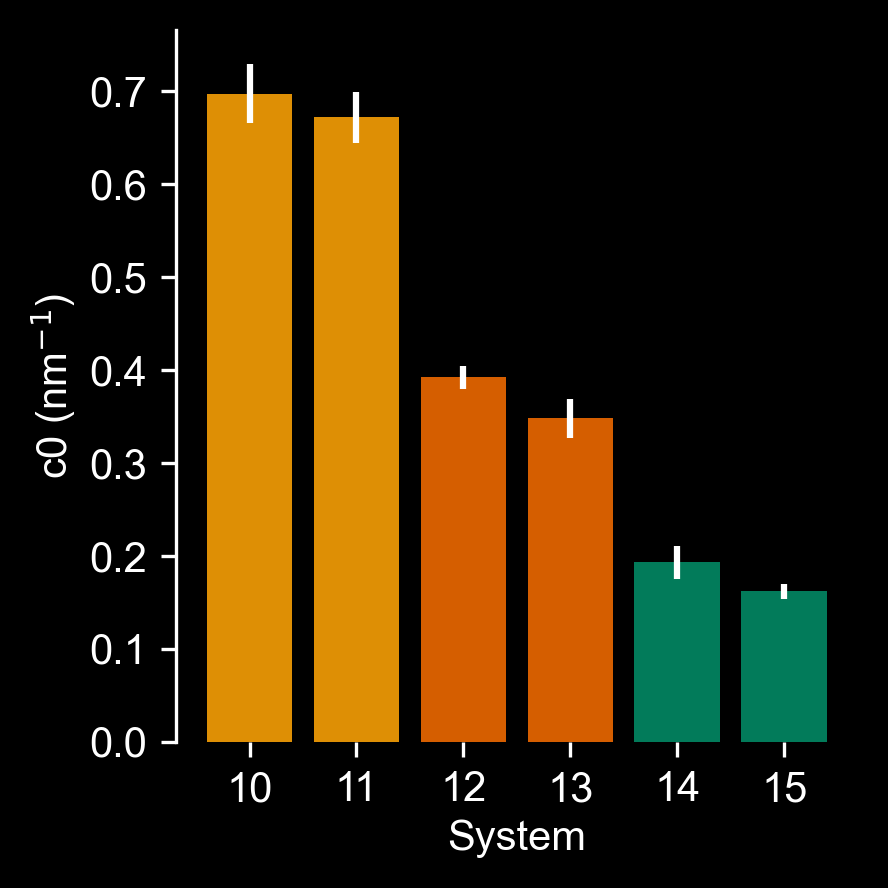

In [27]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        # for i in range(1, 4):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1], color=pal[1], )

        # for i in range(4, 7):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(7, 10):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        for i in range(10, 12):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(16, 18):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(18, 20):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # ax.bar("20", c0[20][0], yerr=c0[20][1],color=pal[1], )

        # ax.bar("21", c0[21][0], yerr=c0[21][1],color=pal[3], )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


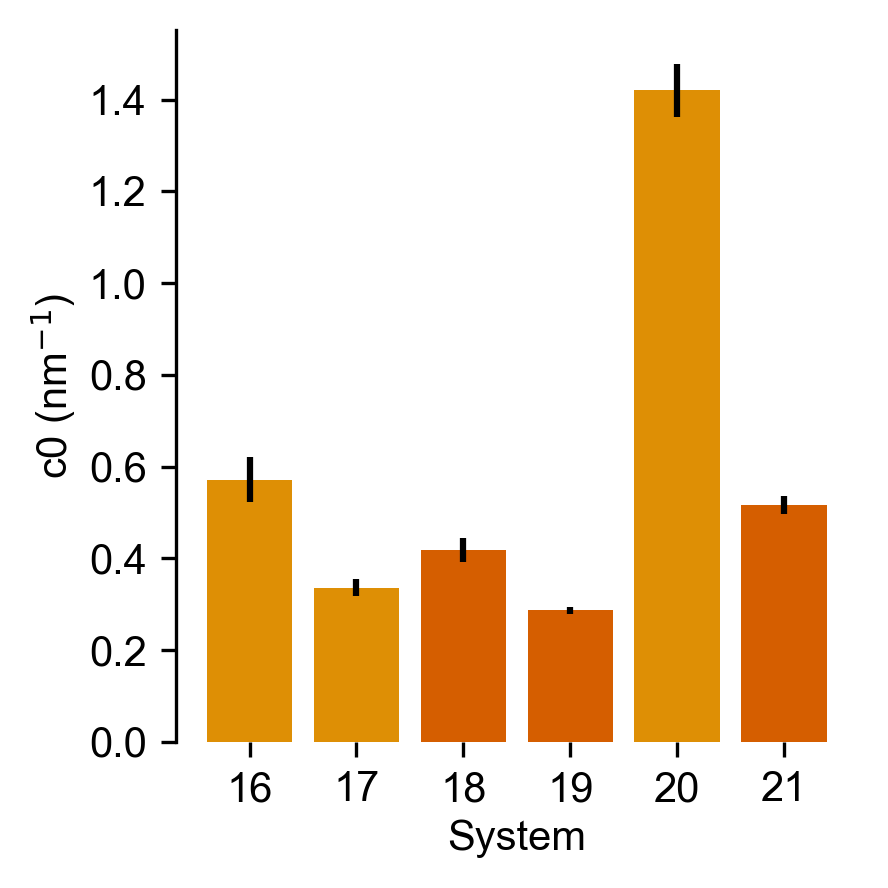

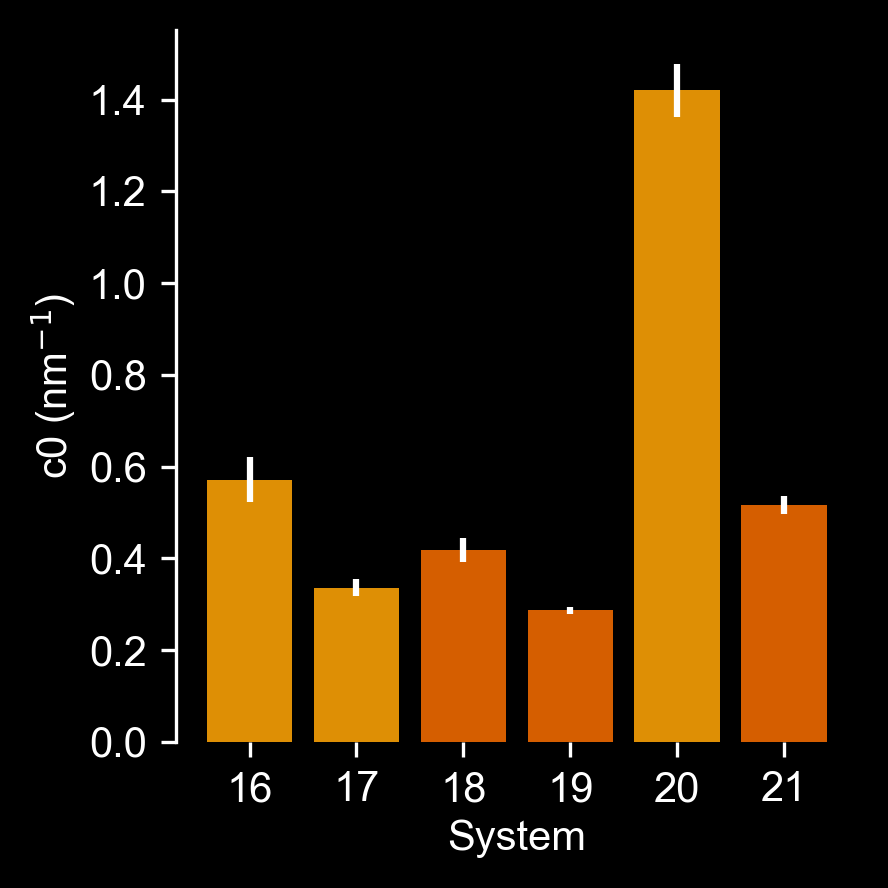

In [28]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        # for i in range(1, 4):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1], color=pal[1], )

        # for i in range(4, 7):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(7, 10):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        # for i in range(10, 12):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(12, 14):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(14, 16):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        for i in range(16, 18):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            c0[20][0],
            yerr=c0[20][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            c0[21][0],
            yerr=c0[21][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature16-21{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [29]:
# f_cubic_dat = {}
# z_cubic_dat = {}
# msd_dat = {}

# for sim in util.simulations:
#     try:
#         data = np.mean(lateral_pressure[sim], axis=0)

#         z = data[:, 2]
#         lp = data[:, 1]
#         szz = data[:, 0]

#         fcd = first_cubic_np(z, lp)
#         f_cubic_dat[sim] = (
#             first_cubic_np(z, lp, maxz=0)[0] - first_cubic_np(z, lp, minz=0)[0]
#         ) / 2
#         # print(first_cubic(z, lp, minz=0)[0], first_cubic(z, lp, maxz=0)[0])

#         zcd = zero_cubic_np(z, lp)
#         z_cubic_dat[sim] = zero_cubic_np(z, lp)[0]

#         msd = mean_squared_deviation_np(szz)
#         msd_dat[sim] = msd
#         print(
#             f"{util.system_names[sim]}\n" f"         Zero Moment (pN/nm): {zcd}\n",
#             f"          First Moment (pN): {fcd}\n",
#             f"Monolayer First Moment (pN): {f_cubic_dat[sim]} {first_cubic_np(z, lp, maxz=0)[0]} {first_cubic_np(z, lp, minz=0)[0]}\n",
#             f"                MSD (kPa^2): {msd}\n",
#             f"      Upper Leaflet Tension: {zero_cubic_np(z, lp, minz=0)}\n",
#             f"      Lower Leaflet Tension: {zero_cubic_np(z, lp, maxz=0)}\n",
#         )
#     except Exception as e:
#         print(
#             f"{util.system_names[sim]}\n" f"{e}\n",
#         )
# np.save("f_cubic_dat.npy", f_cubic_dat)
# np.save("z_cubic_dat.npy", z_cubic_dat)
# np.save("msd_dat.npy", msd_dat)
